<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/AUDUSD/AUDUSD_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AUDUSD"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-24 10:59:16,536 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-24 10:59:16,537 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for AUDUSD
2019-08-24 11:02:50,537 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-24 11:10:44,965 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-24 11:14:03,623 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-24 11:17:35,756 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-24 11:21:47,067 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-24 11:25:46,364 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-24 11:29:09,833 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-24 11:33:11,831 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-30

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-24 11:45:28,194 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_436__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_AUDUSD__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-AUDUSD__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-AUDUSD to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close       Volume
Date                                                                
2018-01-01 22:00:00  0.78043  0.78173  0.77910  0.78146  1436.320068
2018-01-01 23:00:00  0.78140  0.78143  0.77943  0.77987  5022.520020
2018-01-02 00:00:00  0.77987  0.78129  0.77987  0.78125  3243.840088
2018-01-02 01:00:00  0.78123  0.78268  0.78103  0.78188  5189.169922
2018-01-02 02:00:00  0.78184  0.78233  0.78179  0.78211  3486.640137
...                      ...      ...      ...      ...          ...
2018-12-31 17:00:00  0.70456  0.70474  0.70403  0.70425  4867.319824
2018-12-31 18:00:00  0.70425  0.70462  0.70396  0.70429  2684.649902
2018-12-31 19:00:00  0.70429  0.70471  0.70417  0.70449  2686.000000
2018-12-31 20:00:00  0.70449  0.70469  0.70422  0.70438  3155.590088
2018-12-31 21:00:00  0.70436  0.70565  0.70392  0.70409  1964.189941

[6216 rows x 5 columns]

Open         High          Low        Close        Volume
count  6216.000000  6216.000000  6216.000000  6216.000000   6216.000000
mean      0.747737     0.748331     0.747144     0.747723   4971.834473
std       0.028113     0.028148     0.028077     0.028115   2690.245850
min       0.701880     0.702370     0.701630     0.701870    148.460007
25%       0.723455     0.723957     0.722878     0.723430   3247.062622
50%       0.741770     0.742310     0.741225     0.741770   4683.764893
75%       0.771690     0.772223     0.771100     0.771650   6312.324951
max       0.813340     0.813550     0.811210     0.813340  76686.281250

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close       Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2018-01-04 00:00:00  0.78264  0.78280  0.78202  0.78233  3277.209961    4          3          4             31     0             0               1               0                 1      1        1     1        3             3           1  0.783379  0.774701 -0.784333  0.782780  0.783076  0.783052    0.783200    0.783235  0.784151  0.783399  0.782431  0.783471  0.783064  0.783399  0.782547  0.783318                0.784800                 0.783399                0.781998                0.785500                 0.783399                0.781297                0.786201                 0.783399                0.780597                0.786902                 0.783399                0.779896  0.783076  0.782619  0.783381                0.784477                 0.783076                0.781675                0.785177                 0.783076                0.780974                0.785878                 0.783076                0.780274                0.786579                 0.783076   
2018-01-04 01:00:00  0.78233  0.78234  0.78140  0.78186  3634.310059    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  0.783303  0.774916 -0.784194  0.782366  0.782806  0.782522    0.782965    0.782925  0.783981  0.783123  0.781982  0.783137  0.782722  0.783123  0.782095  0.783302                0.784740                 0.783123                0.781505                0.785549                 0.783123                0.780696                0.786358                 0.783123                0.779887                0.787166                 0.783123                0.779079  0.782806  0.782063  0.783346                0.784423                 0.782806                0.781188                0.785232                 0.782806                0.780379                0.786041                 0.782806                0.779571                0.786849                 0.782806   
2018-01-04 02:00:00  0.78185  0.78319  0.781

Open         High          Low        Close        Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  6166.000000  6166.000000  6166.000000  6166.000000   6166.000000  6166.000000  6166.000000  6166.000000    6166.000000  6166.000000   6166.000000     6166.000000     6166.000000       6166.000000  6166.000000  6166.000000  6166.000000  6166.000000   6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000             6166.000000              6166.000000             6166.000000             6166.000000              6166.000000             6166.000000             6166.000000              6166.000000             6166.000000             6166.000000              6166.000000             6166.000000  6166.000000  6166.000000  6166.000000             6166.000000              6166.000000             6166.000000             6166.000000              6166.000000             6166.000000             6166.000000   
mean      0.747453     0.748047     0.746859     0.747438   4984.766602    15.904314     2.049465   183.891502      30.440804    11.489296      0.034382        0.972429        0.004054          0.995135     6.549627     2.520435    26.649043     2.049465      2.027246    26.649043     0.747485     0.747556    -0.021803     0.747439     0.747484     0.747504     0.747473     0.747484     0.747531     0.747484     0.747439     0.747484     0.747469     0.747484     0.747450     0.747573                0.749073                 0.747484                0.745894                0.749868                 0.747484                0.745100                0.750663                 0.747484                0.744305                0.751457                 0.747484                0.743510     0.747484     0.747449     0.747559                0.749073                 0.747484                0.745894                0.749868                 0.747484                0.745100                0.750663   
std       0.028049     0.028085     0.028012     0.028050   2695.857178     8.726348     1.509092   104.071191       0.844225     6.925965      0.182223        0.163752        0.063551          0.069588     3.411547     1.113139    14.866808     1.509092      1.457226    14.866808     0.028028     0.027946     0.747783     0.028056     0.028022     0.028020     0.028018     0.028006     0.028013     0.028029     0.028054     0.028033     0.028034     0.028029     0.028044     0.027992                0.028133                 0.028029                0.027957                0.028196                 0.028029                0.027932                0.028267                 0.028029                0.027916                0.028346                 0.028029                0.027907     0.028022     0.028043     0.027997                0.028126                 0.028022                0.027950                0.028189                 0.028022                0.027925                0.028260   
min       0.701880     0.702370     0.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-04 00:00:00  0.724565  0.723422  0.733619  0.721808  0.040878    4          3          4             31     0             0               1               0                 1      1        1     1        3             3           1  0.747636  0.673687  0.017998  0.733666  0.742310  0.748904    0.737644    0.738027  0.737325  0.742549  0.728432  0.743218  0.740635  0.742549  0.731027  0.749889                0.738390                 0.742549                0.745501                0.728365                 0.742549                0.750284                0.711176                 0.742549                0.754931                0.694867                 0.742549                0.756185  0.742310  0.729788  0.749611                0.733228                 0.742310                0.745201                0.727647                 0.742310                0.749047                0.714875                 0.742310                0.750250                0.698254                 0.742310   
2018-01-04 01:00:00  0.721783  0.719284  0.727962  0.717592  0.045544    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  0.746936  0.675719  0.018084  0.729909  0.739816  0.743938    0.735493    0.735189  0.735801  0.740016  0.724376  0.740160  0.737498  0.740016  0.726926  0.749739                0.737847                 0.740016                0.740996                0.728797                 0.740016                0.744868                0.712537                 0.740016                0.748630                0.697109                 0.740016                0.749056  0.739816  0.724755  0.749281                0.732740                 0.739816                0.740721                0.728137                 0.739816                0.743630                0.716308                 0.739816                0.743946                0.700578                 0.739816   
2018-01-04 02:00:00  0.717477  0.726929  

140223

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpuwjgm4zc
  JVM stdout: /tmp/tmpuwjgm4zc/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpuwjgm4zc/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 5 days
H2O cluster name:           H2O_from_python_unknownUser_mxbcet
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_120007_mod...  0.737650  0.614713              0.336351  0.459636  0.211265
1  DeepLearning_grid_1_AutoML_20190824_120007_mod...  0.732240  0.703772              0.331472  0.473985  0.224662
2              DeepLearning_1_AutoML_20190824_120007  0.732008  0.646830              0.344327  0.469680  0.220599
3  DeepLearning_grid_1_AutoML_20190824_120007_mod...  0.730825  0.631024              0.341530  0.466255  0.217394
4  DeepLearning_grid_1_AutoML_20190824_120007_mod...  0.729327  1.091465              0.352571  0.532617  0.283681
5  DeepLearning_grid_1_AutoML_20190824_120007_mod...  0.720568  0.613397              0.325074  0.459481  0.211123
6  DeepLearning_grid_1_AutoML_20190824_120007_mod...  0.717950  0.725446              0.342692  0.482849  0.233143
7  DeepLearning_grid_1_AutoML_20190824_120007_mod...  0.703533  0.624426              0.369027  0.466913  0.218007

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.011088
1           CDLCLOSINGMARUBOZU             0.923915           0.923915    0.010245
2                  CDLLONGLINE             0.584521           0.584521    0.006481
3                          DIV             0.459624           0.459624    0.005096
4                 CDLSHORTLINE             0.457674           0.457674    0.005075
...                        ...                  ...                ...         ...
1035                   SAR_0.3             0.063213           0.063213    0.000701
1036  BBANDS_middleband_24_3_5             0.063155           0.063155    0.000700
1037   BBANDS_middleband_8_4_3             0.063133           0.063133    0.000700
1038                    SMA_30             0.062669           0.062669    0.000695
1039        CDLSEPARATINGLINES             0.054833           0.054833    0.000608

[1040 rows x 4 columns]

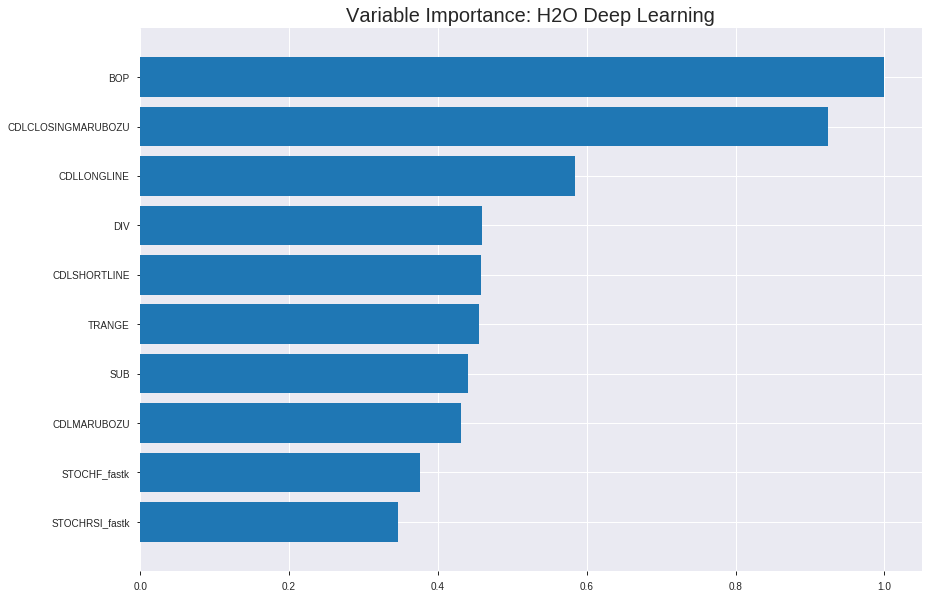

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_120007_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19879778006855026
RMSE: 0.44586744674684453
LogLoss: 0.5817235765986295
Mean Per-Class Error: 0.3034034191215432
AUC: 0.7685737677799231
pr_auc: 0.7321320120093842
Gini: 0.5371475355598463
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4816617374962213: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1258  1010  0.4453   (1010.0/2268.0)
1      357   1690  0.1744   (357.0/2047.0)
Total  1615  2700  0.3168   (1367.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.481662     0.712029  211
max f2                       0.21823      0.834942  321
max f0point5                 0.53133      0.683818  173
max accuracy                 0.513566     0.695944  187
max precision                0.998089     1         0
max recall                   0.0169736    1         393
max specificity              0.998089     1         0
max absolute_mcc             0.493734     0.397638  203
max min_per_class_accuracy   0.515898     0.695164  185
max mean_per_class_accuracy  0.513566     0.696597  187

Gains/Lift Table: Avg response rate: 47.44 %, avg score: 48.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.9788             1.91633   1.91633            0.909091         0.98871    0.909091                    0.98871             0.0195408       0.0195408                  91.633    91.633
    2        0.0201622                   0.961306           1.81383   1.86567            0.860465         0.969348   0.885057                    0.979141            0.0180752       0.037616                   81.3829   86.5668
    3        0.0301275                   0.935953           1.71578   1.81609            0.813953         0.949437   0.861538                    0.969316            0.0170982       0.0547142                  71.5784   81.6091
    4        0.0400927                   0.907792           1.9609    1.85208            0.930233         0.920441   0.878613                    0.957168            0.0195408       0.074255                   96.0896   85.2083
    5        0.0500579                   0.881706           2.00992   1.8835             0.953488         0.895084   0.893519                    0.944808            0.0200293       0.0942843                  100.992   88.3504
    6        0.100116                    0.766842           1.70784   1.79567            0.810185         0.820986   0.851852                    0.882897            0.085491        0.179775                   70.784    79.5672
    7        0.150174                    0.674861           1.61025   1.73386            0.763889         0.717523   0.822531                    0.827772            0.0806058       0.260381                   61.0249   73.3865
    8        0.2                         0.616026           1.51969   1.68051            0.72093          0.644968   0.797219                    0.78223             0.0757206       0.336102                   51.9694   68.0508
    9        0.300116                    0.55918            1.35651   1.57243            0.643519         0.583173   0.745946                    0.715827            0.135809        0.47191                    35.6513   57.2426
    10       0.4                         0.531297           1.25695   1.49365            0.596288         0.544332   0.708575                    0.673003            0.12555         0.59746                    25.6952   49.3649
    11       0.500116                    0.513388           1.08814   1.41247            0.516204         0.521013   0.670065                    0.642577            0.10894         0.7064                     8.81382   41.2472
    12       0.6                         0.490828           0.987955  1.3418             0.468677         0.503119   0.636539                    0.619361            0.098681        0.805081                   -1.20452  34.1801
    13       0.699884                    0.44023            0.709175  1.25152            0.336427         0.468503   0.593709                    0.597831            0.0708354       0.875916                   -29.0825  25.1516
    14       0.8                         0.325815           0.668497  1.17855            0.31713          0.388675   0.559096                    0.571656            0.0669272       0.942843                   -33.1503  17.8554
    15       0.899884                    0.140019           0.391269  1.09117            0.185615         0.24016    0.517641                    0.534861            0.0390816       0.981925                   -60.8731  9.1168
    16       1                           8.40798e-05        0.180543  1                  0.0856481        0.0628775  0.474392                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20865848693653155
RMSE: 0.4567915136432939
LogLoss: 0.6047141242007841
Mean Per-Class Error: 0.2915245808468314
AUC: 0.7763095576394808
pr_auc: 0.7650468954726035
Gini: 0.5526191152789617
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48849730848613354: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      372  249  0.401    (249.0/621.0)
1      124  488  0.2026   (124.0/612.0)
Total  496  737  0.3025   (373.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488497     0.723499  188
max f2                       0.290876     0.840858  311
max f0point5                 0.527112     0.724124  149
max accuracy                 0.516269     0.70884   159
max precision                0.642317     0.93      56
max recall                   0.103776     1         373
max specificity              0.958536     0.99839   0
max absolute_mcc             0.527112     0.424104  149
max min_per_class_accuracy   0.5102       0.704248  167
max mean_per_class_accuracy  0.514943     0.708475  160

Gains/Lift Table: Avg response rate: 49.64 %, avg score: 47.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.826237           1.54977   1.54977            0.769231         0.904764  0.769231                    0.904764            0.0163399       0.0163399                  54.9774   54.9774
    2        0.0202758                   0.770038           2.01471   1.77294            1                0.802818  0.88                        0.85583             0.0196078       0.0359477                  101.471   77.2941
    3        0.0300081                   0.734952           2.01471   1.85135            1                0.758016  0.918919                    0.824106            0.0196078       0.0555556                  101.471   85.1351
    4        0.0405515                   0.708649           1.70475   1.81324            0.846154         0.723657  0.9                         0.797989            0.0179739       0.0735294                  70.4751   81.3235
    5        0.0502839                   0.684544           1.84681   1.81973            0.916667         0.691512  0.903226                    0.777381            0.0179739       0.0915033                  84.6814   81.9734
    6        0.100568                    0.627834           1.75474   1.78724            0.870968         0.650622  0.887097                    0.714001            0.0882353       0.179739                   75.4744   78.7239
    7        0.150041                    0.591634           1.75048   1.77512            0.868852         0.606119  0.881081                    0.678429            0.0866013       0.26634                    75.0482   77.5119
    8        0.200324                    0.569902           1.49478   1.70475            0.741935         0.579519  0.846154                    0.653602            0.0751634       0.341503                   49.4782   70.4751
    9        0.300081                    0.541022           1.42504   1.61176            0.707317         0.553927  0.8                         0.620466            0.142157        0.48366                    42.5036   61.1765
    10       0.399838                    0.51834            1.17934   1.50388            0.585366         0.529356  0.74645                     0.597735            0.117647        0.601307                   17.934    50.3878
    11       0.500406                    0.509185           1.0561    1.41389            0.524194         0.514598  0.701783                    0.581027            0.106209        0.707516                   5.60958   41.3886
    12       0.600162                    0.487495           0.917264  1.33134            0.455285         0.498538  0.660811                    0.567316            0.0915033       0.79902                    -8.27355  33.1339
    13       0.699919                    0.454151           0.622429  1.2303             0.308943         0.473927  0.61066                     0.554005            0.0620915       0.861111                   -37.7571  23.0301
    14       0.799676                    0.399549           0.58967   1.15038            0.292683         0.428723  0.570994                    0.538377            0.0588235       0.919935                   -41.033   15.0385
    15       0.899432                    0.266506           0.556911  1.08456            0.276423         0.343232  0.538323                    0.516733            0.0555556       0.97549                    -44.3089  8.45621
    16       1                           0.00232412         0.243714  1                  0.120968         0.149304  0.49635                     0.479782         


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 12:27:11  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 12:27:14  12 min 23.484 sec  310 obs/sec       0.162457  1             701        0.536746         0.895488            -0.155415      0.615378        0.575524           1.58097          0.496176                         0.577546           1.04234               -0.334309        0.638278          0.626716             1.70475            0.497972
    2019-08-24 12:28:07  13 min 16.922 sec  491 obs/sec       5.74137   37            24774      0.485874         0.663995            0.0532205      0.64857         0.607              1.91633          0.438239                         0.488815           0.670765              0.044187         0.670652          0.637375             1.3948             0.418491
    2019-08-24 12:29:01  14 min 10.530 sec  509 obs/sec       11.6512   75            50275      0.46675          0.62278             0.126286       0.704134        0.660585           1.82051          0.361993                         0.484881           0.660419              0.0595124        0.731001          0.699799             1.70475            0.351176
    2019-08-24 12:29:54  15 min  3.816 sec  511 obs/sec       17.3926   112           75049      0.460355         0.609446            0.150063       0.722007        0.686452           1.77261          0.380533                         0.482943           0.658387              0.0670128        0.748304          0.73391              1.54977            0.3382
    2019-08-24 12:30:47  15 min 57.054 sec  515 obs/sec       23.2742   150           100428     0.448111         0.58569             0.194674       0.756141        0.71745            1.77261          0.324681                         0.464308           0.618755              0.137628         0.76265           0.745742             1.54977            0.311436
    2019-08-24 12:31:40  16 min 49.939 sec  519 obs/sec       29.2093   188           126038     0.453757         0.596488            0.174251       0.754992        0.71753            1.77261          0.343453                         0.457921           0.606482              0.161188         0.769771          0.750171             1.54977            0.301703
    2019-08-24 12:32:32  17 min 42.366 sec  523 obs/sec       35.1196   226           151541     0.446156         0.580681            0.201685       0.762949        0.728132           1.86842          0.336269                         0.465333           0.622544              0.133813         0.76729           0.753539             1.54977            0.334955
    2019-08-24 12:33:25  18 min 35.347 sec  526 obs/sec       41.181    265           177696     0.445867         0.581724            0.202717       0.768574        0.732132           1.91633          0.316802                         0.456792           0.604714              0.165322         0.77631           0.765047             1.54977            0.302514
    2019-08-24

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ---------------------
BOP                       1.0                    1.0                   0.011088300558819389
CDLCLOSINGMARUBOZU        0.9239149689674377     0.9239149689674377    0.010244646866703238
CDLLONGLINE               0.5845211744308472     0.5845211744308472    0.006481346465083328
DIV                       0.45962411165237427    0.45962411165237427   0.005096450294081887
CDLSHORTLINE              0.4576736390590668     0.4576736390590668    0.005074822867735553
---                       ---                    ---                   ---
SAR_0.3                   0.0632127895951271     0.0632127895951271    0.0007009224101921803
BBANDS_middleband_24_3_5  0.06315498054027557    0.06315498054027557   0.0007002814060169652
BBANDS_middleband_8_4_3   0.06313277781009674    0.06313277781009674   0.0007000352154715161
SMA_30                    0.0626688152551651     0.0626688152551651    0.0006948906592143963
CDLSEPARATINGLINES        0.054832976311445236   0.054832976311445236  0.0006080045218759285


See the whole table with table.as_data_frame()


('accuracy', 0.6774716369529984)

('F1', 0.7239583333333333)

('auc', 0.7376498422712934)

('logloss', 0.6147129273886415)

('mean_per_class_error', 0.3187066246056782)

('rmse', 0.4596361321034851)

('mse', 0.2112653739350524)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


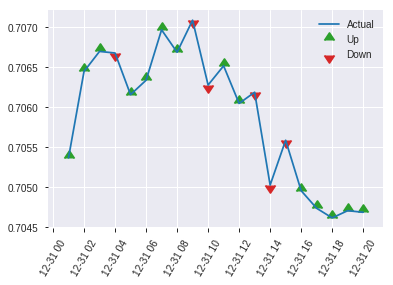


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2112653739350524
RMSE: 0.4596361321034851
LogLoss: 0.6147129273886415
Mean Per-Class Error: 0.3187066246056782
AUC: 0.7376498422712934
pr_auc: 0.7121968818647515
Gini: 0.47529968454258675
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40075892246736466: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      127  190  0.5994   (190.0/317.0)
1      22   278  0.0733   (22.0/300.0)
Total  149  468  0.3436   (212.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.400759     0.723958  271
max f2                       0.388026     0.83632   276
max f0point5                 0.478332     0.66048   210
max accuracy                 0.478332     0.677472  210
max precision                0.993592     1         0
max recall                   0.00402751   1         399
max specificity              0.993592     1         0
max absolute_mcc             0.400759     0.382223  271
max min_per_class_accuracy   0.5013       0.652997  174
max mean_per_class_accuracy  0.474119     0.681293  215

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 46.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.852289           1.76286   1.76286            0.857143         0.90674    0.857143                    0.90674             0.02            0.02                       76.2857   76.2857
    2        0.0210697                   0.795955           2.05667   1.89846            1                0.807441   0.923077                    0.860909            0.02            0.04                       105.667   89.8462
    3        0.0307942                   0.753365           1.37111   1.73193            0.666667         0.773461   0.842105                    0.833294            0.0133333       0.0533333                  37.1111   73.193
    4        0.0405186                   0.716785           1.71389   1.7276             0.833333         0.735599   0.84                        0.809847            0.0166667       0.07                       71.3889   72.76
    5        0.0502431                   0.683516           2.05667   1.79129            1                0.702159   0.870968                    0.789004            0.02            0.09                       105.667   79.129
    6        0.100486                    0.603045           1.79129   1.79129            0.870968         0.635681   0.870968                    0.712343            0.09            0.18                       79.129    79.129
    7        0.150729                    0.571969           1.59226   1.72495            0.774194         0.586779   0.83871                     0.670488            0.08            0.26                       59.2258   72.4946
    8        0.200972                    0.551692           1.26054   1.60884            0.612903         0.56349    0.782258                    0.643739            0.0633333       0.323333                   26.0538   60.8844
    9        0.299838                    0.522878           1.21377   1.47858            0.590164         0.536247   0.718919                    0.608296            0.12            0.443333                   21.377    47.8577
    10       0.400324                    0.515128           1.09468   1.38221            0.532258         0.518358   0.672065                    0.58572             0.11            0.553333                   9.46774   38.2213
    11       0.50081                     0.500389           1.06151   1.31786            0.516129         0.508797   0.640777                    0.570286            0.106667        0.66                       6.15054   31.7864
    12       0.599676                    0.485098           1.18005   1.29514            0.57377          0.493594   0.62973                     0.557642            0.116667        0.776667                   18.0055   29.5144
    13       0.700162                    0.439163           0.862473  1.23305            0.419355         0.464388   0.599537                    0.544258            0.0866667       0.863333                   -13.7527  23.3048
    14       0.799028                    0.351105           0.741749  1.17226            0.360656         0.399613   0.56998                     0.526361            0.0733333       0.936667                   -25.8251  17.2258
    15       0.899514                    0.213589           0.33172   1.07836            0.16129          0.294464   0.524324                    0.500455            0.0333333       0.97                       -66.828   7.83604
    16       1                           0.00402751         0.298548  1                  0.145161         0.0984163  0.486224                    0.46

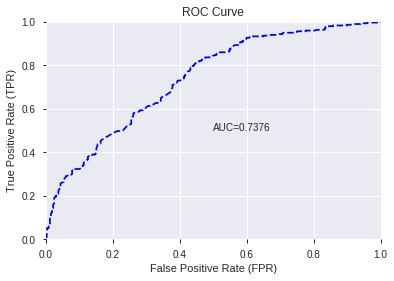

This function is available for GLM models only


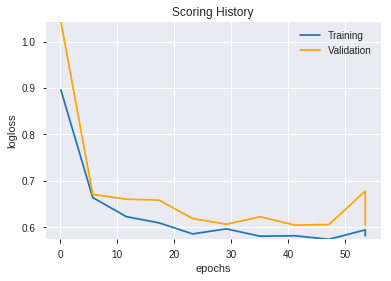

--2019-08-24 13:00:21--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  58.9MB/s    in 6.0s    

2019-08-24 13:00:27 (58.7 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_120007_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_120007_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_b8e3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_130122_model_9  0.755499  0.601764              0.324984  0.452637  0.204880
1  DeepLearning_grid_1_AutoML_20190824_130122_model_7  0.749905  0.759053              0.318943  0.477353  0.227866
2  DeepLearning_grid_1_AutoML_20190824_130122_model_8  0.749096  0.596403              0.330163  0.451594  0.203937
3  DeepLearning_grid_1_AutoML_20190824_130122_model_5  0.747234  0.599687              0.320342  0.453820  0.205952
4  DeepLearning_grid_1_AutoML_20190824_130122_model_6  0.745310  0.610453              0.322723  0.454313  0.206400
5  DeepLearning_grid_1_AutoML_20190824_130122_model_4  0.744916  0.609418              0.331830  0.455529  0.207506
6  DeepLearning_grid_1_AutoML_20190824_130122_model_3  0.737871  0.689159              0.313675  0.462765  0.214151
7               DeepLearning_1_AutoML_20190824_130122  0.720442  0.628740              0.340521  0.464850  0.216085
8  DeepLearning_grid_1_AutoML_20190824_130122_model_2  0.706425  1.041149              0.362392  0.534159  0.285325
9  DeepLearning_grid_1_AutoML_20190824_130122_model_1  0.684837  0.947640              0.371798  0.521324  0.271779

variable  relative_importance  scaled_importance  percentage
0     CDLCLOSINGMARUBOZU             1.000000           1.000000    0.071327
1                    BOP             0.595838           0.595838    0.042499
2            CDLMARUBOZU             0.541134           0.541134    0.038597
3           CDLSHORTLINE             0.509040           0.509040    0.036308
4            CDLLONGLINE             0.456832           0.456832    0.032584
5              CDLTAKURI             0.446477           0.446477    0.031846
6          CDLHANGINGMAN             0.424339           0.424339    0.030267
7       CDLDRAGONFLYDOJI             0.401196           0.401196    0.028616
8              CDLHAMMER             0.394921           0.394921    0.028168
9                    DIV             0.368092           0.368092    0.026255
10                TRANGE             0.363892           0.363892    0.025955
11                   SUB             0.337737           0.337737    0.024090
12          CDLENGULFING             0.333048           0.333048    0.023755
13     CDLGRAVESTONEDOJI             0.306061           0.306061    0.021830
14                  hour             0.302535           0.302535    0.021579
15                Volume             0.288467           0.288467    0.020575
16        STOCHRSI_fastk             0.277469           0.277469    0.019791
17          HT_TRENDMODE             0.256478           0.256478    0.018294
18          aroondown_12             0.235949           0.235949    0.016829
19             CORREL_20             0.235443           0.235443    0.016793
20         days_in_month             0.235408           0.235408    0.016791
21          STOCHF_fastk             0.235139           0.235139    0.016772
22            MINUS_DI_8             0.234110           0.234110    0.016698
23                MFI_14             0.233773           0.233773    0.016674
24                 CCI_8             0.231536           0.231536    0.016515
25                    AD             0.225786           0.225786    0.016105
26                ULTOSC             0.220261           0.220261    0.015710
27           CDLBELTHOLD             0.219043           0.219043    0.015624
28             STDDEV_30             0.218963           0.218963    0.015618
29               BETA_24             0.212489           0.212489    0.015156
30             aroonup_8             0.211219           0.211219    0.015066
31             PLUS_DM_8             0.210462           0.210462    0.015012
32                SAREXT             0.201806           0.201806    0.014394
33  HT_PHASOR_quadrature             0.200909           0.200909    0.014330
34               WILLR_8             0.200803           0.200803    0.014323
35             PLUS_DI_8             0.198662           0.198662    0.014170
36                 ADOSC             0.198007           0.198007    0.014123
37                 MFI_8             0.197277           0.197277    0.014071
38            weekofyear             0.192896           0.192896    0.013759
39               BETA_20             0.191874           0.191874    0.013686
40                  week             0.184991           0.184991    0.013195
41             dayofyear             0.182736           0.182736    0.013034
42                 month             0.179330           0.179330    0.012791
43              WILLR_12             0.177472           0.177472    0.012658
44           STOCH_slowd             0.175782           0.175782    0.012538
45              WILLR_14             0.169389           0.169389    0.012082
46              WILLR_24             0.165425           0.165425    0.011799
47              WILLR_20             0.164287           0.164287    0.011718
48                 CMO_8             0.141025           0.141025    0.010059
49                 RSI_8             0.134205           0.134205    0.009572

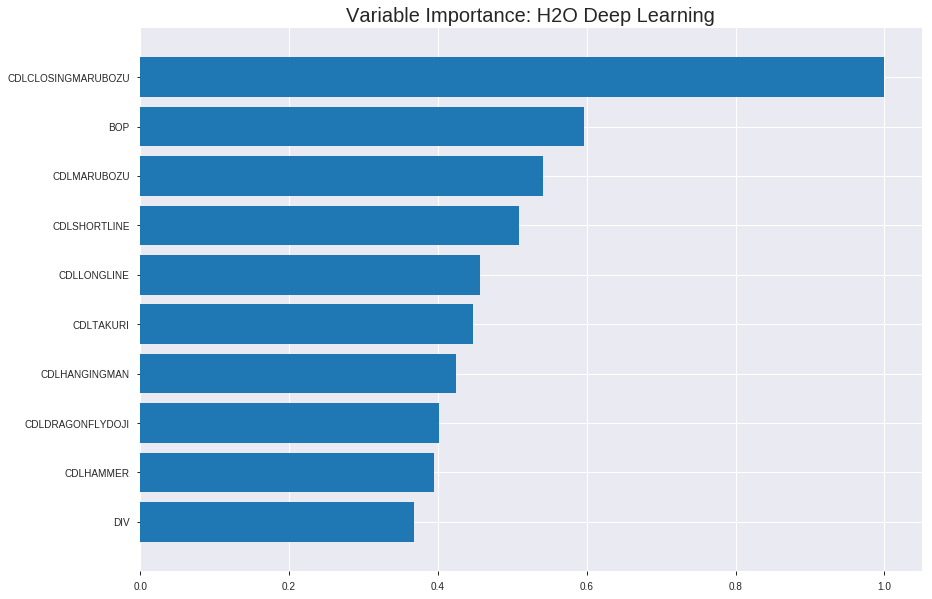

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_130122_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18747782415414785
RMSE: 0.43298709467390345
LogLoss: 0.5556015234382969
Mean Per-Class Error: 0.281631871478802
AUC: 0.7891395245246409
pr_auc: 0.7546719003183495
Gini: 0.5782790490492817
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3944062805639358: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1262  1006  0.4436   (1006.0/2268.0)
1      305   1742  0.149    (305.0/2047.0)
Total  1567  2748  0.3038   (1311.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.394406     0.72659   245
max f2                       0.159594     0.838053  335
max f0point5                 0.561229     0.706552  164
max accuracy                 0.504416     0.718656  192
max precision                0.978373     1         0
max recall                   0.00981054   1         395
max specificity              0.978373     1         0
max absolute_mcc             0.504416     0.43641   192
max min_per_class_accuracy   0.498745     0.71649   194
max mean_per_class_accuracy  0.504416     0.718368  192

Gains/Lift Table: Avg response rate: 47.44 %, avg score: 47.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.956582           1.82051   1.82051            0.863636         0.964212   0.863636                    0.964212            0.0185638       0.0185638                  82.0513   82.0513
    2        0.0201622                   0.934905           1.86285   1.84144            0.883721         0.947534   0.873563                    0.955969            0.0185638       0.0371275                  86.2851   84.1439
    3        0.0301275                   0.921599           1.81383   1.83231            0.860465         0.927774   0.869231                    0.946643            0.0180752       0.0552027                  81.3829   83.2306
    4        0.0400927                   0.907629           1.71578   1.80334            0.813953         0.91486    0.855491                    0.938743            0.0170982       0.0723009                  71.5784   80.3344
    5        0.0500579                   0.891666           1.91187   1.82495            0.906977         0.900072   0.865741                    0.931045            0.0190523       0.0913532                  91.1873   82.4949
    6        0.100116                    0.806051           1.85423   1.83959            0.87963          0.846728   0.872685                    0.888886            0.0928188       0.184172                   85.4227   83.9588
    7        0.150174                    0.760581           1.73712   1.80543            0.824074         0.782163   0.856481                    0.853312            0.0869565       0.271128                   73.7118   80.5431
    8        0.2                         0.719368           1.5393    1.73913            0.730233         0.739827   0.825029                    0.825039            0.0766976       0.347826                   53.9303   73.913
    9        0.300116                    0.641722           1.41019   1.6294             0.668981         0.680415   0.772973                    0.776794            0.141182        0.489008                   41.0188   62.9398
    10       0.4                         0.556636           1.2863    1.54372            0.610209         0.597335   0.732329                    0.731981            0.128481        0.617489                   28.6298   54.3723
    11       0.500116                    0.489925           1.08814   1.45252            0.516204         0.523107   0.689064                    0.690168            0.10894         0.726429                   8.81382   45.2521
    12       0.6                         0.417517           0.90481   1.36134            0.429234         0.451069   0.645809                    0.650364            0.0903762       0.816805                   -9.519    36.1342
    13       0.699884                    0.346997           0.738521  1.27246            0.350348         0.384355   0.603642                    0.6124              0.0737665       0.890572                   -26.1479  27.2456
    14       0.8                         0.222816           0.556268  1.18283            0.263889         0.290858   0.561124                    0.572161            0.0556913       0.946263                   -44.3732  18.2829
    15       0.899884                    0.0974084          0.39616   1.09551            0.187935         0.156021   0.519701                    0.525971            0.0395701       0.985833                   -60.384   9.5511
    16       1                           0.000517147        0.141507  1                  0.0671296        0.0494613  0.474392                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19326358622314338
RMSE: 0.43961754539957043
LogLoss: 0.5699170842861349
Mean Per-Class Error: 0.27567017145022255
AUC: 0.7850017892288423
pr_auc: 0.7740740701328809
Gini: 0.5700035784576847
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38676833018582124: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      345  276  0.4444   (276.0/621.0)
1      103  509  0.1683   (103.0/612.0)
Total  448  785  0.3074   (379.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.386768     0.728704  238
max f2                       0.270189     0.845641  302
max f0point5                 0.505743     0.722135  164
max accuracy                 0.449867     0.72425   199
max precision                0.973765     1         0
max recall                   0.0199196    1         390
max specificity              0.973765     1         0
max absolute_mcc             0.449867     0.448726  199
max min_per_class_accuracy   0.454367     0.718196  196
max mean_per_class_accuracy  0.449867     0.72433   199

Gains/Lift Table: Avg response rate: 49.64 %, avg score: 45.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.923606           1.70475   1.70475            0.846154         0.949921   0.846154                    0.949921            0.0179739       0.0179739                  70.4751   70.4751
    2        0.0202758                   0.904939           1.84681   1.77294            0.916667         0.91275    0.88                        0.932079            0.0179739       0.0359477                  84.6814   77.2941
    3        0.0300081                   0.884955           1.84681   1.7969             0.916667         0.896369   0.891892                    0.920497            0.0179739       0.0539216                  84.6814   79.69
    4        0.0405515                   0.871198           2.01471   1.85353            1                0.879156   0.92                        0.909749            0.0212418       0.0751634                  101.471   85.3529
    5        0.0502839                   0.840145           1.84681   1.85223            0.916667         0.859719   0.919355                    0.900065            0.0179739       0.0931373                  84.6814   85.223
    6        0.100568                    0.725027           1.94972   1.90097            0.967742         0.770538   0.943548                    0.835302            0.0980392       0.191176                   94.9715   90.0972
    7        0.150041                    0.68322            1.58534   1.7969             0.786885         0.70671    0.891892                    0.792901            0.0784314       0.269608                   58.5342   79.69
    8        0.200324                    0.647913           1.55977   1.73738            0.774194         0.666635   0.862348                    0.761207            0.0784314       0.348039                   55.9772   73.7378
    9        0.300081                    0.53672            1.24486   1.57365            0.617886         0.587166   0.781081                    0.70335             0.124183        0.472222                   24.4859   57.3649
    10       0.399838                    0.501807           1.34314   1.51614            0.666667         0.518832   0.752535                    0.657314            0.133987        0.606209                   34.3137   51.6138
    11       0.500406                    0.452774           1.13733   1.44001            0.564516         0.478268   0.714749                    0.621331            0.114379        0.720588                   13.7334   44.0009
    12       0.600162                    0.401515           0.802606  1.33406            0.398374         0.425373   0.662162                    0.588759            0.0800654       0.800654                   -19.7394  33.4062
    13       0.699919                    0.357929           0.753467  1.25131            0.373984         0.380442   0.621089                    0.559069            0.0751634       0.875817                   -24.6533  25.1312
    14       0.799676                    0.287692           0.655189  1.17695            0.325203         0.32792    0.584178                    0.530234            0.0653595       0.941176                   -34.4811  17.6948
    15       0.899432                    0.147483           0.393113  1.09001            0.195122         0.227557   0.541028                    0.496664            0.0392157       0.980392                   -60.6887  9.00122
    16       1                           0.00234706         0.194972  1                  0.0967742        0.0692029  0.49635                     0.45


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 13:16:22  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 13:16:25  6 min 29.946 sec   452 obs/sec       0.300579  1             1297       0.509759         0.819184            -0.0421501     0.73391         0.67291            1.43725          0.355504                         0.504662           0.775757              -0.0187876       0.758924          0.747144             2.01471            0.323601
    2019-08-24 13:17:14  7 min 19.514 sec   664 obs/sec       7.3372    25            31660      0.445843         0.582515            0.202805       0.768963        0.731056           1.67679          0.336269                         0.449021           0.589938              0.193478         0.780947          0.771366             1.85973            0.313869
    2019-08-24 13:18:03  8 min  7.828 sec   780 obs/sec       16.4818   56            71119      0.442652         0.575083            0.214176       0.772462        0.735157           1.67679          0.313557                         0.450276           0.591051              0.188962         0.777477          0.763388             1.70475            0.320357
    2019-08-24 13:18:52  8 min 57.025 sec   858 obs/sec       27.0028   92            116517     0.439107         0.568858            0.226711       0.778774        0.73956            1.77261          0.307764                         0.444252           0.582051              0.210518         0.779629          0.770094             1.70475            0.29116
    2019-08-24 13:19:40  9 min 45.616 sec   906 obs/sec       37.5365   128           161970     0.436429         0.565084            0.236115       0.782537        0.745182           1.82051          0.318888                         0.439166           0.57194               0.228493         0.781527          0.768699             1.70475            0.317924
    2019-08-24 13:20:36  10 min 41.453 sec  951 obs/sec       50.6929   173           218740     0.432987         0.555602            0.248116       0.78914         0.754672           1.82051          0.303824                         0.439618           0.569917              0.226904         0.785002          0.774074             1.70475            0.30738
    2019-08-24 13:21:24  11 min 29.298 sec  979 obs/sec       61.914    211           267159     0.428623         0.545184            0.263195       0.798223        0.770014           2.06005          0.280185                         0.443488           0.576988              0.213233         0.776831          0.762251             1.70475            0.301703
    2019-08-24 13:22:13  12 min 17.764 sec  1005 obs/sec      73.7537   251           318247     0.426674         0.53959             0.269882       0.800465        0.77378            2.06005          0.282271                         0.4413             0.572513              0.220976         0.777719          0.764523             1.85973            0.29927
    2019-08-24 

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.0713266119874611
BOP                 0.5958375930786133     0.5958375930786133   0.04249907680906099
CDLMARUBOZU         0.5411341786384583     0.5411341786384583   0.03859726759289877
CDLSHORTLINE        0.5090399384498596     0.5090399384498596   0.03630809417593422
CDLLONGLINE         0.45683223009109497    0.45683223009109497  0.032584295219074084
---                 ---                    ---                  ---
WILLR_14            0.16938859224319458    0.16938859224319458  0.012081914394032603
WILLR_24            0.16542521119117737    0.16542521119117737  0.011799219851576916
WILLR_20            0.1642870008945465     0.1642870008945465   0.011718035167388993
CMO_8               0.1410251408815384     0.1410251408815384   0.010058845504134526
RSI_8               0.13420473039150238    0.13420473039150238  0.009572368731516519


See the whole table with table.as_data_frame()


('accuracy', 0.6871961102106969)

('F1', 0.7213114754098361)

('auc', 0.7554994742376446)

('logloss', 0.6017638680291122)

('mean_per_class_error', 0.309689800210305)

('rmse', 0.45263688686365827)

('mse', 0.2048801513496242)

deeplearning prediction progress: |███████████████████████████████████████| 100%


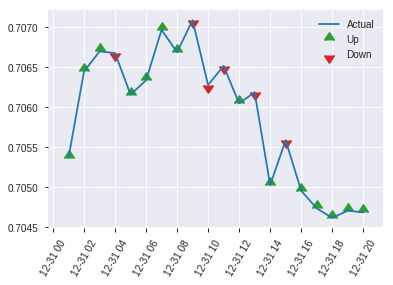


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2048801513496242
RMSE: 0.45263688686365827
LogLoss: 0.6017638680291122
Mean Per-Class Error: 0.309689800210305
AUC: 0.7554994742376446
pr_auc: 0.7220749922108777
Gini: 0.5109989484752893
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3412068219574874: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      149  168  0.53     (168.0/317.0)
1      36   264  0.12     (36.0/300.0)
Total  185  432  0.3306   (204.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.341207     0.721311  267
max f2                       0.209277     0.842014  328
max f0point5                 0.47199      0.682566  166
max accuracy                 0.387671     0.687196  232
max precision                0.950229     1         0
max recall                   0.0123967    1         394
max specificity              0.950229     1         0
max absolute_mcc             0.387671     0.389636  232
max min_per_class_accuracy   0.433454     0.666667  200
max mean_per_class_accuracy  0.387671     0.69031   232

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 42.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.923516           1.46905   1.46905            0.714286         0.934511   0.714286                    0.934511            0.0166667       0.0166667                  46.9048   46.9048
    2        0.0210697                   0.905654           1.71389   1.58205            0.833333         0.916696   0.769231                    0.926289            0.0166667       0.0333333                  71.3889   58.2051
    3        0.0307942                   0.890646           1.71389   1.62368            0.833333         0.899128   0.789474                    0.917711            0.0166667       0.05                       71.3889   62.3684
    4        0.0405186                   0.863142           2.05667   1.7276             1                0.879379   0.84                        0.908512            0.02            0.07                       105.667   72.76
    5        0.0502431                   0.830367           1.71389   1.72495            0.833333         0.846479   0.83871                     0.896505            0.0166667       0.0866667                  71.3889   72.4946
    6        0.100486                    0.699541           1.92398   1.82446            0.935484         0.759383   0.887097                    0.827944            0.0966667       0.183333                   92.3978   82.4462
    7        0.150729                    0.64178            1.6586    1.76918            0.806452         0.67232    0.860215                    0.776069            0.0833333       0.266667                   65.8602   76.9176
    8        0.200972                    0.582288           1.26054   1.64202            0.612903         0.612056   0.798387                    0.735066            0.0633333       0.33                       26.0538   64.2016
    9        0.299838                    0.504509           1.2812    1.52305            0.622951         0.53374    0.740541                    0.668683            0.126667        0.456667                   28.1202   52.3045
    10       0.400324                    0.462861           1.19419   1.4405             0.580645         0.481739   0.700405                    0.621758            0.12            0.576667                   19.4194   44.0499
    11       0.50081                     0.430242           0.961989  1.34449            0.467742         0.446901   0.653722                    0.586673            0.0966667       0.673333                   -3.80108  34.4488
    12       0.599676                    0.388132           1.18005   1.31738            0.57377          0.410785   0.640541                    0.557676            0.116667        0.79                       18.0055   31.7378
    13       0.700162                    0.340884           0.895645  1.25685            0.435484         0.365524   0.611111                    0.530098            0.09            0.88                       -10.4355  25.6852
    14       0.799028                    0.269882           0.674317  1.18477            0.327869         0.312548   0.576065                    0.50318             0.0666667       0.946667                   -32.5683  18.4773
    15       0.899514                    0.128067           0.298548  1.08577            0.145161         0.211342   0.527928                    0.470578            0.03            0.976667                   -70.1452  8.57718
    16       1                           0.00478151         0.232204  1                  0.112903         0.0519932  0.486224                    0

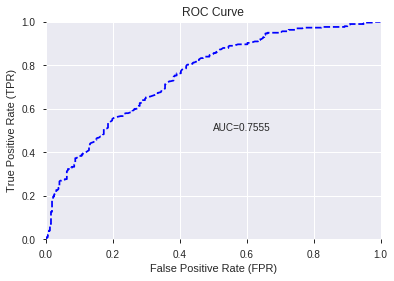

This function is available for GLM models only


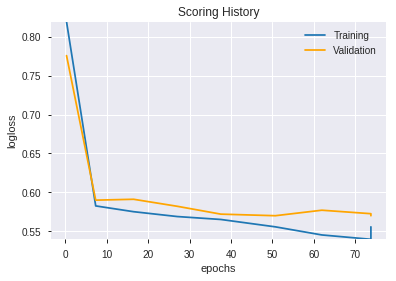

--2019-08-24 13:22:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.137.76
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.137.76|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_130122_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_130122_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_b8e3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'BOP',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'CDLLONGLINE',
 'CDLTAKURI',
 'CDLHANGINGMAN',
 'CDLDRAGONFLYDOJI',
 'CDLHAMMER',
 'DIV',
 'TRANGE',
 'SUB',
 'CDLENGULFING',
 'CDLGRAVESTONEDOJI',
 'hour',
 'Volume',
 'STOCHRSI_fastk',
 'HT_TRENDMODE',
 'aroondown_12',
 'CORREL_20',
 'days_in_month',
 'STOCHF_fastk',
 'MINUS_DI_8',
 'MFI_14',
 'CCI_8',
 'AD',
 'ULTOSC',
 'CDLBELTHOLD',
 'STDDEV_30',
 'BETA_24',
 'aroonup_8',
 'PLUS_DM_8',
 'SAREXT',
 'HT_PHASOR_quadrature',
 'WILLR_8',
 'PLUS_DI_8',
 'ADOSC',
 'MFI_8',
 'weekofyear',
 'BETA_20',
 'week',
 'dayofyear',
 'month',
 'WILLR_12',
 'STOCH_slowd',
 'WILLR_14',
 'WILLR_24',
 'WILLR_20',
 'CMO_8',
 'RSI_8']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_132330_model_1  0.752045  0.614466              0.339685  0.458984  0.210666

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.723336           1.000000    0.138234
1     CDLCLOSINGMARUBOZU             0.304487           0.420948    0.058190
2                  CCI_8             0.300520           0.415464    0.057431
3                WILLR_8             0.297131           0.410778    0.056784
4                 TRANGE             0.230162           0.318194    0.043985
5                 ULTOSC             0.228235           0.315531    0.043617
6            STOCH_slowd             0.208517           0.288271    0.039849
7                    SUB             0.168145           0.232458    0.032134
8              CDLTAKURI             0.165934           0.229401    0.031711
9           STOCHF_fastk             0.146604           0.202677    0.028017
10             CDLHAMMER             0.142401           0.196866    0.027214
11            MINUS_DI_8             0.142159           0.196532    0.027167
12             STDDEV_30             0.140583           0.194353    0.026866
13           CDLBELTHOLD             0.140376           0.194068    0.026827
14             PLUS_DI_8             0.101099           0.139768    0.019321
15          aroondown_12             0.099019           0.136892    0.018923
16     CDLGRAVESTONEDOJI             0.096766           0.133777    0.018493
17           CDLMARUBOZU             0.089954           0.124360    0.017191
18              WILLR_12             0.085560           0.118285    0.016351
19                 MFI_8             0.084360           0.116626    0.016122
20                 RSI_8             0.081278           0.112366    0.015533
21               BETA_24             0.079780           0.110294    0.015246
22              WILLR_24             0.079102           0.109357    0.015117
23                 CMO_8             0.078612           0.108679    0.015023
24                   DIV             0.078166           0.108063    0.014938
25                Volume             0.075423           0.104272    0.014414
26      CDLDRAGONFLYDOJI             0.073879           0.102136    0.014119
27         CDLHANGINGMAN             0.070788           0.097864    0.013528
28           CDLLONGLINE             0.068209           0.094297    0.013035
29         days_in_month             0.067367           0.093134    0.012874
30          HT_TRENDMODE             0.064206           0.088764    0.012270
31              WILLR_14             0.057411           0.079369    0.010972
32             CORREL_20             0.054663           0.075571    0.010447
33             dayofyear             0.052701           0.072858    0.010071
34             aroonup_8             0.051236           0.070833    0.009792
35                 ADOSC             0.043020           0.059474    0.008221
36                  week             0.042017           0.058088    0.008030
37            weekofyear             0.040710           0.056281    0.007780
38                MFI_14             0.031448           0.043476    0.006010
39  HT_PHASOR_quadrature             0.025984           0.035922    0.004966
40        STOCHRSI_fastk             0.025788           0.035652    0.004928
41                 month             0.023639           0.032681    0.004518
42              WILLR_20             0.015879           0.021952    0.003034
43                    AD             0.014635           0.020232    0.002797
44          CDLSHORTLINE             0.011633           0.016082    0.002223
45             PLUS_DM_8             0.008822           0.012196    0.001686
46               BETA_20             0.007866           0.010875    0.001503
47          CDLENGULFING             0.007544           0.010429    0.001442
48                SAREXT             0.003535           0.004887    0.000676
49                  hour             0.001991           0.002753    0.000381

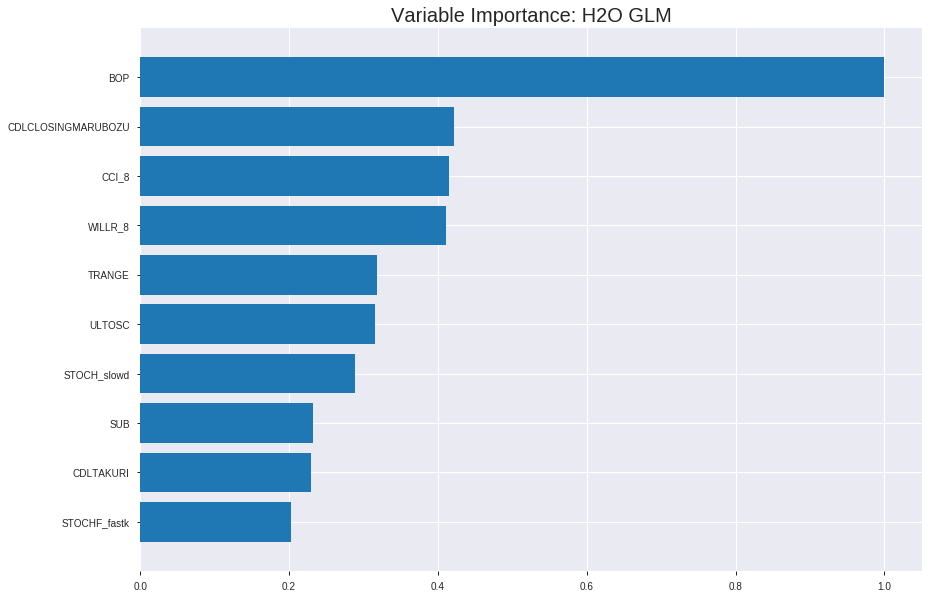

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_132330_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19260484017882867
RMSE: 0.43886767957874123
LogLoss: 0.5658620044882201
Null degrees of freedom: 4314
Residual degrees of freedom: 4264
Null deviance: 5970.536326910041
Residual deviance: 4883.38909873334
AIC: 4985.38909873334
AUC: 0.7754262916695744
pr_auc: 0.7416919792440291
Gini: 0.5508525833391489
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32165738634550833: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1043  1225  0.5401   (1225.0/2268.0)
1      213   1834  0.1041   (213.0/2047.0)
Total  1256  3059  0.3333   (1438.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.321657     0.718371  274
max f2                       0.155079     0.835272  348
max f0point5                 0.529377     0.695748  174
max accuracy                 0.529377     0.706373  174
max precision                0.95013      1         0
max recall                   0.0323826    1         393
max specificity              0.95013      1         0
max absolute_mcc             0.529377     0.410141  174
max min_per_class_accuracy   0.48569      0.699735  195
max mean_per_class_accuracy  0.475219     0.704931  200

Gains/Lift Table: Avg response rate: 47.44 %, avg score: 47.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.915823           1.96424   1.96424            0.931818         0.927447   0.931818                    0.927447            0.0200293       0.0200293                  96.4238   96.4238
    2        0.0201622                   0.89487            1.81383   1.8899             0.860465         0.904429   0.896552                    0.91607             0.0180752       0.0381045                  81.3829   88.9898
    3        0.0301275                   0.880301           1.86285   1.88095            0.883721         0.88816    0.892308                    0.906838            0.0185638       0.0566683                  86.2851   88.0951
    4        0.0400927                   0.868015           1.71578   1.8399             0.813953         0.874361   0.872832                    0.898766            0.0170982       0.0737665                  71.5784   83.9898
    5        0.0500579                   0.858881           1.76481   1.82495            0.837209         0.86366    0.865741                    0.891777            0.0175867       0.0913532                  76.4806   82.4949
    6        0.100116                    0.789763           1.84447   1.83471            0.875            0.824138   0.87037                     0.857958            0.0923302       0.183683                   84.4468   83.4708
    7        0.150174                    0.735137           1.52242   1.73061            0.722222         0.762132   0.820988                    0.826016            0.0762091       0.259893                   52.2418   73.0611
    8        0.2                         0.696733           1.54911   1.68539            0.734884         0.717321   0.799537                    0.798936            0.0771861       0.337079                   54.9108   68.5393
    9        0.300116                    0.628122           1.41019   1.59359            0.668981         0.661718   0.755985                    0.753162            0.141182        0.478261                   41.0188   59.3587
    10       0.4                         0.551192           1.25206   1.5083             0.593968         0.589684   0.715527                    0.71234             0.125061        0.603322                   25.2061   50.8305
    11       0.500116                    0.478422           1.08326   1.42322            0.513889         0.515137   0.675162                    0.672862            0.108451        0.711773                   8.32587   42.3217
    12       0.6                         0.393784           0.919483  1.33936            0.436195         0.437401   0.63538                     0.633664            0.0918417       0.803615                   -8.05174  33.9358
    13       0.699884                    0.327625           0.831447  1.26687            0.394432         0.36132    0.600993                    0.594797            0.0830484       0.886663                   -16.8553  26.6872
    14       0.8                         0.255725           0.575786  1.18039            0.273148         0.29108    0.559965                    0.556788            0.0576453       0.944309                   -42.4214  18.0386
    15       0.899884                    0.144451           0.386378  1.09225            0.183295         0.205298   0.518156                    0.517774            0.0385931       0.982902                   -61.3622  9.22537
    16       1                           0.00179281         0.170784  1                  0.0810185        0.0844542  0.474392                   



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19480862558096926
RMSE: 0.44137130126569085
LogLoss: 0.5732977870122756
Null degrees of freedom: 1232
Residual degrees of freedom: 1182
Null deviance: 1711.616831684033
Residual deviance: 1413.7523427722717
AIC: 1515.7523427722717
AUC: 0.7887183859050867
pr_auc: 0.7767882583025493
Gini: 0.5774367718101734
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26882885292617636: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      302  319  0.5137   (319.0/621.0)
1      72   540  0.1176   (72.0/612.0)
Total  374  859  0.3171   (391.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.268829     0.734194  281
max f2                       0.0622139    0.840915  376
max f0point5                 0.492745     0.731279  174
max accuracy                 0.422593     0.723439  208
max precision                0.921277     1         0
max recall                   0.0277246    1         392
max specificity              0.921277     1         0
max absolute_mcc             0.422593     0.446837  208
max min_per_class_accuracy   0.41944      0.71732   210
max mean_per_class_accuracy  0.422593     0.723371  208

Gains/Lift Table: Avg response rate: 49.64 %, avg score: 41.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.871752           1.70475   1.70475            0.846154         0.896135  0.846154                    0.896135            0.0179739       0.0179739                  70.4751   70.4751
    2        0.0202758                   0.858757           1.84681   1.77294            0.916667         0.86429   0.88                        0.88085             0.0179739       0.0359477                  84.6814   77.2941
    3        0.0300081                   0.834012           2.01471   1.85135            1                0.848046  0.918919                    0.870211            0.0196078       0.0555556                  101.471   85.1351
    4        0.0405515                   0.824534           2.01471   1.89382            1                0.828671  0.94                        0.85941             0.0212418       0.0767974                  101.471   89.3824
    5        0.0502839                   0.800687           2.01471   1.91722            1                0.811083  0.951613                    0.850057            0.0196078       0.0964052                  101.471   91.722
    6        0.100568                    0.718517           1.81973   1.86848            0.903226         0.753908  0.927419                    0.801983            0.0915033       0.187908                   81.9734   86.8477
    7        0.150041                    0.655754           1.48626   1.74245            0.737705         0.684073  0.864865                    0.763104            0.0735294       0.261438                   48.6258   74.2448
    8        0.200324                    0.618761           1.55977   1.69659            0.774194         0.638042  0.842105                    0.731712            0.0784314       0.339869                   55.9772   69.6594
    9        0.300081                    0.556728           1.42504   1.60632            0.707317         0.587802  0.797297                    0.683872            0.142157        0.482026                   42.5036   60.632
    10       0.399838                    0.488266           1.35952   1.54474            0.674797         0.524585  0.766734                    0.644131            0.135621        0.617647                   35.9517   54.4744
    11       0.500406                    0.412285           1.00735   1.43674            0.5              0.452948  0.713128                    0.605708            0.101307        0.718954                   0.735294  43.6743
    12       0.600162                    0.336693           0.851746  1.33951            0.422764         0.370061  0.664865                    0.56654             0.0849673       0.803922                   -14.8254  33.9507
    13       0.699919                    0.266586           0.802606  1.26298            0.398374         0.299015  0.626883                    0.52841             0.0800654       0.883987                   -19.7394  26.2985
    14       0.799676                    0.206116           0.58967   1.17899            0.292683         0.237912  0.585193                    0.492172            0.0588235       0.94281                    -41.033   17.8991
    15       0.899432                    0.125273           0.327594  1.08456            0.162602         0.16884   0.538323                    0.456311            0.0326797       0.97549                    -67.2406  8.45621
    16       1                           0.00426334         0.243714  1                  0.120968         0.069336  0.49635                     0.417394           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-24 13:23:31  0.000 sec   2            .2E2      50            1.3629518349190108  1.3680523096379398
     2019-08-24 13:23:31  0.067 sec   4            .12E2     51            1.3527191970256138  1.3580262824585247
     2019-08-24 13:23:31  0.117 sec   6            .76E1     51            1.3388011742434103  1.3442845992421333
     2019-08-24 13:23:31  0.170 sec   8            .47E1     51            1.320916398340153   1.326474638703203
     2019-08-24 13:23:31  0.218 sec   10           .29E1     51            1.29925325260136    1.3046739913481935
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-24 13:23:32  0.797 sec   39           .23E-2    51            1.1314137848496952  1.1467290730600062
     2019-08-24 13:23:32  0.823 sec   40           .14E-2    51            1.131227560177281   1.1471511331639273
     2019-08-24 13:23:32  0.838 sec   41           .9E-3     51            1.1311005396921148  1.1477330507879462
     2019-08-24 13:23:32  0.853 sec   42           .56E-3    51            1.1309975257769527  1.1485382866495046
     2019-08-24 13:23:32  0.871 sec   43           .35E-3    51            1.1309078123180871  1.1494814364037527


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6839546191247974)

('F1', 0.720626631853786)

('auc', 0.7520452155625658)

('logloss', 0.6144657996908958)

('mean_per_class_error', 0.31543638275499475)

('rmse', 0.45898375875433145)

('mse', 0.21066609080025434)

glm prediction progress: |████████████████████████████████████████████████| 100%


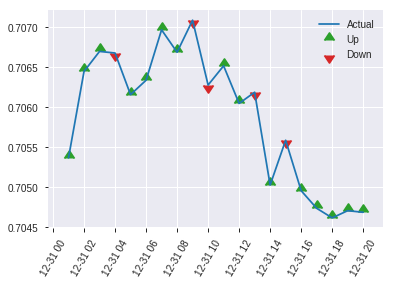


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21066609080025434
RMSE: 0.45898375875433145
LogLoss: 0.6144657996908958
Null degrees of freedom: 616
Residual degrees of freedom: 566
Null deviance: 855.2213378304502
Residual deviance: 758.2507968185653
AIC: 860.2507968185653
AUC: 0.7520452155625658
pr_auc: 0.7346455065543475
Gini: 0.5040904311251315
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21170554748366857: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      127  190  0.5994   (190.0/317.0)
1      24   276  0.08     (24.0/300.0)
Total  151  466  0.3468   (214.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.211706     0.720627  302
max f2                       0.0766155    0.837104  366
max f0point5                 0.526344     0.682271  124
max accuracy                 0.372963     0.683955  207
max precision                0.935338     1         0
max recall                   0.00339208   1         399
max specificity              0.935338     1         0
max absolute_mcc             0.211706     0.372747  302
max min_per_class_accuracy   0.378889     0.675079  203
max mean_per_class_accuracy  0.36808      0.684564  211

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 39.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.883167           1.76286   1.76286            0.857143         0.899742   0.857143                    0.899742            0.02            0.02                       76.2857   76.2857
    2        0.0210697                   0.85657            2.05667   1.89846            1                0.869129   0.923077                    0.885613            0.02            0.04                       105.667   89.8462
    3        0.0307942                   0.832651           2.05667   1.94842            1                0.84331    0.947368                    0.872254            0.02            0.06                       105.667   94.8421
    4        0.0405186                   0.815329           1.02833   1.7276             0.5              0.822717   0.84                        0.860366            0.01            0.07                       2.83333   72.76
    5        0.0502431                   0.798467           2.05667   1.79129            1                0.807964   0.870968                    0.850223            0.02            0.09                       105.667   79.129
    6        0.100486                    0.700854           1.85763   1.82446            0.903226         0.741499   0.887097                    0.795861            0.0933333       0.183333                   85.7634   82.4462
    7        0.150729                    0.627069           1.52591   1.72495            0.741935         0.666848   0.83871                     0.752857            0.0766667       0.26                       52.5914   72.4946
    8        0.200972                    0.587217           1.59226   1.69177            0.774194         0.607904   0.822581                    0.716618            0.08            0.34                       59.2258   69.1774
    9        0.299838                    0.516885           1.31492   1.56751            0.639344         0.546119   0.762162                    0.6604              0.13            0.47                       31.4918   56.7514
    10       0.400324                    0.4513             0.928817  1.40719            0.451613         0.480478   0.684211                    0.615237            0.0933333       0.563333                   -7.11828  40.7193
    11       0.50081                     0.377222           1.19419   1.36446            0.580645         0.413794   0.66343                     0.574818            0.12            0.683333                   19.4194   36.4455
    12       0.599676                    0.315939           0.876612  1.28403            0.42623          0.349903   0.624324                    0.537738            0.0866667       0.77                       -12.3388  28.4027
    13       0.700162                    0.246568           1.02833   1.24733            0.5              0.282396   0.606481                    0.501091            0.103333        0.873333                   2.83333   24.733
    14       0.799028                    0.178251           0.674317  1.17643            0.327869         0.214932   0.572008                    0.465684            0.0666667       0.94                       -32.5683  17.643
    15       0.899514                    0.0910026          0.33172   1.08207            0.16129          0.135399   0.526126                    0.428787            0.0333333       0.973333                   -66.828   8.20661
    16       1                           0.00339208         0.265376  1                  0.129032         0.0516594  0.486224                    0.39

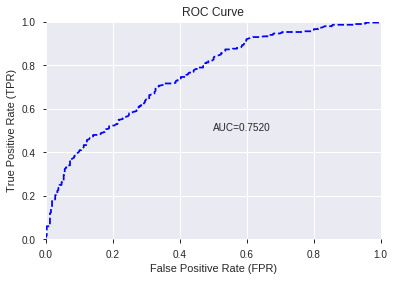

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


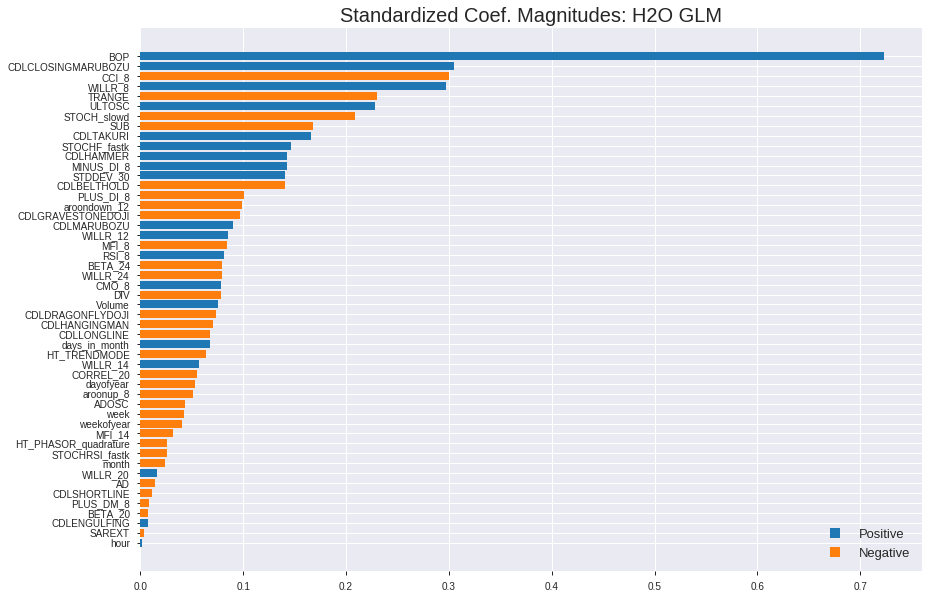

'log_likelihood'
--2019-08-24 13:23:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.238.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.238.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_132330_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_132330_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_b8e3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CCI_8',
 'WILLR_8',
 'TRANGE',
 'ULTOSC',
 'STOCH_slowd',
 'SUB',
 'CDLTAKURI',
 'STOCHF_fastk',
 'CDLHAMMER',
 'MINUS_DI_8',
 'STDDEV_30',
 'CDLBELTHOLD',
 'PLUS_DI_8',
 'aroondown_12',
 'CDLGRAVESTONEDOJI',
 'CDLMARUBOZU',
 'WILLR_12',
 'MFI_8',
 'RSI_8',
 'BETA_24',
 'WILLR_24',
 'CMO_8',
 'DIV',
 'Volume',
 'CDLDRAGONFLYDOJI',
 'CDLHANGINGMAN',
 'CDLLONGLINE',
 'days_in_month',
 'HT_TRENDMODE',
 'WILLR_14',
 'CORREL_20',
 'dayofyear',
 'aroonup_8',
 'ADOSC',
 'week',
 'weekofyear',
 'MFI_14',
 'HT_PHASOR_quadrature',
 'STOCHRSI_fastk',
 'month',
 'WILLR_20',
 'AD',
 'CDLSHORTLINE',
 'PLUS_DM_8',
 'BETA_20',
 'CDLENGULFING',
 'SAREXT',
 'hour']

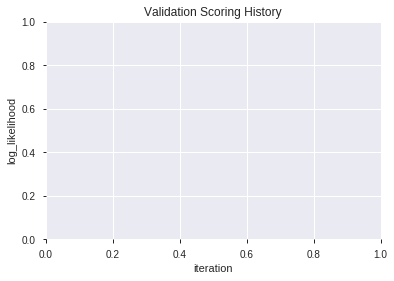

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_132438_model_2  0.751267  0.589369              0.318586  0.450746  0.203172
1  XGBoost_grid_1_AutoML_20190824_132438_model_6  0.748165  0.590637              0.330936  0.451292  0.203664
2               XGBoost_3_AutoML_20190824_132438  0.746283  0.591491              0.319033  0.451995  0.204299
3  XGBoost_grid_1_AutoML_20190824_132438_model_3  0.746099  0.591277              0.317723  0.451766  0.204092
4  XGBoost_grid_1_AutoML_20190824_132438_model_4  0.745252  0.591743              0.351230  0.452517  0.204772
5  XGBoost_grid_1_AutoML_20190824_132438_model_1  0.742003  0.597108              0.322902  0.454725  0.206775
6               XGBoost_1_AutoML_20190824_132438  0.738922  0.598030              0.350279  0.455057  0.207077
7               XGBoost_2_AutoML_20190824_132438  0.735762  0.599214              0.357629  0.456285  0.208196
8  XGBoost_grid_1_AutoML_20190824_132438_model_7  0.731761  0.606932              0.352213  0.458628  0.210340
9  XGBoost_grid_1_AutoML_20190824_132438_model_5  0.728917  0.612125              0.352839  0.461231  0.212734

variable  relative_importance  scaled_importance  percentage
0                    BOP          5925.828125           1.000000    0.335784
1           STOCHF_fastk          1059.802612           0.178845    0.060053
2                    DIV          1025.320923           0.173026    0.058099
3                   hour           634.000244           0.106989    0.035925
4     CDLCLOSINGMARUBOZU           601.832703           0.101561    0.034103
5                  CCI_8           543.124329           0.091654    0.030776
6              STDDEV_30           503.384766           0.084948    0.028524
7                 TRANGE           483.560608           0.081602    0.027401
8         STOCHRSI_fastk           483.149933           0.081533    0.027377
9              aroonup_8           427.676422           0.072172    0.024234
10            MINUS_DI_8           378.921234           0.063944    0.021471
11               WILLR_8           333.024719           0.056199    0.018871
12                    AD           327.879944           0.055331    0.018579
13               BETA_20           310.427094           0.052385    0.017590
14             dayofyear           308.864532           0.052122    0.017502
15             PLUS_DM_8           307.857971           0.051952    0.017445
16                SAREXT           303.947144           0.051292    0.017223
17                Volume           259.196594           0.043740    0.014687
18             CDLHAMMER           248.976517           0.042015    0.014108
19               BETA_24           241.732422           0.040793    0.013698
20  HT_PHASOR_quadrature           240.543549           0.040592    0.013630
21                 MFI_8           221.623001           0.037399    0.012558
22                ULTOSC           218.675629           0.036902    0.012391
23                 ADOSC           213.454681           0.036021    0.012095
24           STOCH_slowd           202.203384           0.034122    0.011458
25             PLUS_DI_8           200.511063           0.033837    0.011362
26          aroondown_12           196.292358           0.033125    0.011123
27                 CMO_8           189.374802           0.031958    0.010731
28              WILLR_12           177.072693           0.029882    0.010034
29              WILLR_14           157.599899           0.026595    0.008930
30                MFI_14           153.311844           0.025872    0.008687
31              WILLR_20           148.760498           0.025104    0.008429
32                   SUB           120.681793           0.020365    0.006838
33              WILLR_24            98.405273           0.016606    0.005576
34          CDLSHORTLINE            94.926643           0.016019    0.005379
35     CDLGRAVESTONEDOJI            92.065186           0.015536    0.005217
36             CDLTAKURI            41.636551           0.007026    0.002359
37             CORREL_20            36.726868           0.006198    0.002081
38           CDLBELTHOLD            34.010742           0.005739    0.001927
39                 RSI_8            19.551460           0.003299    0.001108
40          CDLENGULFING            16.433407           0.002773    0.000931
41         days_in_month            16.284660           0.002748    0.000923
42          HT_TRENDMODE            12.177052           0.002055    0.000690
43           CDLLONGLINE            11.349426           0.001915    0.000643
44                  week            10.305758           0.001739    0.000584
45      CDLDRAGONFLYDOJI             8.816990           0.001488    0.000500
46                 month             4.095464           0.000691    0.000232
47            weekofyear             2.325195           0.000392    0.000132

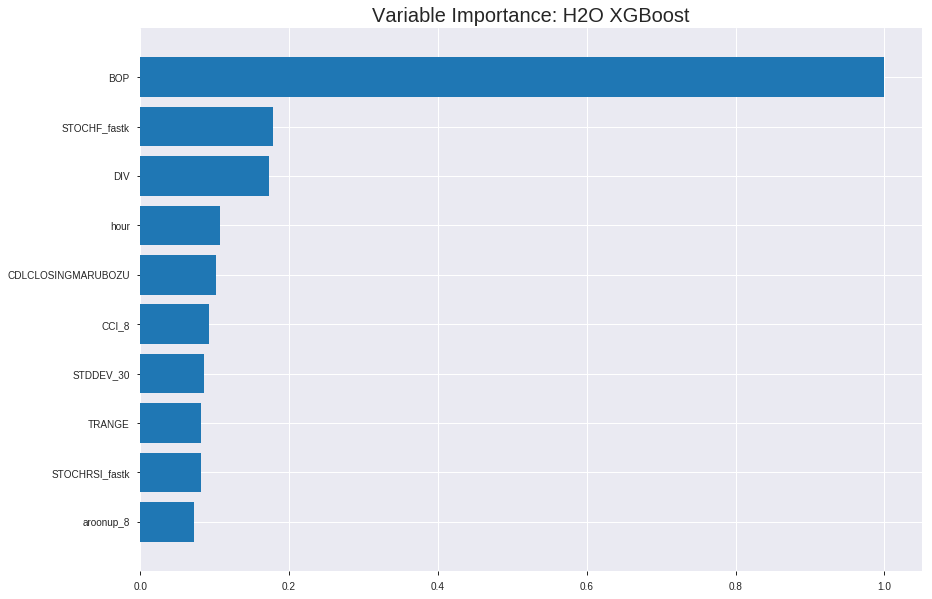

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_132438_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16222191185726118
RMSE: 0.40276781382983073
LogLoss: 0.49515042770427
Mean Per-Class Error: 0.23426688430352327
AUC: 0.8561661406678505
pr_auc: 0.8457254907051983
Gini: 0.7123322813357009
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41120289638638496: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1429  839   0.3699   (839.0/2268.0)
1      242   1805  0.1182   (242.0/2047.0)
Total  1671  2644  0.2505   (1081.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411203     0.769559  236
max f2                       0.20919      0.857228  326
max f0point5                 0.590843     0.775194  144
max accuracy                 0.497287     0.765469  192
max precision                0.935491     1         0
max recall                   0.0906596    1         384
max specificity              0.935491     1         0
max absolute_mcc             0.453724     0.532784  215
max min_per_class_accuracy   0.501009     0.764109  190
max mean_per_class_accuracy  0.497287     0.765733  192

Gains/Lift Table: Avg response rate: 47.44 %, avg score: 47.37 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.908307           2.10796    2.10796            1                0.918272  1                           0.918272            0.0214949       0.0214949                  110.796   110.796
    2        0.0201622                   0.88413            2.10796    2.10796            1                0.897165  1                           0.90784             0.0210064       0.0425012                  110.796   110.796
    3        0.0301275                   0.856608           2.10796    2.10796            1                0.870226  1                           0.895398            0.0210064       0.0635076                  110.796   110.796
    4        0.0400927                   0.841454           2.10796    2.10796            1                0.84886   1                           0.883831            0.0210064       0.0845139                  110.796   110.796
    5        0.0500579                   0.82205            1.9609     2.07869            0.930233         0.831413  0.986111                    0.873396            0.0195408       0.104055                   96.0896   107.869
    6        0.100116                    0.760681           2.02013    2.04941            0.958333         0.790321  0.972222                    0.831858            0.101124        0.205178                   102.013   104.941
    7        0.150174                    0.720007           1.87374    1.99085            0.888889         0.738933  0.944444                    0.800883            0.0937958       0.298974                   87.3745   99.0854
    8        0.2                         0.686572           1.73539    1.92721            0.823256         0.702448  0.914253                    0.77636             0.086468        0.385442                   73.5393   92.7211
    9        0.300116                    0.621468           1.58097    1.81171            0.75             0.653537  0.859459                    0.735387            0.15828         0.543723                   58.0972   81.1709
    10       0.4                         0.562618           1.24228    1.66952            0.589327         0.592163  0.792005                    0.699623            0.124084        0.667807                   24.228    66.9516
    11       0.500116                    0.48991            1.09302    1.55411            0.518519         0.527577  0.737257                    0.665182            0.109428        0.777235                   9.30178   55.411
    12       0.6                         0.419587           0.924374   1.44928            0.438515         0.455293  0.687524                    0.630241            0.0923302       0.869565                   -7.56265  44.9275
    13       0.699884                    0.335175           0.635812   1.33318            0.301624         0.378689  0.63245                     0.594341            0.0635076       0.933073                   -36.4188  33.3182
    14       0.8                         0.231629           0.400123   1.21641            0.189815         0.286419  0.577057                    0.555806            0.0400586       0.973131                   -59.9877  21.6414
    15       0.899884                    0.141964           0.249434   1.10908            0.118329         0.185362  0.52614                     0.514688            0.0249145       0.998046                   -75.0566  10.9083
    16       1                           0.050306           0.0195182  1                  0.00925926       0.105166  0.474392                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.18760225784381396
RMSE: 0.4331307629848219
LogLoss: 0.5563466849039489
Mean Per-Class Error: 0.25959079283887476
AUC: 0.7960213339227263
pr_auc: 0.7781634874068072
Gini: 0.5920426678454527
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44644027203321457: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      418  203  0.3269   (203.0/621.0)
1      127  485  0.2075   (127.0/612.0)
Total  545  688  0.2676   (330.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.44644      0.746154  222
max f2                       0.183136     0.847771  349
max f0point5                 0.501982     0.740988  192
max accuracy                 0.501982     0.74047   192
max precision                0.922308     1         0
max recall                   0.0878116    1         389
max specificity              0.922308     1         0
max absolute_mcc             0.501982     0.480977  192
max min_per_class_accuracy   0.488034     0.736928  199
max mean_per_class_accuracy  0.495324     0.740409  195

Gains/Lift Table: Avg response rate: 49.64 %, avg score: 46.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.898482           1.85973   1.85973            0.923077         0.908584  0.923077                    0.908584            0.0196078       0.0196078                  85.9729   85.9729
    2        0.0202758                   0.869635           1.67892   1.77294            0.833333         0.887255  0.88                        0.898346            0.0163399       0.0359477                  67.8922   77.2941
    3        0.0300081                   0.842595           2.01471   1.85135            1                0.859836  0.918919                    0.885856            0.0196078       0.0555556                  101.471   85.1351
    4        0.0405515                   0.828815           1.85973   1.85353            0.923077         0.835823  0.92                        0.872847            0.0196078       0.0751634                  85.9729   85.3529
    5        0.0502839                   0.807921           2.01471   1.88472            1                0.816355  0.935484                    0.861913            0.0196078       0.0947712                  101.471   88.4725
    6        0.100568                    0.723639           1.65726   1.77099            0.822581         0.761532  0.879032                    0.811723            0.0833333       0.178105                   65.7258   77.0991
    7        0.150041                    0.684996           1.75048   1.76423            0.868852         0.701888  0.875676                    0.775507            0.0866013       0.264706                   75.0482   76.4229
    8        0.200324                    0.655125           1.49478   1.69659            0.741935         0.669828  0.842105                    0.74898             0.0751634       0.339869                   49.4782   69.6594
    9        0.300081                    0.605105           1.35952   1.58454            0.674797         0.629508  0.786486                    0.709264            0.135621        0.47549                    35.9517   58.4539
    10       0.399838                    0.551546           1.40866   1.54066            0.699187         0.577287  0.764706                    0.676337            0.140523        0.616013                   40.8656   54.0657
    11       0.500406                    0.485823           1.23482   1.47919            0.612903         0.521988  0.734198                    0.645317            0.124183        0.740196                   23.482    47.9192
    12       0.600162                    0.415973           0.786227  1.36401            0.390244         0.449314  0.677027                    0.612738            0.0784314       0.818627                   -21.3773  36.401
    13       0.699919                    0.339241           0.60605   1.25598            0.300813         0.381453  0.623407                    0.579774            0.0604575       0.879085                   -39.395   25.5981
    14       0.799676                    0.245254           0.687948  1.18512            0.341463         0.299564  0.588235                    0.544819            0.0686275       0.947712                   -31.2052  18.5121
    15       0.899432                    0.154026           0.343974  1.09183            0.170732         0.20172   0.54193                     0.506765            0.0343137       0.982026                   -65.6026  9.18289
    16       1                           0.0612598          0.178724  1                  0.0887097        0.110569  0.49635                     0.466921          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 13:24:59  1.685 sec   0                  0.5              0.693147            0.5             0                  1                0.525608                         0.5                0.693147              0.5               0                    1                  0.50365
    2019-08-24 13:24:59  1.796 sec   5                  0.479501         0.652785            0.794558        0.726948           1.93588          0.285747                         0.482273           0.658149              0.773798          0.729262             1.77294            0.293593
    2019-08-24 13:24:59  1.885 sec   10                 0.464362         0.623312            0.799246        0.741007           2.02013          0.282039                         0.46959            0.63329               0.77758           0.7357               1.81324            0.289538
    2019-08-24 13:24:59  1.963 sec   15                 0.452948         0.600833            0.802819        0.751865           2.00078          0.276477                         0.459762           0.61385               0.781915          0.750685             1.8708             0.286294
    2019-08-24 13:24:59  2.073 sec   20                 0.444842         0.584444            0.806582        0.764648           2.03268          0.276709                         0.4535             0.601056              0.783577          0.760263             1.85973            0.287916
    2019-08-24 13:24:59  2.162 sec   25                 0.438756         0.571751            0.809945        0.773249           2.06112          0.28343                          0.448883           0.591388              0.784562          0.762441             1.85973            0.27575
    2019-08-24 13:24:59  2.244 sec   30                 0.433763         0.561139            0.813834        0.78485            2.10796          0.28482                          0.445927           0.584955              0.785011          0.76934              1.85973            0.288727
    2019-08-24 13:24:59  2.340 sec   35                 0.429651         0.552213            0.817241        0.793774           2.10796          0.281344                         0.443074           0.578724              0.786336          0.770152             1.70475            0.283861
    2019-08-24 13:24:59  2.424 sec   40                 0.426212         0.544651            0.820985        0.800261           2.10796          0.274855                         0.441435           0.574951              0.78665           0.771276             1.72689            0.280616
    2019-08-24 13:24:59  2.515 sec   45                 0.423363         0.538352            0.824128        0.805653           2.10796          0.276246                         0.440097           0.57197               0.787737          0.773211             1.85973            0.278183
    2019-08-24 13:25:00  2.609 sec   50                 0.420312         0.531872            0.828574        0.812798           2.10796          0.271379                         0.438471           0.568631              0.790387          0.774121             1.70475            0.276561
    2019-08-24 13:25:00  2.707 sec   55                 0.418085         0.527042            0.831597        0.816536           2.10796          0.267671                         0.437788           0.566955              0.790996          0.7

Variable Importances: 


variable            relative_importance    scaled_importance       percentage
------------------  ---------------------  ----------------------  ----------------------
BOP                 5925.828125            1.0                     0.3357842568457319
STOCHF_fastk        1059.8026123046875     0.1788446424616285      0.06005321535981855
DIV                 1025.3209228515625     0.17302576133214503     0.058099326684081284
hour                634.000244140625       0.10698930694022196     0.035925324921362335
CDLCLOSINGMARUBOZU  601.8327026367188      0.10156094472225664     0.0341025663481134
---                 ---                    ---                     ---
CDLLONGLINE         11.34942626953125      0.0019152472920451519   0.0006431098886351817
week                10.305757522583008     0.0017391252842965316   0.000583970891149133
CDLDRAGONFLYDOJI    8.81698989868164       0.001487891601426027    0.0004996105756518443
month               4.095463752746582      0.0006911209144707655   0.00023206752265610863
weekofyear          2.3251953125           0.00039238318483967167  0.0001317560961201506


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6952998379254457)

('F1', 0.7260273972602739)

('auc', 0.751267087276551)

('logloss', 0.5893694006967144)

('mean_per_class_error', 0.3040378548895899)

('rmse', 0.4507462807315254)

('mse', 0.2031722095933031)

xgboost prediction progress: |████████████████████████████████████████████| 100%


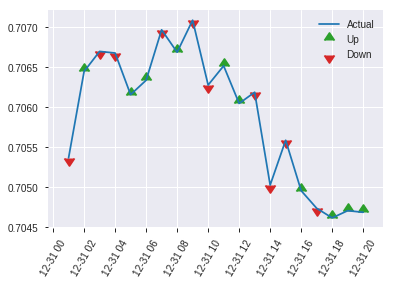


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2031722095933031
RMSE: 0.4507462807315254
LogLoss: 0.5893694006967144
Mean Per-Class Error: 0.3040378548895899
AUC: 0.751267087276551
pr_auc: 0.7248581320396342
Gini: 0.502534174553102
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33562493324279785: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      152  165  0.5205   (165.0/317.0)
1      35   265  0.1167   (35.0/300.0)
Total  187  430  0.3241   (200.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.335625     0.726027  275
max f2                       0.176558     0.848624  352
max f0point5                 0.445584     0.683544  208
max accuracy                 0.445584     0.6953    208
max precision                0.914586     1         0
max recall                   0.0797217    1         395
max specificity              0.914586     1         0
max absolute_mcc             0.361484     0.402318  258
max min_per_class_accuracy   0.459102     0.684543  197
max mean_per_class_accuracy  0.445584     0.695962  208

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 44.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.898714           2.05667   2.05667            1                0.905669  1                           0.905669            0.0233333       0.0233333                  105.667   105.667
    2        0.0210697                   0.867739           1.71389   1.89846            0.833333         0.878745  0.923077                    0.893242            0.0166667       0.04                       71.3889   89.8462
    3        0.0307942                   0.818237           2.05667   1.94842            1                0.843431  0.947368                    0.877512            0.02            0.06                       105.667   94.8421
    4        0.0405186                   0.793297           1.71389   1.89213            0.833333         0.809592  0.92                        0.861212            0.0166667       0.0766667                  71.3889   89.2133
    5        0.0502431                   0.769723           2.05667   1.92398            1                0.781124  0.935484                    0.845711            0.02            0.0966667                  105.667   92.3978
    6        0.100486                    0.680035           1.52591   1.72495            0.741935         0.716626  0.83871                     0.781169            0.0766667       0.173333                   52.5914   72.4946
    7        0.150729                    0.645366           1.52591   1.6586             0.741935         0.665815  0.806452                    0.742717            0.0766667       0.25                       52.5914   65.8602
    8        0.200972                    0.623377           1.32688   1.57567            0.645161         0.633925  0.766129                    0.715519            0.0666667       0.316667                   32.6882   57.5672
    9        0.299838                    0.562295           1.24749   1.46746            0.606557         0.590181  0.713514                    0.674191            0.123333        0.44                       24.7486   46.7459
    10       0.400324                    0.511176           1.19419   1.39887            0.580645         0.535538  0.680162                    0.639388            0.12            0.56                       19.4194   39.8866
    11       0.50081                     0.457881           1.32688   1.38442            0.645161         0.481891  0.673139                    0.607787            0.133333        0.693333                   32.6882   38.4423
    12       0.599676                    0.40013            0.97776   1.31738            0.47541          0.425662  0.640541                    0.577761            0.0966667       0.79                       -2.22404  31.7378
    13       0.700162                    0.331532           0.928817  1.26161            0.451613         0.365468  0.613426                    0.547293            0.0933333       0.883333                   -7.11828  26.1613
    14       0.799028                    0.240239           0.539454  1.17226            0.262295         0.292452  0.56998                     0.515761            0.0533333       0.936667                   -46.0546  17.2258
    15       0.899514                    0.15416            0.497581  1.09689            0.241935         0.192854  0.533333                    0.479688            0.05            0.986667                   -50.2419  9.68889
    16       1                           0.0536425          0.132688  1                  0.0645161        0.11086   0.486224                    0.442626         

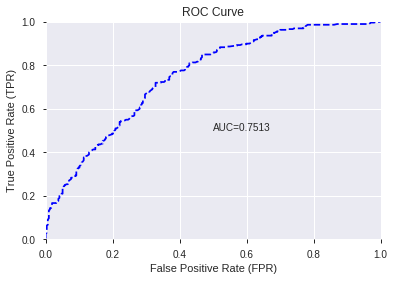

This function is available for GLM models only


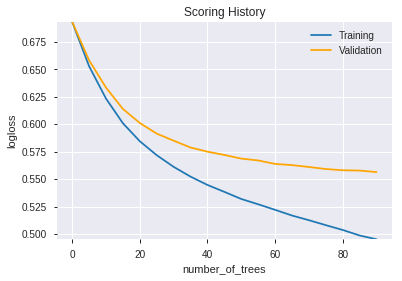

--2019-08-24 13:25:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.17.48
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.17.48|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_132438_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_132438_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_b8e3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'DIV',
 'hour',
 'CDLCLOSINGMARUBOZU',
 'CCI_8',
 'STDDEV_30',
 'TRANGE',
 'STOCHRSI_fastk',
 'aroonup_8',
 'MINUS_DI_8',
 'WILLR_8',
 'AD',
 'BETA_20',
 'dayofyear',
 'PLUS_DM_8',
 'SAREXT',
 'Volume',
 'CDLHAMMER',
 'BETA_24',
 'HT_PHASOR_quadrature',
 'MFI_8',
 'ULTOSC',
 'ADOSC',
 'STOCH_slowd',
 'PLUS_DI_8',
 'aroondown_12',
 'CMO_8',
 'WILLR_12',
 'WILLR_14',
 'MFI_14',
 'WILLR_20',
 'SUB',
 'WILLR_24',
 'CDLSHORTLINE',
 'CDLGRAVESTONEDOJI',
 'CDLTAKURI',
 'CORREL_20',
 'CDLBELTHOLD',
 'RSI_8',
 'CDLENGULFING',
 'days_in_month',
 'HT_TRENDMODE',
 'CDLLONGLINE',
 'week',
 'CDLDRAGONFLYDOJI',
 'month',
 'weekofyear']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_132625_model_1  0.745053  0.629921              0.328586  0.467989  0.219014

variable  relative_importance  scaled_importance    percentage
0                         BOP             0.363790           1.000000  4.264320e-02
1          CDLCLOSINGMARUBOZU             0.232464           0.639005  2.724920e-02
2                   CDLHAMMER             0.115952           0.318734  1.359184e-02
3                      TRANGE             0.113579           0.312210  1.331362e-02
4                STOCHF_fastk             0.112235           0.308517  1.315614e-02
...                       ...                  ...                ...           ...
1035                   MOM_12             0.000009           0.000026  1.096253e-06
1036                 TRIMA_14             0.000009           0.000025  1.075861e-06
1037  BBANDS_lowerband_20_1_2             0.000004           0.000010  4.144455e-07
1038                   TSF_20             0.000003           0.000010  4.078362e-07
1039  BBANDS_lowerband_20_2_3             0.000003           0.000008  3.483231e-07

[1040 rows x 4 columns]

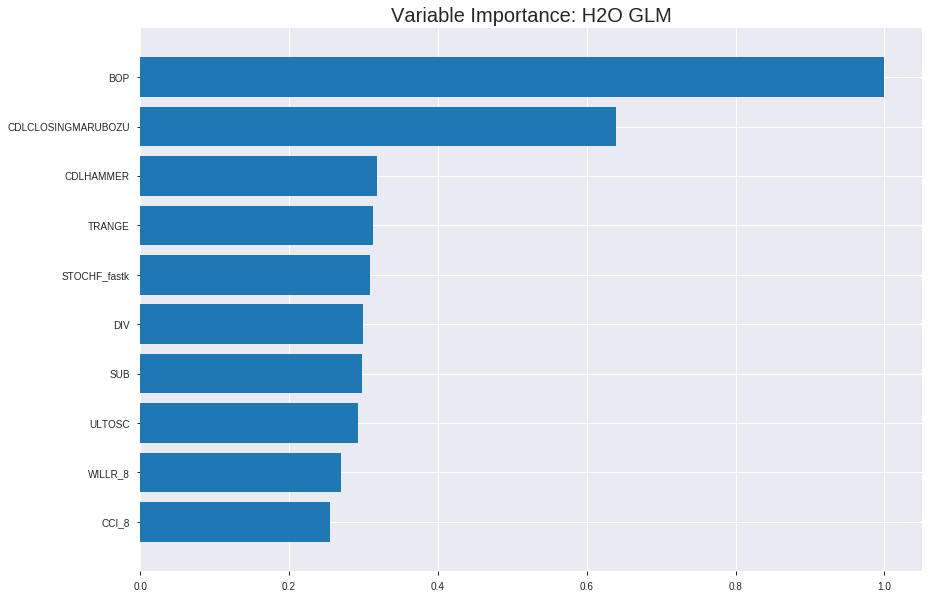

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_132625_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1912325045855229
RMSE: 0.43730138873038454
LogLoss: 0.5635278721661762
Null degrees of freedom: 4314
Residual degrees of freedom: 3274
Null deviance: 5970.536326910041
Residual deviance: 4863.2455367941
AIC: 6945.2455367941
AUC: 0.7819189953207214
pr_auc: 0.7464547257150603
Gini: 0.5638379906414428
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3922403075403603: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1242  1026  0.4524   (1026.0/2268.0)
1      308   1739  0.1505   (308.0/2047.0)
Total  1550  2765  0.3092   (1334.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.39224      0.722776  244
max f2                       0.195082     0.836179  337
max f0point5                 0.53247      0.69645   172
max accuracy                 0.474933     0.706837  202
max precision                0.958638     1         0
max recall                   0.0669076    1         385
max specificity              0.958638     1         0
max absolute_mcc             0.402874     0.4158    238
max min_per_class_accuracy   0.486723     0.705908  195
max mean_per_class_accuracy  0.474933     0.707815  202

Gains/Lift Table: Avg response rate: 47.44 %, avg score: 47.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.885371           1.82051   1.82051            0.863636         0.907552  0.863636                    0.907552            0.0185638       0.0185638                  82.0513   82.0513
    2        0.0201622                   0.861155           1.71578   1.76875            0.813953         0.872967  0.83908                     0.890458            0.0170982       0.0356619                  71.5784   76.875
    3        0.0301275                   0.845045           1.91187   1.81609            0.906977         0.854912  0.861538                    0.878701            0.0190523       0.0547142                  91.1873   81.6091
    4        0.0400927                   0.828965           1.76481   1.80334            0.837209         0.836249  0.855491                    0.868149            0.0175867       0.0723009                  76.4806   80.3344
    5        0.0500579                   0.815654           1.81383   1.80543            0.860465         0.822736  0.856481                    0.859108            0.0180752       0.0903762                  81.3829   80.5431
    6        0.100116                    0.751733           1.8835    1.84447            0.893519         0.78417   0.875                       0.821639            0.0942843       0.18466                    88.3504   84.4468
    7        0.150174                    0.712044           1.74688   1.81194            0.828704         0.731094  0.859568                    0.791458            0.087445        0.272106                   74.6877   81.1937
    8        0.2                         0.673451           1.45106   1.72203            0.688372         0.69262   0.816918                    0.766834            0.0723009       0.344406                   45.1063   72.2032
    9        0.300116                    0.600858           1.42483   1.62289            0.675926         0.636539  0.769884                    0.723369            0.142648        0.487054                   42.4827   62.2887
    10       0.4                         0.540021           1.20315   1.51808            0.570766         0.570805  0.720162                    0.685272            0.120176        0.60723                    20.3153   51.8075
    11       0.500116                    0.479558           1.09302   1.43298            0.518519         0.510036  0.679796                    0.650192            0.109428        0.716659                   9.30178   43.2985
    12       0.6                         0.416521           0.943937  1.35157            0.447796         0.446982  0.641174                    0.616363            0.0942843       0.810943                   -5.6063   35.1571
    13       0.699884                    0.350582           0.782538  1.27036            0.37123          0.384734  0.602649                    0.583306            0.0781632       0.889106                   -21.7462  27.0362
    14       0.8                         0.279745           0.570907  1.18283            0.270833         0.315477  0.561124                    0.549789            0.0571568       0.946263                   -42.9093  18.2829
    15       0.899884                    0.178667           0.381487  1.09388            0.180974         0.231191  0.518929                    0.514426            0.0381045       0.984367                   -61.8513  9.38824
    16       1                           0.00835947         0.156145  1                  0.0740741        0.114549  0.474392                    0.474392          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1985227279813836
RMSE: 0.4455588939538561
LogLoss: 0.5819348069900325
Null degrees of freedom: 1232
Residual degrees of freedom: 192
Null deviance: 1711.616831684033
Residual deviance: 1435.0512340374205
AIC: 3517.0512340374207
AUC: 0.7824850283645396
pr_auc: 0.761933953865452
Gini: 0.5649700567290792
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34275272035865284: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      369  252  0.4058   (252.0/621.0)
1      113  499  0.1846   (113.0/612.0)
Total  482  751  0.296    (365.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.342753     0.732208  249
max f2                       0.131174     0.842414  362
max f0point5                 0.480661     0.727896  178
max accuracy                 0.480661     0.715328  178
max precision                0.710371     0.913462  55
max recall                   0.0652759    1         388
max specificity              0.943329     0.99839   0
max absolute_mcc             0.480661     0.436791  178
max min_per_class_accuracy   0.417911     0.70915   209
max mean_per_class_accuracy  0.480661     0.714668  178

Gains/Lift Table: Avg response rate: 49.64 %, avg score: 42.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.858797           1.3948    1.3948             0.692308         0.887856   0.692308                    0.887856            0.0147059       0.0147059                  39.4796   39.4796
    2        0.0202758                   0.833117           2.01471   1.69235            1                0.842259   0.84                        0.86597             0.0196078       0.0343137                  101.471   69.2353
    3        0.0300081                   0.808626           1.84681   1.74245            0.916667         0.819952   0.864865                    0.851045            0.0179739       0.0522876                  84.6814   74.2448
    4        0.0405515                   0.7829             1.85973   1.77294            0.923077         0.795462   0.88                        0.836593            0.0196078       0.0718954                  85.9729   77.2941
    5        0.0502839                   0.76706            1.84681   1.78724            0.916667         0.773162   0.887097                    0.824316            0.0179739       0.0898693                  84.6814   78.7239
    6        0.100568                    0.68619            1.75474   1.77099            0.870968         0.725085   0.879032                    0.774701            0.0882353       0.178105                   75.4744   77.0991
    7        0.150041                    0.640137           1.78351   1.77512            0.885246         0.663635   0.881081                    0.738079            0.0882353       0.26634                    78.351    77.5119
    8        0.200324                    0.605835           1.46229   1.69659            0.725806         0.62396    0.842105                    0.709434            0.0735294       0.339869                   46.2287   69.6594
    9        0.300081                    0.543149           1.3759    1.58998            0.682927         0.571219   0.789189                    0.663487            0.137255        0.477124                   37.5897   58.9984
    10       0.399838                    0.482654           1.35952   1.53248            0.674797         0.514148   0.760649                    0.626228            0.135621        0.612745                   35.9517   53.2484
    11       0.500406                    0.414493           0.974858  1.42042            0.483871         0.450357   0.705024                    0.590882            0.0980392       0.710784                   -2.51423  42.0417
    12       0.600162                    0.347921           0.933644  1.33951            0.463415         0.379869   0.664865                    0.555809            0.0931373       0.803922                   -6.63558  33.9507
    13       0.699919                    0.289587           0.720708  1.25131            0.357724         0.31628    0.621089                    0.521669            0.0718954       0.875817                   -27.9292  25.1312
    14       0.799676                    0.236061           0.540531  1.16264            0.268293         0.264098   0.577079                    0.489538            0.0539216       0.929739                   -45.9469  16.2645
    15       0.899432                    0.155605           0.475012  1.08638            0.235772         0.195654   0.539225                    0.456943            0.0473856       0.977124                   -52.4988  8.63788
    16       1                           0.0128376          0.227467  1                  0.112903         0.0929796  0.49635                    


Scoring History: 


timestamp            duration          iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------------  -----------  --------  ------------  ------------------  ------------------
     2019-08-24 13:26:32  0.000 sec         2            .2E2      1036          1.357828047752834   1.3669261619815907
     2019-08-24 13:26:37  4.696 sec         4            .14E2     1041          1.350881467523458   1.3597673525720386
     2019-08-24 13:26:42  9.423 sec         6            .11E2     1041          1.3423514658423337  1.3512103119813725
     2019-08-24 13:26:46  14.312 sec        8            .76E1     1041          1.3320550039876797  1.3407494114661487
     2019-08-24 13:26:51  19.207 sec        10           .56E1     1041          1.3198415565430641  1.3283194546911254
---  ---                  ---               ---          ---       ---           ---                 ---
     2019-08-24 13:28:03  1 min 31.070 sec  40           .47E-1    1041          1.1209259065464376  1.1645581114472863
     2019-08-24 13:28:08  1 min 35.763 sec  42           .35E-1    1041          1.1155993642511566  1.1665078903005608
     2019-08-24 13:28:13  1 min 40.700 sec  44           .25E-1    1041          1.110980446785394   1.1694772755581653
     2019-08-24 13:28:17  1 min 45.393 sec  46           .18E-1    1041          1.1069912736049394  1.1733813432327853
     2019-08-24 13:28:22  1 min 50.295 sec  48           .13E-1    1041          1.103542967512548   1.1781016800902013


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6823338735818476)

('F1', 0.7154696132596684)

('auc', 0.7450525762355416)

('logloss', 0.6299212128461361)

('mean_per_class_error', 0.31710304942166134)

('rmse', 0.4679892020254091)

('mse', 0.21901389321237918)

glm prediction progress: |████████████████████████████████████████████████| 100%


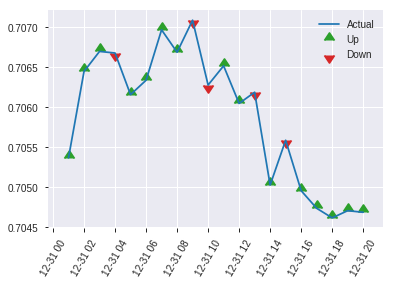


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21901389321237918
RMSE: 0.4679892020254091
LogLoss: 0.6299212128461361
Null degrees of freedom: 616
Residual degrees of freedom: -424
Null deviance: 855.2213378304502
Residual deviance: 777.322776652132
AIC: 2859.3227766521322
AUC: 0.7450525762355416
pr_auc: 0.7201096154510389
Gini: 0.4901051524710831
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25438500218397164: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      152  165  0.5205   (165.0/317.0)
1      41   259  0.1367   (41.0/300.0)
Total  193  424  0.3339   (206.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.254385     0.71547   273
max f2                       0.0917536    0.835686  368
max f0point5                 0.344171     0.67112   212
max accuracy                 0.344171     0.682334  212
max precision                0.898302     1         0
max recall                   0.0100275    1         399
max specificity              0.898302     1         0
max absolute_mcc             0.284959     0.370304  255
max min_per_class_accuracy   0.358206     0.675079  203
max mean_per_class_accuracy  0.344171     0.682897  212

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 36.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.821372           2.05667   2.05667            1                0.856942   1                           0.856942            0.0233333       0.0233333                  105.667   105.667
    2        0.0210697                   0.790706           1.37111   1.74026            0.666667         0.809545   0.846154                    0.835066            0.0133333       0.0366667                  37.1111   74.0256
    3        0.0307942                   0.776822           1.71389   1.73193            0.833333         0.784536   0.842105                    0.819109            0.0166667       0.0533333                  71.3889   73.193
    4        0.0405186                   0.743512           1.71389   1.7276             0.833333         0.764705   0.84                        0.806052            0.0166667       0.07                       71.3889   72.76
    5        0.0502431                   0.729525           1.37111   1.6586             0.666667         0.734548   0.806452                    0.792213            0.0133333       0.0833333                  37.1111   65.8602
    6        0.100486                    0.656932           1.72495   1.69177            0.83871          0.693555   0.822581                    0.742884            0.0866667       0.17                       72.4946   69.1774
    7        0.150729                    0.581033           1.79129   1.72495            0.870968         0.614622   0.83871                     0.70013             0.09            0.26                       79.129    72.4946
    8        0.200972                    0.539109           1.32688   1.62543            0.645161         0.559056   0.790323                    0.664862            0.0666667       0.326667                   32.6882   62.543
    9        0.299838                    0.457411           1.38235   1.54528            0.672131         0.495552   0.751351                    0.609035            0.136667        0.463333                   38.235    54.5279
    10       0.400324                    0.41067            0.895645  1.38221            0.435484         0.432925   0.672065                    0.564829            0.09            0.553333                   -10.4355  38.2213
    11       0.50081                     0.35559            1.29371   1.36446            0.629032         0.383842   0.66343                     0.528515            0.13            0.683333                   29.371    36.4455
    12       0.599676                    0.303071           1.01148   1.30626            0.491803         0.325348   0.635135                    0.49502             0.1             0.783333                   1.14754   30.6261
    13       0.700162                    0.245343           0.829301  1.23781            0.403226         0.274003   0.601852                    0.4633              0.0833333       0.866667                   -17.0699  23.7809
    14       0.799028                    0.1811             0.708033  1.17226            0.344262         0.215369   0.56998                     0.432623            0.07            0.936667                   -29.1967  17.2258
    15       0.899514                    0.112752           0.364892  1.08207            0.177419         0.149169   0.526126                    0.400957            0.0366667       0.973333                   -63.5108  8.20661
    16       1                           0.0100275          0.265376  1                  0.129032         0.0664572  0.486224                    0.3

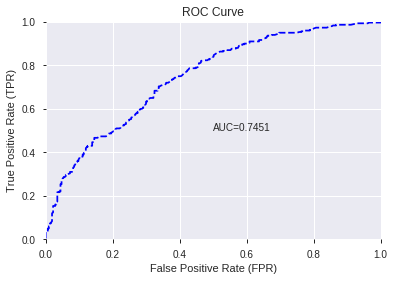

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


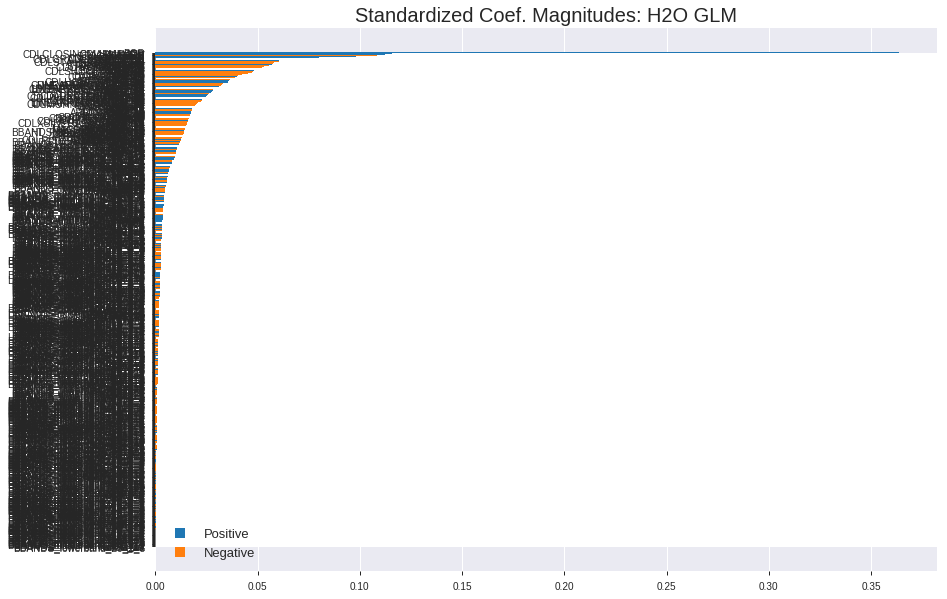

'log_likelihood'
--2019-08-24 13:28:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.225.248
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.225.248|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_132625_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_132625_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_b8e3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

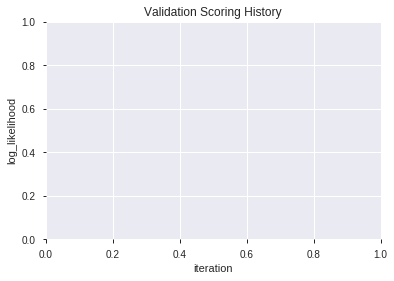

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_132945_model_4  0.742823  0.593486              0.341887  0.453324  0.205503
1  XGBoost_grid_1_AutoML_20190824_132945_model_3  0.740252  0.593954              0.365068  0.453615  0.205766
2               XGBoost_3_AutoML_20190824_132945  0.739490  0.596535              0.348880  0.454621  0.206680
3  XGBoost_grid_1_AutoML_20190824_132945_model_2  0.738996  0.594557              0.365426  0.453636  0.205786
4  XGBoost_grid_1_AutoML_20190824_132945_model_1  0.735552  0.598151              0.356767  0.455578  0.207552
5  XGBoost_grid_1_AutoML_20190824_132945_model_6  0.735126  0.599025              0.364295  0.455468  0.207452
6               XGBoost_2_AutoML_20190824_132945  0.725342  0.606868              0.362718  0.459702  0.211326
7               XGBoost_1_AutoML_20190824_132945  0.724516  0.608327              0.331919  0.459972  0.211574
8  XGBoost_grid_1_AutoML_20190824_132945_model_7  0.723885  0.610370              0.359921  0.460988  0.212510
9  XGBoost_grid_1_AutoML_20190824_132945_model_5  0.714932  0.623974              0.367539  0.465610  0.216793

variable  relative_importance  scaled_importance  percentage
0                        BOP          4551.658691           1.000000    0.327759
1                        DIV           749.166687           0.164592    0.053947
2               STOCHF_fastk           639.416260           0.140480    0.046044
3         CDLCLOSINGMARUBOZU           522.840942           0.114868    0.037649
4                     TRANGE           420.936584           0.092480    0.030311
..                       ...                  ...                ...         ...
206              MACD_signal             5.134806           0.001128    0.000370
207                   MIN_14             4.882163           0.001073    0.000352
208                     Open             4.786415           0.001052    0.000345
209                  TRIX_12             4.431046           0.000974    0.000319
210  BBANDS_upperband_14_5_4             4.361340           0.000958    0.000314

[211 rows x 4 columns]

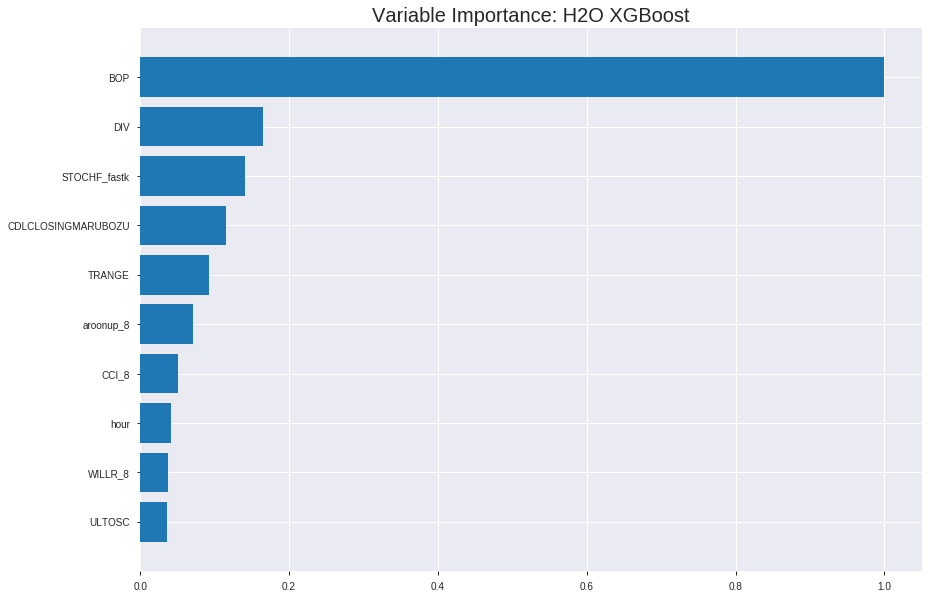

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_132945_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16785475751539242
RMSE: 0.40970081463842906
LogLoss: 0.5096403392006327
Mean Per-Class Error: 0.23659166121712938
AUC: 0.845096794982807
pr_auc: 0.8294747291198878
Gini: 0.690193589965614
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44562189653515816: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1528  740   0.3263   (740.0/2268.0)
1      329   1718  0.1607   (329.0/2047.0)
Total  1857  2458  0.2477   (1069.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.445622     0.762708  220
max f2                       0.222472     0.855538  326
max f0point5                 0.595483     0.763597  141
max accuracy                 0.482747     0.762225  200
max precision                0.924864     1         0
max recall                   0.115351     1         376
max specificity              0.924864     1         0
max absolute_mcc             0.482747     0.526223  200
max min_per_class_accuracy   0.499776     0.757937  192
max mean_per_class_accuracy  0.482747     0.763408  200

Gains/Lift Table: Avg response rate: 47.44 %, avg score: 47.30 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.887185           2.10796    2.10796            1                0.897374  1                           0.897374            0.0214949       0.0214949                  110.796   110.796
    2        0.0201622                   0.866281           2.10796    2.10796            1                0.87666   1                           0.887136            0.0210064       0.0425012                  110.796   110.796
    3        0.0301275                   0.843626           1.9609     2.05932            0.930233         0.852954  0.976923                    0.87583             0.0195408       0.062042                   96.0896   105.932
    4        0.0400927                   0.828362           1.9609     2.03485            0.930233         0.836247  0.965318                    0.865991            0.0195408       0.0815828                  96.0896   103.485
    5        0.0500579                   0.813802           2.00992    2.02989            0.953488         0.820951  0.962963                    0.857025            0.0200293       0.101612                   100.992   102.989
    6        0.100116                    0.752592           1.91278    1.97134            0.907407         0.778798  0.935185                    0.817912            0.0957499       0.197362                   91.2781   97.1336
    7        0.150174                    0.706931           1.84447    1.92905            0.875            0.729659  0.915123                    0.788494            0.0923302       0.289692                   84.4468   92.9046
    8        0.2                         0.675028           1.76481    1.88813            0.837209         0.691157  0.895713                    0.764244            0.0879336       0.377626                   76.4806   88.8129
    9        0.300116                    0.615463           1.58585    1.78729            0.752315         0.644626  0.847876                    0.724341            0.158769        0.536395                   58.5852   78.7292
    10       0.4                         0.556444           1.25206    1.65364            0.593968         0.586615  0.784473                    0.689949            0.125061        0.661456                   25.2061   65.3639
    11       0.500116                    0.489108           1.13693    1.5502             0.539352         0.523104  0.735403                    0.656549            0.113825        0.775281                   13.6934   55.0203
    12       0.6                         0.424914           0.836338   1.43136            0.396752         0.457004  0.679027                    0.62333             0.0835369       0.858818                   -16.3662  43.1363
    13       0.699884                    0.34032            0.655376   1.32062            0.310905         0.383466  0.62649                     0.589098            0.0654617       0.924279                   -34.4624  32.0618
    14       0.8                         0.24687            0.453798   1.21214            0.215278         0.295037  0.575029                    0.552298            0.0454323       0.969712                   -54.6202  21.214
    15       0.899884                    0.150703           0.268998   1.10745            0.12761          0.196608  0.525367                    0.512818            0.0268686       0.99658                    -73.1002  10.7454
    16       1                           0.0522011          0.0341568  1                  0.0162037        0.115574  0.474392                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19099416950632406
RMSE: 0.43702879711332987
LogLoss: 0.5637754348929606
Mean Per-Class Error: 0.27625035521454966
AUC: 0.7869094229210739
pr_auc: 0.7716688808644654
Gini: 0.5738188458421478
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4048832555611928: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      366  255  0.4106   (255.0/621.0)
1      113  499  0.1846   (113.0/612.0)
Total  479  754  0.2985   (368.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.404883     0.7306    234
max f2                       0.176454     0.847458  347
max f0point5                 0.53877      0.734536  166
max accuracy                 0.53877      0.72425   166
max precision                0.916177     1         0
max recall                   0.0845457    1         392
max specificity              0.916177     1         0
max absolute_mcc             0.53877      0.45234   166
max min_per_class_accuracy   0.488248     0.712418  193
max mean_per_class_accuracy  0.536927     0.72375   167

Gains/Lift Table: Avg response rate: 49.64 %, avg score: 46.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105434                   0.870403           1.70475   1.70475            0.846154         0.887981  0.846154                    0.887981            0.0179739       0.0179739                  70.4751    70.4751
    2        0.0202758                   0.848888           1.84681   1.77294            0.916667         0.860768  0.88                        0.874919            0.0179739       0.0359477                  84.6814    77.2941
    3        0.0300081                   0.824266           1.84681   1.7969             0.916667         0.83652   0.891892                    0.862465            0.0179739       0.0539216                  84.6814    79.69
    4        0.0405515                   0.813723           1.85973   1.81324            0.923077         0.819458  0.9                         0.851283            0.0196078       0.0735294                  85.9729    81.3235
    5        0.0502839                   0.792622           1.84681   1.81973            0.916667         0.804058  0.903226                    0.842143            0.0179739       0.0915033                  84.6814    81.9734
    6        0.100568                    0.72681            1.78724   1.80349            0.887097         0.76286   0.895161                    0.802502            0.0898693       0.181373                   78.7239    80.3487
    7        0.150041                    0.679389           1.68443   1.76423            0.836066         0.700373  0.875676                    0.768827            0.0833333       0.264706                   68.4426    76.4229
    8        0.200324                    0.652238           1.46229   1.68844            0.725806         0.665524  0.838057                    0.742897            0.0735294       0.338235                   46.2287    68.8438
    9        0.300081                    0.612924           1.39228   1.58998            0.691057         0.631128  0.789189                    0.705741            0.138889        0.477124                   39.2276    58.9984
    10       0.399838                    0.549573           1.39228   1.54066            0.691057         0.581087  0.764706                    0.674641            0.138889        0.616013                   39.2276    54.0657
    11       0.500406                    0.485912           0.991105  1.43021            0.491935         0.520367  0.709887                    0.643636            0.0996732       0.715686                   -0.889469  43.0213
    12       0.600162                    0.415392           0.884505  1.33951            0.439024         0.454326  0.664865                    0.61217             0.0882353       0.803922                   -11.5495   33.9507
    13       0.699919                    0.333404           0.704328  1.24898            0.349593         0.372971  0.61993                     0.578078            0.0702614       0.874183                   -29.5672   24.8978
    14       0.799676                    0.259083           0.687948  1.17899            0.341463         0.297918  0.585193                    0.543129            0.0686275       0.94281                    -31.2052   17.8991
    15       0.899432                    0.15869            0.409493  1.09365            0.203252         0.208922  0.542831                    0.506062            0.0408497       0.98366                    -59.0507   9.36456
    16       1                           0.0570861          0.162476  1                  0.0806452        0.112379  0.49635                     0.


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 13:31:05  29.470 sec  0                  0.5              0.693147            0.5             0                  1                0.525608                         0.5                0.693147              0.5               0                    1                  0.50365
    2019-08-24 13:31:07  30.829 sec  5                  0.478024         0.649868            0.780548        0.746742           2.01631          0.32051                          0.480423           0.654529              0.76783           0.745934             1.70475            0.304136
    2019-08-24 13:31:08  31.527 sec  10                 0.463045         0.620508            0.792584        0.766127           2.06005          0.313094                         0.467701           0.629469              0.771819          0.757323             1.74608            0.284672
    2019-08-24 13:31:08  32.224 sec  15                 0.45293          0.600312            0.796193        0.771121           2.06005          0.308922                         0.459262           0.612546              0.77329           0.761757             1.85973            0.313869
    2019-08-24 13:31:09  32.923 sec  20                 0.445407         0.584956            0.801756        0.777111           2.06005          0.304751                         0.45334            0.600274              0.775264          0.761659             1.70475            0.309813
    2019-08-24 13:31:10  33.618 sec  25                 0.439337         0.572125            0.80476         0.780968           2.06005          0.296176                         0.449188           0.591444              0.777928          0.765989             1.85973            0.287105
    2019-08-24 13:31:10  34.317 sec  30                 0.434786         0.56235             0.807494        0.784504           2.06005          0.296408                         0.446129           0.584766              0.779122          0.765466             1.54977            0.29116
    2019-08-24 13:31:11  35.022 sec  35                 0.431383         0.554732            0.810078        0.786739           2.06005          0.297103                         0.444472           0.580662              0.778708          0.764746             1.85973            0.297648
    2019-08-24 13:31:12  35.722 sec  40                 0.428553         0.548504            0.812385        0.789517           2.10796          0.291078                         0.44316            0.577863              0.779714          0.763474             1.70475            0.293593
    2019-08-24 13:31:12  36.399 sec  45                 0.426092         0.543282            0.816866        0.795682           2.10796          0.285516                         0.441494           0.57427               0.782263          0.76675              1.70475            0.286294
    2019-08-24 13:31:13  37.138 sec  50                 0.424072         0.538839            0.819197        0.799103           2.10796          0.289455                         0.440565           0.572093              0.782895          0.76752              1.70475            0.287105
    2019-08-24 13:31:14  37.833 sec  55                 0.422034         0.534495            0.822304        0.803489           2.10796          0.286211                         0.439756           0.570236              0.784574          0.7

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      4551.65869140625       1.0                    0.3277589286678155
DIV                      749.1666870117188      0.1645920175047794     0.05394650332464083
STOCHF_fastk             639.416259765625       0.14047983452117654    0.04604352006209283
CDLCLOSINGMARUBOZU       522.8409423828125      0.1148682222966237     0.037649085477917864
TRANGE                   420.93658447265625     0.0924798217553976     0.03031108730193965
---                      ---                    ---                    ---
MACD_signal              5.134805679321289      0.0011281174682574615  0.00036975057280751395
MIN_14                   4.882163047790527      0.001072611849611722   0.00035155811070514196
Open                     4.786415100097656      0.001051576013187157   0.0003446634274949952
TRIX_12                  4.4310455322265625     0.00097350127341327    0.0003190737344306875
BBANDS_upperband_14_5_4  4.361339569091797      0.0009581868643460053  0.0003140543001216202


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6839546191247974)

('F1', 0.7144754316069057)

('auc', 0.7428233438485804)

('logloss', 0.593485676606451)

('mean_per_class_error', 0.31463196635120916)

('rmse', 0.4533242501246905)

('mse', 0.20550287575111298)

xgboost prediction progress: |████████████████████████████████████████████| 100%


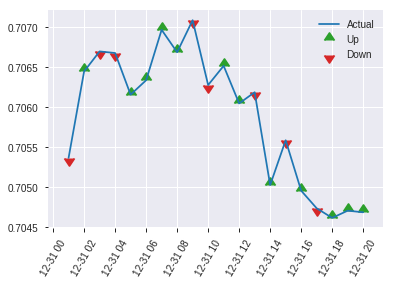


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20550287575111298
RMSE: 0.4533242501246905
LogLoss: 0.593485676606451
Mean Per-Class Error: 0.31463196635120916
AUC: 0.7428233438485804
pr_auc: 0.7190886304160867
Gini: 0.4856466876971608
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29972952604293823: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      133  184  0.5804   (184.0/317.0)
1      31   269  0.1033   (31.0/300.0)
Total  164  453  0.3485   (215.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.29973      0.714475  285
max f2                       0.154709     0.844749  356
max f0point5                 0.439995     0.67051   215
max accuracy                 0.439995     0.683955  215
max precision                0.913765     1         0
max recall                   0.0726349    1         394
max specificity              0.913765     1         0
max absolute_mcc             0.408571     0.374236  233
max min_per_class_accuracy   0.469207     0.665615  200
max mean_per_class_accuracy  0.439995     0.685368  215

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 44.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.882951           2.05667   2.05667            1                0.895412  1                           0.895412            0.0233333       0.0233333                  105.667   105.667
    2        0.0210697                   0.857756           2.05667   2.05667            1                0.86605   1                           0.88186             0.02            0.0433333                  105.667   105.667
    3        0.0307942                   0.830439           1.37111   1.84018            0.666667         0.847538  0.894737                    0.871022            0.0133333       0.0566667                  37.1111   84.0175
    4        0.0405186                   0.80316            2.05667   1.89213            1                0.816881  0.92                        0.858028            0.02            0.0766667                  105.667   89.2133
    5        0.0502431                   0.77335            2.05667   1.92398            1                0.794428  0.935484                    0.845718            0.02            0.0966667                  105.667   92.3978
    6        0.100486                    0.695161           1.45957   1.69177            0.709677         0.72665   0.822581                    0.786184            0.0733333       0.17                       45.957    69.1774
    7        0.150729                    0.656507           1.59226   1.6586             0.774194         0.673173  0.806452                    0.748514            0.08            0.25                       59.2258   65.8602
    8        0.200972                    0.62527            1.32688   1.57567            0.645161         0.639993  0.766129                    0.721384            0.0666667       0.316667                   32.6882   57.5672
    9        0.299838                    0.565853           1.2812    1.47858            0.622951         0.593024  0.718919                    0.67906             0.126667        0.443333                   28.1202   47.8577
    10       0.400324                    0.523267           1.12785   1.39054            0.548387         0.543798  0.676113                    0.645107            0.113333        0.556667                   12.7849   39.054
    11       0.50081                     0.467814           1.19419   1.35114            0.580645         0.494602  0.656958                    0.614909            0.12            0.676667                   19.4194   35.1143
    12       0.599676                    0.407181           1.11262   1.31182            0.540984         0.43592   0.637838                    0.5854              0.11            0.786667                   11.2623   31.182
    13       0.700162                    0.333003           0.729785  1.22829            0.354839         0.374247  0.597222                    0.555095            0.0733333       0.86                       -27.0215  22.8287
    14       0.799028                    0.23147            0.80918   1.17643            0.393443         0.281376  0.572008                    0.521228            0.08            0.94                       -19.082   17.643
    15       0.899514                    0.145317           0.464409  1.09689            0.225806         0.190043  0.533333                    0.48423             0.0466667       0.986667                   -53.5591  9.68889
    16       1                           0.0591317          0.132688  1                  0.0645161        0.102818  0.486224                    0.445904            

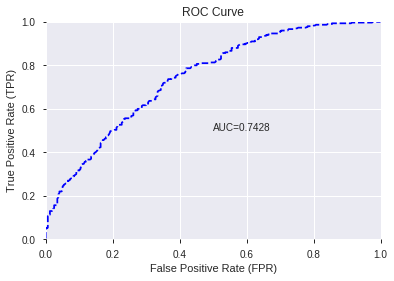

This function is available for GLM models only


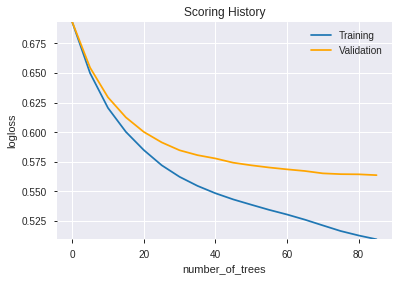

--2019-08-24 13:32:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_132945_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_132945_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_b8e3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_133302_model_8  0.753575  0.598118              0.332156  0.451281  0.203654
1  DeepLearning_grid_1_AutoML_20190824_133302_model_5  0.751625  0.590042              0.348970  0.450545  0.202991
2  DeepLearning_grid_1_AutoML_20190824_133302_model_9  0.750557  0.603550              0.320610  0.453035  0.205241
3  DeepLearning_grid_1_AutoML_20190824_133302_model_6  0.746824  0.611366              0.320431  0.456477  0.208371
4               DeepLearning_1_AutoML_20190824_133302  0.737971  0.713155              0.351856  0.500396  0.250396
5  DeepLearning_grid_1_AutoML_20190824_133302_model_4  0.732676  0.623994              0.350279  0.460136  0.211726
6  DeepLearning_grid_1_AutoML_20190824_133302_model_3  0.713496  0.700314              0.334716  0.478719  0.229172
7  DeepLearning_grid_1_AutoML_20190824_133302_model_7  0.711845  0.719647              0.376141  0.485538  0.235748
8  DeepLearning_grid_1_AutoML_20190824_133302_model_2  0.677781  0.806496              0.386052  0.508052  0.258117
9  DeepLearning_grid_1_AutoML_20190824_133302_model_1  0.677718  0.934291              0.419769  0.518600  0.268946

variable  relative_importance  scaled_importance  percentage
0     CDLCLOSINGMARUBOZU             1.000000           1.000000    0.042288
1                    BOP             0.959726           0.959726    0.040585
2            CDLMARUBOZU             0.657374           0.657374    0.027799
3                    SUB             0.620989           0.620989    0.026260
4           HT_TRENDMODE             0.588123           0.588123    0.024871
5                 TRANGE             0.587068           0.587068    0.024826
6         STOCHRSI_fastk             0.582658           0.582658    0.024640
7                    DIV             0.566635           0.566635    0.023962
8           CDLSHORTLINE             0.550534           0.550534    0.023281
9                  CCI_8             0.541394           0.541394    0.022895
10                  hour             0.540508           0.540508    0.022857
11                SAREXT             0.510452           0.510452    0.021586
12             aroonup_8             0.500379           0.500379    0.021160
13         days_in_month             0.493566           0.493566    0.020872
14          STOCHF_fastk             0.488078           0.488078    0.020640
15                ULTOSC             0.483828           0.483828    0.020460
16             CDLHAMMER             0.476316           0.476316    0.020143
17                Volume             0.471664           0.471664    0.019946
18               BETA_20             0.462018           0.462018    0.019538
19             STDDEV_30             0.459519           0.459519    0.019432
20               BETA_24             0.443205           0.443205    0.018742
21     CDLGRAVESTONEDOJI             0.439362           0.439362    0.018580
22             CDLTAKURI             0.435728           0.435728    0.018426
23          aroondown_12             0.434969           0.434969    0.018394
24                MFI_14             0.434733           0.434733    0.018384
25            MINUS_DI_8             0.427920           0.427920    0.018096
26             dayofyear             0.427852           0.427852    0.018093
27  HT_PHASOR_quadrature             0.426953           0.426953    0.018055
28           CDLLONGLINE             0.423022           0.423022    0.017889
29             PLUS_DI_8             0.422794           0.422794    0.017879
30                    AD             0.418206           0.418206    0.017685
31         CDLHANGINGMAN             0.413214           0.413214    0.017474
32           STOCH_slowd             0.411909           0.411909    0.017419
33                 MFI_8             0.411336           0.411336    0.017395
34               WILLR_8             0.408723           0.408723    0.017284
35            weekofyear             0.405480           0.405480    0.017147
36             CORREL_20             0.402841           0.402841    0.017035
37           CDLBELTHOLD             0.399266           0.399266    0.016884
38          CDLENGULFING             0.396219           0.396219    0.016755
39                 ADOSC             0.389818           0.389818    0.016485
40              WILLR_20             0.386203           0.386203    0.016332
41                 RSI_8             0.385705           0.385705    0.016311
42             PLUS_DM_8             0.383893           0.383893    0.016234
43              WILLR_12             0.380874           0.380874    0.016106
44                 month             0.375804           0.375804    0.015892
45              WILLR_24             0.372163           0.372163    0.015738
46              WILLR_14             0.370225           0.370225    0.015656
47                  week             0.364706           0.364706    0.015423
48      CDLDRAGONFLYDOJI             0.363191           0.363191    0.015359
49                 CMO_8             0.350141           0.350141    0.014807

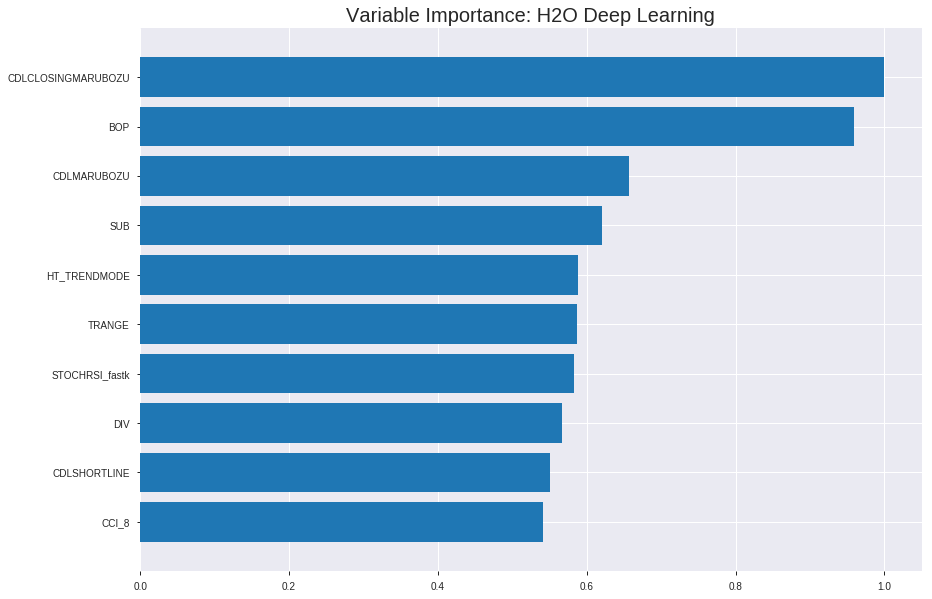

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_133302_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19788988479251196
RMSE: 0.4448481592549439
LogLoss: 0.577661149961993
Mean Per-Class Error: 0.29424528862731114
AUC: 0.7789601981305286
pr_auc: 0.7403647679843622
Gini: 0.5579203962610573
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45480771115408425: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1065  1203  0.5304   (1203.0/2268.0)
1      218   1829  0.1065   (218.0/2047.0)
Total  1283  3032  0.3293   (1421.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.454808     0.720221  213
max f2                       0.21729      0.840515  316
max f0point5                 0.561618     0.690406  136
max accuracy                 0.538225     0.702665  157
max precision                0.809892     1         0
max recall                   0.0239902    1         393
max specificity              0.809892     1         0
max absolute_mcc             0.51117      0.417021  177
max min_per_class_accuracy   0.542156     0.697972  153
max mean_per_class_accuracy  0.520293     0.705755  171

Gains/Lift Table: Avg response rate: 47.44 %, avg score: 48.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.762927           1.86842   1.86842            0.886364         0.772286  0.886364                    0.772286            0.0190523       0.0190523                  86.8422   86.8422
    2        0.0201622                   0.744952           1.56872   1.72029            0.744186         0.75373   0.816092                    0.763115            0.0156326       0.0346849                  56.8717   72.0292
    3        0.0301275                   0.730348           1.91187   1.78366            0.906977         0.737329  0.846154                    0.754586            0.0190523       0.0537372                  91.1873   78.3661
    4        0.0400927                   0.719692           1.81383   1.79116            0.860465         0.724814  0.849711                    0.747186            0.0180752       0.0718124                  81.3829   79.1159
    5        0.0500579                   0.711343           2.05894   1.84447            0.976744         0.715228  0.875                       0.740824            0.0205178       0.0923302                  105.894   84.4468
    6        0.100116                    0.675491           1.79567   1.82007            0.851852         0.69161   0.863426                    0.716217            0.0898876       0.182218                   79.5672   82.007
    7        0.150174                    0.651934           1.62001   1.75338            0.768519         0.663772  0.83179                     0.698735            0.0810943       0.263312                   62.0009   75.3383
    8        0.2                         0.631932           1.5295    1.69761            0.725581         0.641923  0.80533                     0.684582            0.0762091       0.339521                   52.9499   69.7606
    9        0.300116                    0.594895           1.40531   1.6001             0.666667         0.61279   0.759073                    0.660632            0.140694        0.480215                   40.5309   60.0098
    10       0.4                         0.565045           1.2325    1.5083             0.584687         0.579834  0.715527                    0.640456            0.123107        0.603322                   23.2498   50.8305
    11       0.500116                    0.540123           1.08814   1.42419            0.516204         0.551632  0.675626                    0.622675            0.10894         0.712262                   8.81382   42.4194
    12       0.6                         0.512075           1.0173    1.35646            0.482599         0.528096  0.643492                    0.60693             0.101612        0.813874                   1.72999   35.6457
    13       0.699884                    0.455774           0.762975  1.27176            0.361949         0.486302  0.603311                    0.589715            0.0762091       0.890083                   -23.7025  27.1758
    14       0.8                         0.338207           0.595304  1.1871             0.282407         0.404335  0.563152                    0.566515            0.0595994       0.949682                   -40.4696  18.7103
    15       0.899884                    0.154942           0.361924  1.09551            0.171694         0.252404  0.519701                    0.53165             0.0361505       0.985833                   -63.8076  9.5511
    16       1                           0.00493971         0.141507  1                  0.0671296        0.084641  0.474392                    0.486897           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19651985231480437
RMSE: 0.44330559698113936
LogLoss: 0.5780116634808022
Mean Per-Class Error: 0.2845386947049351
AUC: 0.7900629387557492
pr_auc: 0.7806917132539167
Gini: 0.5801258775114984
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4468450242341663: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      326  295  0.475    (295.0/621.0)
1      87   525  0.1422   (87.0/612.0)
Total  413  820  0.3098   (382.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.446845     0.73324   219
max f2                       0.238512     0.845514  315
max f0point5                 0.564251     0.727848  134
max accuracy                 0.523961     0.715328  167
max precision                0.669366     0.947826  50
max recall                   0.0328026    1         387
max specificity              0.802401     0.99839   0
max absolute_mcc             0.564251     0.433471  134
max min_per_class_accuracy   0.529727     0.706924  163
max mean_per_class_accuracy  0.523961     0.715461  167

Gains/Lift Table: Avg response rate: 49.64 %, avg score: 47.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.759538           1.70475   1.70475            0.846154         0.775528   0.846154                    0.775528            0.0179739       0.0179739                  70.4751   70.4751
    2        0.0202758                   0.737803           1.84681   1.77294            0.916667         0.750487   0.88                        0.763508            0.0179739       0.0359477                  84.6814   77.2941
    3        0.0300081                   0.72795            1.84681   1.7969             0.916667         0.731614   0.891892                    0.753164            0.0179739       0.0539216                  84.6814   79.69
    4        0.0405515                   0.719694           2.01471   1.85353            1                0.723625   0.92                        0.745484            0.0212418       0.0751634                  101.471   85.3529
    5        0.0502839                   0.70941            1.84681   1.85223            0.916667         0.715424   0.919355                    0.739666            0.0179739       0.0931373                  84.6814   85.223
    6        0.100568                    0.666052           1.88472   1.86848            0.935484         0.684017   0.927419                    0.711841            0.0947712       0.187908                   88.4725   86.8477
    7        0.150041                    0.641403           1.58534   1.77512            0.786885         0.654376   0.881081                    0.692893            0.0784314       0.26634                    58.5342   77.5119
    8        0.200324                    0.620829           1.65726   1.74553            0.822581         0.630688   0.866397                    0.677279            0.0833333       0.349673                   65.7258   74.5535
    9        0.300081                    0.588886           1.39228   1.6281             0.691057         0.603395   0.808108                    0.652717            0.138889        0.488562                   39.2276   62.81
    10       0.399838                    0.559141           1.22848   1.5284             0.609756         0.575221   0.758621                    0.633383            0.122549        0.611111                   22.8479   52.8398
    11       0.500406                    0.529601           1.00735   1.42368            0.5              0.5438     0.706645                    0.615379            0.101307        0.712418                   0.735294  42.3682
    12       0.600162                    0.48448            0.933644  1.34223            0.463415         0.509383   0.666216                    0.597761            0.0931373       0.805556                   -6.63558  34.223
    13       0.699919                    0.415643           0.753467  1.25832            0.373984         0.45311    0.624565                    0.577144            0.0751634       0.880719                   -24.6533  25.8316
    14       0.799676                    0.29717            0.556911  1.17082            0.276423         0.364892   0.581136                    0.550667            0.0555556       0.936275                   -44.3089  17.0818
    15       0.899432                    0.152415           0.442253  1.09001            0.219512         0.230858   0.541028                    0.515196            0.0441176       0.980392                   -55.7747  9.00122
    16       1                           0.00877639         0.194972  1                  0.0967742        0.0747693  0.49635                     0.470


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 13:45:03  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 13:45:05  2 min 52.466 sec  606 obs/sec       0.293163  1             1265       0.511047         0.807352            -0.0474231     0.747248        0.693362           1.58097          0.360834                         0.485506           0.70454               0.0570839        0.760663          0.740495             1.70475            0.326845
    2019-08-24 13:45:35  3 min 22.521 sec  1195 obs/sec      8.07462   28            34842      0.444848         0.577661            0.206359       0.77896         0.740365           1.86842          0.329316                         0.443306           0.578012              0.213879         0.790063          0.780692             1.70475            0.309813
    2019-08-24 13:46:06  3 min 52.703 sec  1339 obs/sec      17.5133   61            75570      0.434488         0.55492             0.242895       0.791753        0.757553           1.91633          0.316107                         0.449851           0.588044              0.190495         0.786802          0.774197             1.70475            0.30738
    2019-08-24 13:46:35  4 min 22.201 sec  1433 obs/sec      27.5428   96            118847     0.433187         0.551067            0.247421       0.801654        0.775563           1.96424          0.295249                         0.460517           0.608038              0.151652         0.772965          0.75546              1.70475            0.336577
    2019-08-24 13:47:06  4 min 52.786 sec  1492 obs/sec      38.1993   133           164830     0.430079         0.547129            0.258182       0.81566         0.793605           2.10796          0.301043                         0.452827           0.59678               0.179747         0.777195          0.764666             1.85973            0.334144
    2019-08-24 13:47:36  5 min 23.451 sec  1534 obs/sec      49.1115   171           211916     0.410831         0.502363            0.323097       0.830952        0.811319           2.06005          0.272538                         0.443035           0.578138              0.214839         0.777321          0.760113             1.85973            0.296026
    2019-08-24 13:48:07  5 min 53.837 sec  1565 obs/sec      60.0366   209           259058     0.403758         0.487247            0.346202       0.848781        0.83107            2.10796          0.270915                         0.445869           0.587928              0.204762         0.777994          0.762193             1.85973            0.3382
    2019-08-24 13:48:10  5 min 56.820 sec  1565 obs/sec      60.0366   209           259058     0.444848         0.577661            0.206359       0.77896         0.740365           1.86842          0.329316                         0.443306           0.578012              0.213879         0.790063          0.780692             1.70475            0.309813

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.042288148132308696
BOP                 0.9597259759902954     0.9597259759902954   0.040585034239102154
CDLMARUBOZU         0.6573740243911743     0.6573740243911743   0.027799130121785892
SUB                 0.6209886074066162     0.6209886074066162   0.026260458218487076
HT_TRENDMODE        0.5881230235099792     0.5881230235099792   0.024870633538211274
---                 ---                    ---                  ---
WILLR_24            0.37216323614120483    0.37216323614120483  0.015738094059338653
WILLR_14            0.37022531032562256    0.37022531032562256  0.015656142765379886
week                0.3647063076496124     0.3647063076496124   0.01542275436267416
CDLDRAGONFLYDOJI    0.3631913661956787     0.3631913661956787   0.015358690294058435
CMO_8               0.35014113783836365    0.35014113783836365  0.01480682030412384


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6871961102106969)

('F1', 0.7224435590969455)

('auc', 0.7535751840168243)

('logloss', 0.5981182728558606)

('mean_per_class_error', 0.31144584647739215)

('rmse', 0.4512807020563825)

('mse', 0.20365427204850145)

deeplearning prediction progress: |███████████████████████████████████████| 100%


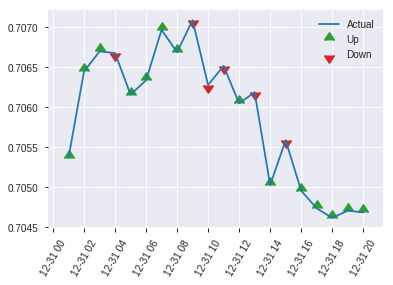


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20365427204850145
RMSE: 0.4512807020563825
LogLoss: 0.5981182728558606
Mean Per-Class Error: 0.31144584647739215
AUC: 0.7535751840168243
pr_auc: 0.7253648481219284
Gini: 0.5071503680336487
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35986329517582294: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      136  181  0.571    (181.0/317.0)
1      28   272  0.0933   (28.0/300.0)
Total  164  453  0.3387   (209.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.359863     0.722444  262
max f2                       0.208023     0.84104   327
max f0point5                 0.53731      0.682143  157
max accuracy                 0.53731      0.687196  157
max precision                0.780842     1         0
max recall                   0.00766993   1         399
max specificity              0.780842     1         0
max absolute_mcc             0.473586     0.385214  208
max min_per_class_accuracy   0.525017     0.66877   169
max mean_per_class_accuracy  0.473586     0.688554  208

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 45.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.766919           1.76286   1.76286            0.857143         0.774027   0.857143                    0.774027            0.02            0.02                       76.2857   76.2857
    2        0.0210697                   0.755052           1.71389   1.74026            0.833333         0.75974    0.846154                    0.767433            0.0166667       0.0366667                  71.3889   74.0256
    3        0.0307942                   0.74557            1.37111   1.62368            0.666667         0.749328   0.789474                    0.761716            0.0133333       0.05                       37.1111   62.3684
    4        0.0405186                   0.723957           2.05667   1.7276             1                0.735586   0.84                        0.755444            0.02            0.07                       105.667   72.76
    5        0.0502431                   0.711753           2.05667   1.79129            1                0.71937    0.870968                    0.748462            0.02            0.09                       105.667   79.129
    6        0.100486                    0.657003           1.79129   1.79129            0.870968         0.686844   0.870968                    0.717653            0.09            0.18                       79.129    79.129
    7        0.150729                    0.624636           1.85763   1.81341            0.903226         0.639621   0.88172                     0.691643            0.0933333       0.273333                   85.7634   81.3405
    8        0.200972                    0.597272           1.06151   1.62543            0.516129         0.610267   0.790323                    0.671299            0.0533333       0.326667                   6.15054   62.543
    9        0.299838                    0.573109           1.24749   1.50081            0.606557         0.583836   0.72973                     0.64246             0.123333        0.45                       24.7486   50.0811
    10       0.400324                    0.549309           1.16102   1.41552            0.564516         0.560383   0.688259                    0.621857            0.116667        0.566667                   16.1022   41.552
    11       0.50081                     0.524481           1.09468   1.35114            0.532258         0.536199   0.656958                    0.60467             0.11            0.676667                   9.46774   35.1143
    12       0.599676                    0.476622           1.18005   1.32294            0.57377          0.502036   0.643243                    0.58775             0.116667        0.793333                   18.0055   32.2937
    13       0.700162                    0.391617           0.829301  1.25209            0.403226         0.437307   0.608796                    0.566158            0.0833333       0.876667                   -17.0699  25.2091
    14       0.799028                    0.263579           0.640601  1.17643            0.311475         0.340085   0.572008                    0.538186            0.0633333       0.94                       -35.9399  17.643
    15       0.899514                    0.120037           0.364892  1.08577            0.177419         0.20476    0.527928                    0.500938            0.0366667       0.976667                   -63.5108  8.57718
    16       1                           0.00766993         0.232204  1                  0.112903         0.0614776  0.486224                    0.4567

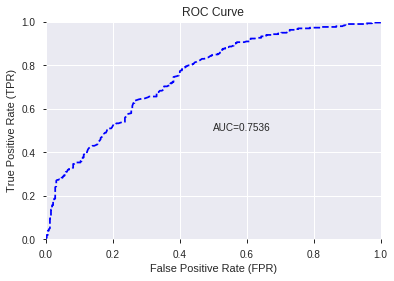

This function is available for GLM models only


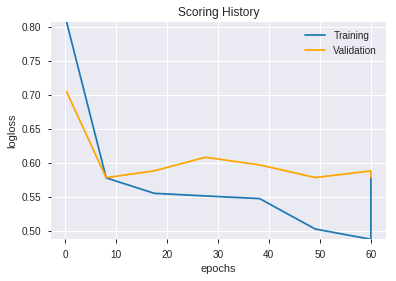

--2019-08-24 13:53:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.160.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.160.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_133302_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_133302_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_b8e3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'BOP',
 'CDLMARUBOZU',
 'SUB',
 'HT_TRENDMODE',
 'TRANGE',
 'STOCHRSI_fastk',
 'DIV',
 'CDLSHORTLINE',
 'CCI_8',
 'hour',
 'SAREXT',
 'aroonup_8',
 'days_in_month',
 'STOCHF_fastk',
 'ULTOSC',
 'CDLHAMMER',
 'Volume',
 'BETA_20',
 'STDDEV_30',
 'BETA_24',
 'CDLGRAVESTONEDOJI',
 'CDLTAKURI',
 'aroondown_12',
 'MFI_14',
 'MINUS_DI_8',
 'dayofyear',
 'HT_PHASOR_quadrature',
 'CDLLONGLINE',
 'PLUS_DI_8',
 'AD',
 'CDLHANGINGMAN',
 'STOCH_slowd',
 'MFI_8',
 'WILLR_8',
 'weekofyear',
 'CORREL_20',
 'CDLBELTHOLD',
 'CDLENGULFING',
 'ADOSC',
 'WILLR_20',
 'RSI_8',
 'PLUS_DM_8',
 'WILLR_12',
 'month',
 'WILLR_24',
 'WILLR_14',
 'week',
 'CDLDRAGONFLYDOJI',
 'CMO_8']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_135438_model_1  0.752045  0.614466              0.339685  0.458984  0.210666

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.723336           1.000000    0.138234
1     CDLCLOSINGMARUBOZU             0.304487           0.420948    0.058190
2                  CCI_8             0.300520           0.415464    0.057431
3                WILLR_8             0.297131           0.410778    0.056784
4                 TRANGE             0.230162           0.318194    0.043985
5                 ULTOSC             0.228235           0.315531    0.043617
6            STOCH_slowd             0.208517           0.288271    0.039849
7                    SUB             0.168145           0.232458    0.032134
8              CDLTAKURI             0.165934           0.229401    0.031711
9           STOCHF_fastk             0.146604           0.202677    0.028017
10             CDLHAMMER             0.142401           0.196866    0.027214
11            MINUS_DI_8             0.142159           0.196532    0.027167
12             STDDEV_30             0.140583           0.194353    0.026866
13           CDLBELTHOLD             0.140376           0.194068    0.026827
14             PLUS_DI_8             0.101099           0.139768    0.019321
15          aroondown_12             0.099019           0.136892    0.018923
16     CDLGRAVESTONEDOJI             0.096766           0.133777    0.018493
17           CDLMARUBOZU             0.089954           0.124360    0.017191
18              WILLR_12             0.085560           0.118285    0.016351
19                 MFI_8             0.084360           0.116626    0.016122
20                 RSI_8             0.081278           0.112366    0.015533
21               BETA_24             0.079780           0.110294    0.015246
22              WILLR_24             0.079102           0.109357    0.015117
23                 CMO_8             0.078612           0.108679    0.015023
24                   DIV             0.078166           0.108063    0.014938
25                Volume             0.075423           0.104272    0.014414
26      CDLDRAGONFLYDOJI             0.073879           0.102136    0.014119
27         CDLHANGINGMAN             0.070788           0.097864    0.013528
28           CDLLONGLINE             0.068209           0.094297    0.013035
29         days_in_month             0.067367           0.093134    0.012874
30          HT_TRENDMODE             0.064206           0.088764    0.012270
31              WILLR_14             0.057411           0.079369    0.010972
32             CORREL_20             0.054663           0.075571    0.010447
33             dayofyear             0.052701           0.072858    0.010071
34             aroonup_8             0.051236           0.070833    0.009792
35                 ADOSC             0.043020           0.059474    0.008221
36                  week             0.042017           0.058088    0.008030
37            weekofyear             0.040710           0.056281    0.007780
38                MFI_14             0.031448           0.043476    0.006010
39  HT_PHASOR_quadrature             0.025984           0.035922    0.004966
40        STOCHRSI_fastk             0.025788           0.035652    0.004928
41                 month             0.023639           0.032681    0.004518
42              WILLR_20             0.015879           0.021952    0.003034
43                    AD             0.014635           0.020232    0.002797
44          CDLSHORTLINE             0.011633           0.016082    0.002223
45             PLUS_DM_8             0.008822           0.012196    0.001686
46               BETA_20             0.007866           0.010875    0.001503
47          CDLENGULFING             0.007544           0.010429    0.001442
48                SAREXT             0.003535           0.004887    0.000676
49                  hour             0.001991           0.002753    0.000381

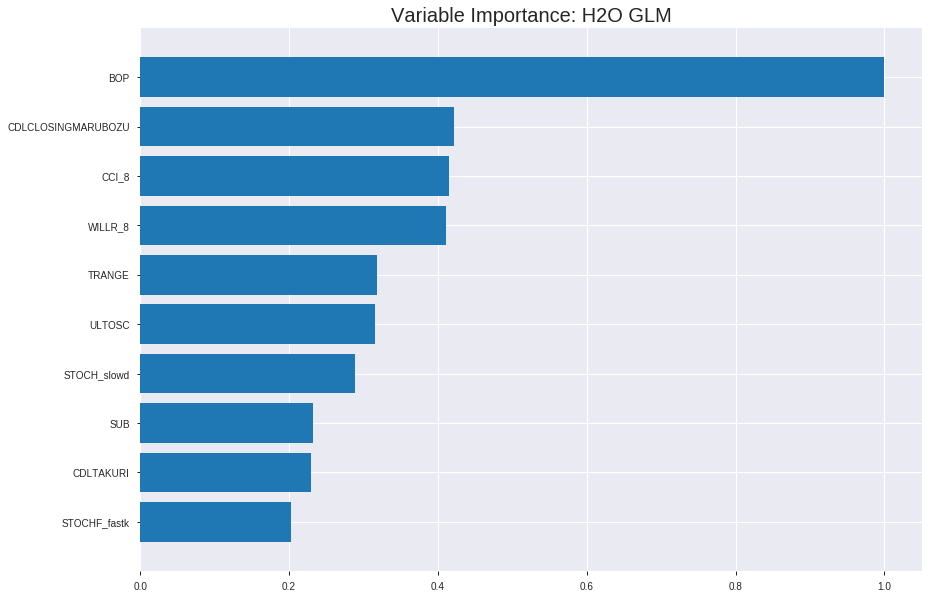

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_135438_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19260484017882867
RMSE: 0.43886767957874123
LogLoss: 0.5658620044882201
Null degrees of freedom: 4314
Residual degrees of freedom: 4264
Null deviance: 5970.536326910041
Residual deviance: 4883.38909873334
AIC: 4985.38909873334
AUC: 0.7754262916695744
pr_auc: 0.7416919792440291
Gini: 0.5508525833391489
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32165738634550833: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1043  1225  0.5401   (1225.0/2268.0)
1      213   1834  0.1041   (213.0/2047.0)
Total  1256  3059  0.3333   (1438.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.321657     0.718371  274
max f2                       0.155079     0.835272  348
max f0point5                 0.529377     0.695748  174
max accuracy                 0.529377     0.706373  174
max precision                0.95013      1         0
max recall                   0.0323826    1         393
max specificity              0.95013      1         0
max absolute_mcc             0.529377     0.410141  174
max min_per_class_accuracy   0.48569      0.699735  195
max mean_per_class_accuracy  0.475219     0.704931  200

Gains/Lift Table: Avg response rate: 47.44 %, avg score: 47.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.915823           1.96424   1.96424            0.931818         0.927447   0.931818                    0.927447            0.0200293       0.0200293                  96.4238   96.4238
    2        0.0201622                   0.89487            1.81383   1.8899             0.860465         0.904429   0.896552                    0.91607             0.0180752       0.0381045                  81.3829   88.9898
    3        0.0301275                   0.880301           1.86285   1.88095            0.883721         0.88816    0.892308                    0.906838            0.0185638       0.0566683                  86.2851   88.0951
    4        0.0400927                   0.868015           1.71578   1.8399             0.813953         0.874361   0.872832                    0.898766            0.0170982       0.0737665                  71.5784   83.9898
    5        0.0500579                   0.858881           1.76481   1.82495            0.837209         0.86366    0.865741                    0.891777            0.0175867       0.0913532                  76.4806   82.4949
    6        0.100116                    0.789763           1.84447   1.83471            0.875            0.824138   0.87037                     0.857958            0.0923302       0.183683                   84.4468   83.4708
    7        0.150174                    0.735137           1.52242   1.73061            0.722222         0.762132   0.820988                    0.826016            0.0762091       0.259893                   52.2418   73.0611
    8        0.2                         0.696733           1.54911   1.68539            0.734884         0.717321   0.799537                    0.798936            0.0771861       0.337079                   54.9108   68.5393
    9        0.300116                    0.628122           1.41019   1.59359            0.668981         0.661718   0.755985                    0.753162            0.141182        0.478261                   41.0188   59.3587
    10       0.4                         0.551192           1.25206   1.5083             0.593968         0.589684   0.715527                    0.71234             0.125061        0.603322                   25.2061   50.8305
    11       0.500116                    0.478422           1.08326   1.42322            0.513889         0.515137   0.675162                    0.672862            0.108451        0.711773                   8.32587   42.3217
    12       0.6                         0.393784           0.919483  1.33936            0.436195         0.437401   0.63538                     0.633664            0.0918417       0.803615                   -8.05174  33.9358
    13       0.699884                    0.327625           0.831447  1.26687            0.394432         0.36132    0.600993                    0.594797            0.0830484       0.886663                   -16.8553  26.6872
    14       0.8                         0.255725           0.575786  1.18039            0.273148         0.29108    0.559965                    0.556788            0.0576453       0.944309                   -42.4214  18.0386
    15       0.899884                    0.144451           0.386378  1.09225            0.183295         0.205298   0.518156                    0.517774            0.0385931       0.982902                   -61.3622  9.22537
    16       1                           0.00179281         0.170784  1                  0.0810185        0.0844542  0.474392                   



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19480862558096926
RMSE: 0.44137130126569085
LogLoss: 0.5732977870122756
Null degrees of freedom: 1232
Residual degrees of freedom: 1182
Null deviance: 1711.616831684033
Residual deviance: 1413.7523427722717
AIC: 1515.7523427722717
AUC: 0.7887183859050867
pr_auc: 0.7767882583025493
Gini: 0.5774367718101734
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26882885292617636: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      302  319  0.5137   (319.0/621.0)
1      72   540  0.1176   (72.0/612.0)
Total  374  859  0.3171   (391.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.268829     0.734194  281
max f2                       0.0622139    0.840915  376
max f0point5                 0.492745     0.731279  174
max accuracy                 0.422593     0.723439  208
max precision                0.921277     1         0
max recall                   0.0277246    1         392
max specificity              0.921277     1         0
max absolute_mcc             0.422593     0.446837  208
max min_per_class_accuracy   0.41944      0.71732   210
max mean_per_class_accuracy  0.422593     0.723371  208

Gains/Lift Table: Avg response rate: 49.64 %, avg score: 41.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.871752           1.70475   1.70475            0.846154         0.896135  0.846154                    0.896135            0.0179739       0.0179739                  70.4751   70.4751
    2        0.0202758                   0.858757           1.84681   1.77294            0.916667         0.86429   0.88                        0.88085             0.0179739       0.0359477                  84.6814   77.2941
    3        0.0300081                   0.834012           2.01471   1.85135            1                0.848046  0.918919                    0.870211            0.0196078       0.0555556                  101.471   85.1351
    4        0.0405515                   0.824534           2.01471   1.89382            1                0.828671  0.94                        0.85941             0.0212418       0.0767974                  101.471   89.3824
    5        0.0502839                   0.800687           2.01471   1.91722            1                0.811083  0.951613                    0.850057            0.0196078       0.0964052                  101.471   91.722
    6        0.100568                    0.718517           1.81973   1.86848            0.903226         0.753908  0.927419                    0.801983            0.0915033       0.187908                   81.9734   86.8477
    7        0.150041                    0.655754           1.48626   1.74245            0.737705         0.684073  0.864865                    0.763104            0.0735294       0.261438                   48.6258   74.2448
    8        0.200324                    0.618761           1.55977   1.69659            0.774194         0.638042  0.842105                    0.731712            0.0784314       0.339869                   55.9772   69.6594
    9        0.300081                    0.556728           1.42504   1.60632            0.707317         0.587802  0.797297                    0.683872            0.142157        0.482026                   42.5036   60.632
    10       0.399838                    0.488266           1.35952   1.54474            0.674797         0.524585  0.766734                    0.644131            0.135621        0.617647                   35.9517   54.4744
    11       0.500406                    0.412285           1.00735   1.43674            0.5              0.452948  0.713128                    0.605708            0.101307        0.718954                   0.735294  43.6743
    12       0.600162                    0.336693           0.851746  1.33951            0.422764         0.370061  0.664865                    0.56654             0.0849673       0.803922                   -14.8254  33.9507
    13       0.699919                    0.266586           0.802606  1.26298            0.398374         0.299015  0.626883                    0.52841             0.0800654       0.883987                   -19.7394  26.2985
    14       0.799676                    0.206116           0.58967   1.17899            0.292683         0.237912  0.585193                    0.492172            0.0588235       0.94281                    -41.033   17.8991
    15       0.899432                    0.125273           0.327594  1.08456            0.162602         0.16884   0.538323                    0.456311            0.0326797       0.97549                    -67.2406  8.45621
    16       1                           0.00426334         0.243714  1                  0.120968         0.069336  0.49635                     0.417394           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-24 13:54:39  0.000 sec   2            .2E2      50            1.3629518349190108  1.3680523096379398
     2019-08-24 13:54:39  0.023 sec   4            .12E2     51            1.3527191970256138  1.3580262824585247
     2019-08-24 13:54:39  0.045 sec   6            .76E1     51            1.3388011742434103  1.3442845992421333
     2019-08-24 13:54:39  0.071 sec   8            .47E1     51            1.320916398340153   1.326474638703203
     2019-08-24 13:54:39  0.096 sec   10           .29E1     51            1.29925325260136    1.3046739913481935
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-24 13:54:39  0.453 sec   39           .23E-2    51            1.1314137848496952  1.1467290730600062
     2019-08-24 13:54:39  0.466 sec   40           .14E-2    51            1.131227560177281   1.1471511331639273
     2019-08-24 13:54:39  0.483 sec   41           .9E-3     51            1.1311005396921148  1.1477330507879462
     2019-08-24 13:54:39  0.496 sec   42           .56E-3    51            1.1309975257769527  1.1485382866495046
     2019-08-24 13:54:39  0.509 sec   43           .35E-3    51            1.1309078123180871  1.1494814364037527


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6839546191247974)

('F1', 0.720626631853786)

('auc', 0.7520452155625658)

('logloss', 0.6144657996908958)

('mean_per_class_error', 0.31543638275499475)

('rmse', 0.45898375875433145)

('mse', 0.21066609080025434)

glm prediction progress: |████████████████████████████████████████████████| 100%


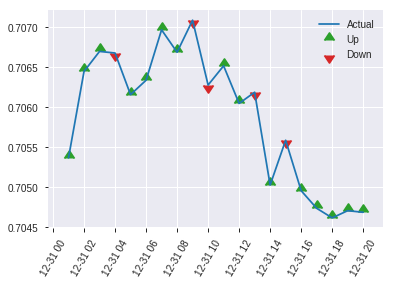


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21066609080025434
RMSE: 0.45898375875433145
LogLoss: 0.6144657996908958
Null degrees of freedom: 616
Residual degrees of freedom: 566
Null deviance: 855.2213378304502
Residual deviance: 758.2507968185653
AIC: 860.2507968185653
AUC: 0.7520452155625658
pr_auc: 0.7346455065543475
Gini: 0.5040904311251315
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21170554748366857: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      127  190  0.5994   (190.0/317.0)
1      24   276  0.08     (24.0/300.0)
Total  151  466  0.3468   (214.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.211706     0.720627  302
max f2                       0.0766155    0.837104  366
max f0point5                 0.526344     0.682271  124
max accuracy                 0.372963     0.683955  207
max precision                0.935338     1         0
max recall                   0.00339208   1         399
max specificity              0.935338     1         0
max absolute_mcc             0.211706     0.372747  302
max min_per_class_accuracy   0.378889     0.675079  203
max mean_per_class_accuracy  0.36808      0.684564  211

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 39.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.883167           1.76286   1.76286            0.857143         0.899742   0.857143                    0.899742            0.02            0.02                       76.2857   76.2857
    2        0.0210697                   0.85657            2.05667   1.89846            1                0.869129   0.923077                    0.885613            0.02            0.04                       105.667   89.8462
    3        0.0307942                   0.832651           2.05667   1.94842            1                0.84331    0.947368                    0.872254            0.02            0.06                       105.667   94.8421
    4        0.0405186                   0.815329           1.02833   1.7276             0.5              0.822717   0.84                        0.860366            0.01            0.07                       2.83333   72.76
    5        0.0502431                   0.798467           2.05667   1.79129            1                0.807964   0.870968                    0.850223            0.02            0.09                       105.667   79.129
    6        0.100486                    0.700854           1.85763   1.82446            0.903226         0.741499   0.887097                    0.795861            0.0933333       0.183333                   85.7634   82.4462
    7        0.150729                    0.627069           1.52591   1.72495            0.741935         0.666848   0.83871                     0.752857            0.0766667       0.26                       52.5914   72.4946
    8        0.200972                    0.587217           1.59226   1.69177            0.774194         0.607904   0.822581                    0.716618            0.08            0.34                       59.2258   69.1774
    9        0.299838                    0.516885           1.31492   1.56751            0.639344         0.546119   0.762162                    0.6604              0.13            0.47                       31.4918   56.7514
    10       0.400324                    0.4513             0.928817  1.40719            0.451613         0.480478   0.684211                    0.615237            0.0933333       0.563333                   -7.11828  40.7193
    11       0.50081                     0.377222           1.19419   1.36446            0.580645         0.413794   0.66343                     0.574818            0.12            0.683333                   19.4194   36.4455
    12       0.599676                    0.315939           0.876612  1.28403            0.42623          0.349903   0.624324                    0.537738            0.0866667       0.77                       -12.3388  28.4027
    13       0.700162                    0.246568           1.02833   1.24733            0.5              0.282396   0.606481                    0.501091            0.103333        0.873333                   2.83333   24.733
    14       0.799028                    0.178251           0.674317  1.17643            0.327869         0.214932   0.572008                    0.465684            0.0666667       0.94                       -32.5683  17.643
    15       0.899514                    0.0910026          0.33172   1.08207            0.16129          0.135399   0.526126                    0.428787            0.0333333       0.973333                   -66.828   8.20661
    16       1                           0.00339208         0.265376  1                  0.129032         0.0516594  0.486224                    0.39

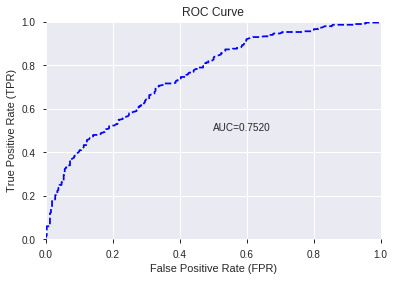

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


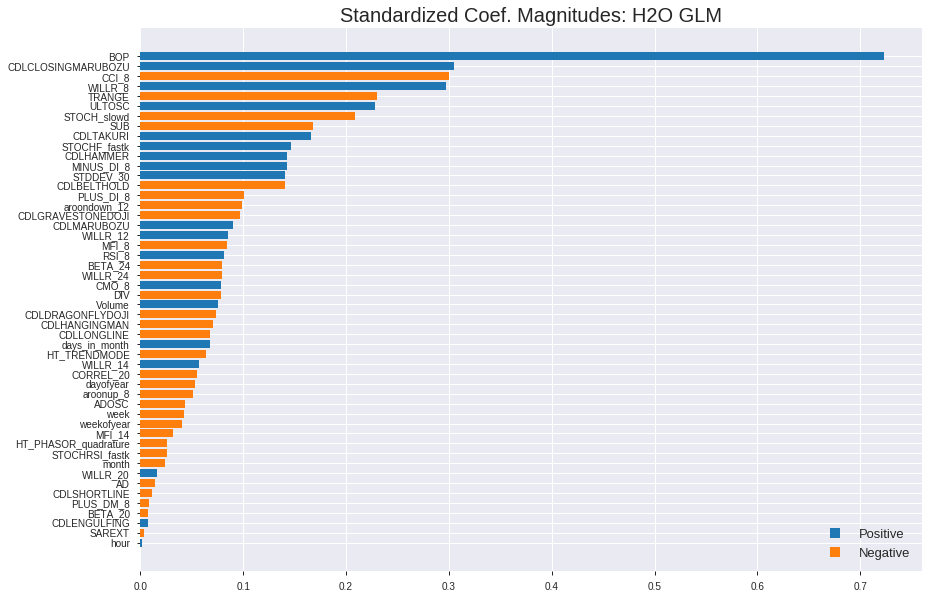

'log_likelihood'
--2019-08-24 13:54:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.84
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.84|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_135438_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_135438_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_b8e3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CCI_8',
 'WILLR_8',
 'TRANGE',
 'ULTOSC',
 'STOCH_slowd',
 'SUB',
 'CDLTAKURI',
 'STOCHF_fastk',
 'CDLHAMMER',
 'MINUS_DI_8',
 'STDDEV_30',
 'CDLBELTHOLD',
 'PLUS_DI_8',
 'aroondown_12',
 'CDLGRAVESTONEDOJI',
 'CDLMARUBOZU',
 'WILLR_12',
 'MFI_8',
 'RSI_8',
 'BETA_24',
 'WILLR_24',
 'CMO_8',
 'DIV',
 'Volume',
 'CDLDRAGONFLYDOJI',
 'CDLHANGINGMAN',
 'CDLLONGLINE',
 'days_in_month',
 'HT_TRENDMODE',
 'WILLR_14',
 'CORREL_20',
 'dayofyear',
 'aroonup_8',
 'ADOSC',
 'week',
 'weekofyear',
 'MFI_14',
 'HT_PHASOR_quadrature',
 'STOCHRSI_fastk',
 'month',
 'WILLR_20',
 'AD',
 'CDLSHORTLINE',
 'PLUS_DM_8',
 'BETA_20',
 'CDLENGULFING',
 'SAREXT',
 'hour']

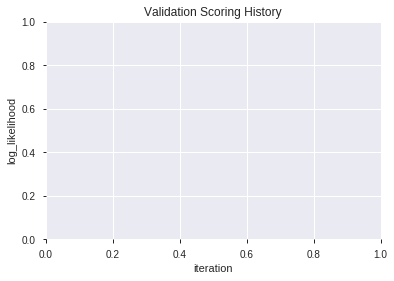

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_135545_model_2  0.751267  0.589369              0.318586  0.450746  0.203172
1  XGBoost_grid_1_AutoML_20190824_135545_model_6  0.748165  0.590637              0.330936  0.451292  0.203664
2               XGBoost_3_AutoML_20190824_135545  0.746283  0.591491              0.319033  0.451995  0.204299
3  XGBoost_grid_1_AutoML_20190824_135545_model_3  0.746099  0.591277              0.317723  0.451766  0.204092
4  XGBoost_grid_1_AutoML_20190824_135545_model_4  0.745252  0.591743              0.351230  0.452517  0.204772
5  XGBoost_grid_1_AutoML_20190824_135545_model_1  0.742003  0.597108              0.322902  0.454725  0.206775
6               XGBoost_1_AutoML_20190824_135545  0.738922  0.598030              0.350279  0.455057  0.207077
7               XGBoost_2_AutoML_20190824_135545  0.735762  0.599214              0.357629  0.456285  0.208196
8  XGBoost_grid_1_AutoML_20190824_135545_model_7  0.731761  0.606932              0.352213  0.458628  0.210340
9  XGBoost_grid_1_AutoML_20190824_135545_model_5  0.728917  0.612125              0.352839  0.461231  0.212734

variable  relative_importance  scaled_importance  percentage
0                    BOP          5925.828125           1.000000    0.335784
1           STOCHF_fastk          1059.802612           0.178845    0.060053
2                    DIV          1025.320923           0.173026    0.058099
3                   hour           634.000244           0.106989    0.035925
4     CDLCLOSINGMARUBOZU           601.832703           0.101561    0.034103
5                  CCI_8           543.124329           0.091654    0.030776
6              STDDEV_30           503.384766           0.084948    0.028524
7                 TRANGE           483.560608           0.081602    0.027401
8         STOCHRSI_fastk           483.149933           0.081533    0.027377
9              aroonup_8           427.676422           0.072172    0.024234
10            MINUS_DI_8           378.921234           0.063944    0.021471
11               WILLR_8           333.024719           0.056199    0.018871
12                    AD           327.879944           0.055331    0.018579
13               BETA_20           310.427094           0.052385    0.017590
14             dayofyear           308.864532           0.052122    0.017502
15             PLUS_DM_8           307.857971           0.051952    0.017445
16                SAREXT           303.947144           0.051292    0.017223
17                Volume           259.196594           0.043740    0.014687
18             CDLHAMMER           248.976517           0.042015    0.014108
19               BETA_24           241.732422           0.040793    0.013698
20  HT_PHASOR_quadrature           240.543549           0.040592    0.013630
21                 MFI_8           221.623001           0.037399    0.012558
22                ULTOSC           218.675629           0.036902    0.012391
23                 ADOSC           213.454681           0.036021    0.012095
24           STOCH_slowd           202.203384           0.034122    0.011458
25             PLUS_DI_8           200.511063           0.033837    0.011362
26          aroondown_12           196.292358           0.033125    0.011123
27                 CMO_8           189.374802           0.031958    0.010731
28              WILLR_12           177.072693           0.029882    0.010034
29              WILLR_14           157.599899           0.026595    0.008930
30                MFI_14           153.311844           0.025872    0.008687
31              WILLR_20           148.760498           0.025104    0.008429
32                   SUB           120.681793           0.020365    0.006838
33              WILLR_24            98.405273           0.016606    0.005576
34          CDLSHORTLINE            94.926643           0.016019    0.005379
35     CDLGRAVESTONEDOJI            92.065186           0.015536    0.005217
36             CDLTAKURI            41.636551           0.007026    0.002359
37             CORREL_20            36.726868           0.006198    0.002081
38           CDLBELTHOLD            34.010742           0.005739    0.001927
39                 RSI_8            19.551460           0.003299    0.001108
40          CDLENGULFING            16.433407           0.002773    0.000931
41         days_in_month            16.284660           0.002748    0.000923
42          HT_TRENDMODE            12.177052           0.002055    0.000690
43           CDLLONGLINE            11.349426           0.001915    0.000643
44                  week            10.305758           0.001739    0.000584
45      CDLDRAGONFLYDOJI             8.816990           0.001488    0.000500
46                 month             4.095464           0.000691    0.000232
47            weekofyear             2.325195           0.000392    0.000132

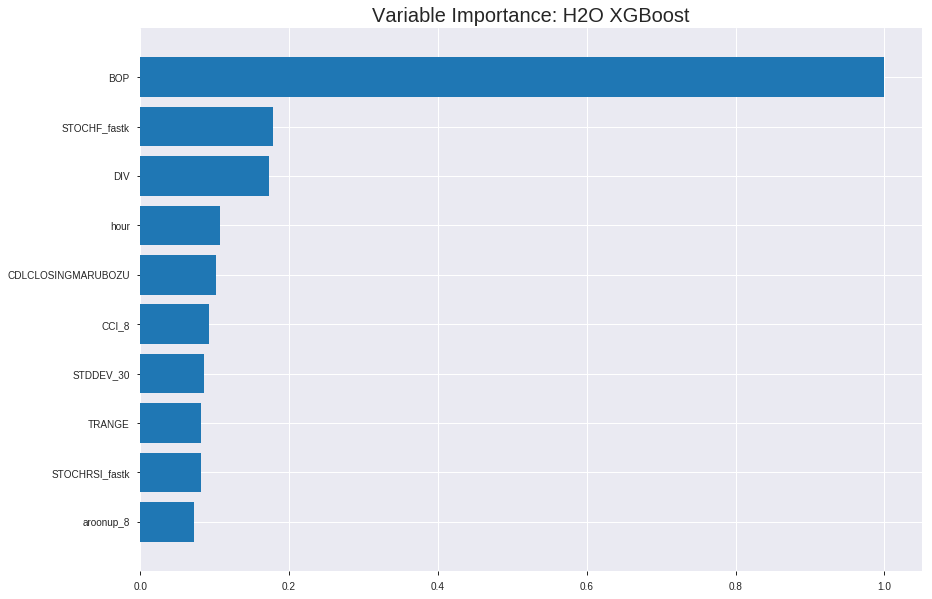

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_135545_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16222191185726118
RMSE: 0.40276781382983073
LogLoss: 0.49515042770427
Mean Per-Class Error: 0.23426688430352327
AUC: 0.8561661406678505
pr_auc: 0.8457254907051983
Gini: 0.7123322813357009
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41120289638638496: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1429  839   0.3699   (839.0/2268.0)
1      242   1805  0.1182   (242.0/2047.0)
Total  1671  2644  0.2505   (1081.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411203     0.769559  236
max f2                       0.20919      0.857228  326
max f0point5                 0.590843     0.775194  144
max accuracy                 0.497287     0.765469  192
max precision                0.935491     1         0
max recall                   0.0906596    1         384
max specificity              0.935491     1         0
max absolute_mcc             0.453724     0.532784  215
max min_per_class_accuracy   0.501009     0.764109  190
max mean_per_class_accuracy  0.497287     0.765733  192

Gains/Lift Table: Avg response rate: 47.44 %, avg score: 47.37 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.908307           2.10796    2.10796            1                0.918272  1                           0.918272            0.0214949       0.0214949                  110.796   110.796
    2        0.0201622                   0.88413            2.10796    2.10796            1                0.897165  1                           0.90784             0.0210064       0.0425012                  110.796   110.796
    3        0.0301275                   0.856608           2.10796    2.10796            1                0.870226  1                           0.895398            0.0210064       0.0635076                  110.796   110.796
    4        0.0400927                   0.841454           2.10796    2.10796            1                0.84886   1                           0.883831            0.0210064       0.0845139                  110.796   110.796
    5        0.0500579                   0.82205            1.9609     2.07869            0.930233         0.831413  0.986111                    0.873396            0.0195408       0.104055                   96.0896   107.869
    6        0.100116                    0.760681           2.02013    2.04941            0.958333         0.790321  0.972222                    0.831858            0.101124        0.205178                   102.013   104.941
    7        0.150174                    0.720007           1.87374    1.99085            0.888889         0.738933  0.944444                    0.800883            0.0937958       0.298974                   87.3745   99.0854
    8        0.2                         0.686572           1.73539    1.92721            0.823256         0.702448  0.914253                    0.77636             0.086468        0.385442                   73.5393   92.7211
    9        0.300116                    0.621468           1.58097    1.81171            0.75             0.653537  0.859459                    0.735387            0.15828         0.543723                   58.0972   81.1709
    10       0.4                         0.562618           1.24228    1.66952            0.589327         0.592163  0.792005                    0.699623            0.124084        0.667807                   24.228    66.9516
    11       0.500116                    0.48991            1.09302    1.55411            0.518519         0.527577  0.737257                    0.665182            0.109428        0.777235                   9.30178   55.411
    12       0.6                         0.419587           0.924374   1.44928            0.438515         0.455293  0.687524                    0.630241            0.0923302       0.869565                   -7.56265  44.9275
    13       0.699884                    0.335175           0.635812   1.33318            0.301624         0.378689  0.63245                     0.594341            0.0635076       0.933073                   -36.4188  33.3182
    14       0.8                         0.231629           0.400123   1.21641            0.189815         0.286419  0.577057                    0.555806            0.0400586       0.973131                   -59.9877  21.6414
    15       0.899884                    0.141964           0.249434   1.10908            0.118329         0.185362  0.52614                     0.514688            0.0249145       0.998046                   -75.0566  10.9083
    16       1                           0.050306           0.0195182  1                  0.00925926       0.105166  0.474392                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.18760225784381396
RMSE: 0.4331307629848219
LogLoss: 0.5563466849039489
Mean Per-Class Error: 0.25959079283887476
AUC: 0.7960213339227263
pr_auc: 0.7781634874068072
Gini: 0.5920426678454527
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44644027203321457: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      418  203  0.3269   (203.0/621.0)
1      127  485  0.2075   (127.0/612.0)
Total  545  688  0.2676   (330.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.44644      0.746154  222
max f2                       0.183136     0.847771  349
max f0point5                 0.501982     0.740988  192
max accuracy                 0.501982     0.74047   192
max precision                0.922308     1         0
max recall                   0.0878116    1         389
max specificity              0.922308     1         0
max absolute_mcc             0.501982     0.480977  192
max min_per_class_accuracy   0.488034     0.736928  199
max mean_per_class_accuracy  0.495324     0.740409  195

Gains/Lift Table: Avg response rate: 49.64 %, avg score: 46.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.898482           1.85973   1.85973            0.923077         0.908584  0.923077                    0.908584            0.0196078       0.0196078                  85.9729   85.9729
    2        0.0202758                   0.869635           1.67892   1.77294            0.833333         0.887255  0.88                        0.898346            0.0163399       0.0359477                  67.8922   77.2941
    3        0.0300081                   0.842595           2.01471   1.85135            1                0.859836  0.918919                    0.885856            0.0196078       0.0555556                  101.471   85.1351
    4        0.0405515                   0.828815           1.85973   1.85353            0.923077         0.835823  0.92                        0.872847            0.0196078       0.0751634                  85.9729   85.3529
    5        0.0502839                   0.807921           2.01471   1.88472            1                0.816355  0.935484                    0.861913            0.0196078       0.0947712                  101.471   88.4725
    6        0.100568                    0.723639           1.65726   1.77099            0.822581         0.761532  0.879032                    0.811723            0.0833333       0.178105                   65.7258   77.0991
    7        0.150041                    0.684996           1.75048   1.76423            0.868852         0.701888  0.875676                    0.775507            0.0866013       0.264706                   75.0482   76.4229
    8        0.200324                    0.655125           1.49478   1.69659            0.741935         0.669828  0.842105                    0.74898             0.0751634       0.339869                   49.4782   69.6594
    9        0.300081                    0.605105           1.35952   1.58454            0.674797         0.629508  0.786486                    0.709264            0.135621        0.47549                    35.9517   58.4539
    10       0.399838                    0.551546           1.40866   1.54066            0.699187         0.577287  0.764706                    0.676337            0.140523        0.616013                   40.8656   54.0657
    11       0.500406                    0.485823           1.23482   1.47919            0.612903         0.521988  0.734198                    0.645317            0.124183        0.740196                   23.482    47.9192
    12       0.600162                    0.415973           0.786227  1.36401            0.390244         0.449314  0.677027                    0.612738            0.0784314       0.818627                   -21.3773  36.401
    13       0.699919                    0.339241           0.60605   1.25598            0.300813         0.381453  0.623407                    0.579774            0.0604575       0.879085                   -39.395   25.5981
    14       0.799676                    0.245254           0.687948  1.18512            0.341463         0.299564  0.588235                    0.544819            0.0686275       0.947712                   -31.2052  18.5121
    15       0.899432                    0.154026           0.343974  1.09183            0.170732         0.20172   0.54193                     0.506765            0.0343137       0.982026                   -65.6026  9.18289
    16       1                           0.0612598          0.178724  1                  0.0887097        0.110569  0.49635                     0.466921          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 13:55:55  1.647 sec   0                  0.5              0.693147            0.5             0                  1                0.525608                         0.5                0.693147              0.5               0                    1                  0.50365
    2019-08-24 13:55:55  1.738 sec   5                  0.479501         0.652785            0.794558        0.726948           1.93588          0.285747                         0.482273           0.658149              0.773798          0.729262             1.77294            0.293593
    2019-08-24 13:55:55  1.804 sec   10                 0.464362         0.623312            0.799246        0.741007           2.02013          0.282039                         0.46959            0.63329               0.77758           0.7357               1.81324            0.289538
    2019-08-24 13:55:56  1.876 sec   15                 0.452948         0.600833            0.802819        0.751865           2.00078          0.276477                         0.459762           0.61385               0.781915          0.750685             1.8708             0.286294
    2019-08-24 13:55:56  1.960 sec   20                 0.444842         0.584444            0.806582        0.764648           2.03268          0.276709                         0.4535             0.601056              0.783577          0.760263             1.85973            0.287916
    2019-08-24 13:55:56  2.049 sec   25                 0.438756         0.571751            0.809945        0.773249           2.06112          0.28343                          0.448883           0.591388              0.784562          0.762441             1.85973            0.27575
    2019-08-24 13:55:56  2.127 sec   30                 0.433763         0.561139            0.813834        0.78485            2.10796          0.28482                          0.445927           0.584955              0.785011          0.76934              1.85973            0.288727
    2019-08-24 13:55:56  2.215 sec   35                 0.429651         0.552213            0.817241        0.793774           2.10796          0.281344                         0.443074           0.578724              0.786336          0.770152             1.70475            0.283861
    2019-08-24 13:55:56  2.300 sec   40                 0.426212         0.544651            0.820985        0.800261           2.10796          0.274855                         0.441435           0.574951              0.78665           0.771276             1.72689            0.280616
    2019-08-24 13:55:56  2.385 sec   45                 0.423363         0.538352            0.824128        0.805653           2.10796          0.276246                         0.440097           0.57197               0.787737          0.773211             1.85973            0.278183
    2019-08-24 13:55:56  2.474 sec   50                 0.420312         0.531872            0.828574        0.812798           2.10796          0.271379                         0.438471           0.568631              0.790387          0.774121             1.70475            0.276561
    2019-08-24 13:55:56  2.568 sec   55                 0.418085         0.527042            0.831597        0.816536           2.10796          0.267671                         0.437788           0.566955              0.790996          0.7

Variable Importances: 


variable            relative_importance    scaled_importance       percentage
------------------  ---------------------  ----------------------  ----------------------
BOP                 5925.828125            1.0                     0.3357842568457319
STOCHF_fastk        1059.8026123046875     0.1788446424616285      0.06005321535981855
DIV                 1025.3209228515625     0.17302576133214503     0.058099326684081284
hour                634.000244140625       0.10698930694022196     0.035925324921362335
CDLCLOSINGMARUBOZU  601.8327026367188      0.10156094472225664     0.0341025663481134
---                 ---                    ---                     ---
CDLLONGLINE         11.34942626953125      0.0019152472920451519   0.0006431098886351817
week                10.305757522583008     0.0017391252842965316   0.000583970891149133
CDLDRAGONFLYDOJI    8.81698989868164       0.001487891601426027    0.0004996105756518443
month               4.095463752746582      0.0006911209144707655   0.00023206752265610863
weekofyear          2.3251953125           0.00039238318483967167  0.0001317560961201506


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6952998379254457)

('F1', 0.7260273972602739)

('auc', 0.751267087276551)

('logloss', 0.5893694006967144)

('mean_per_class_error', 0.3040378548895899)

('rmse', 0.4507462807315254)

('mse', 0.2031722095933031)

xgboost prediction progress: |████████████████████████████████████████████| 100%


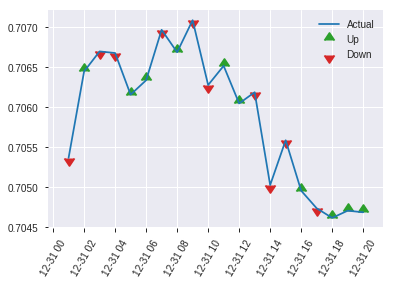


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2031722095933031
RMSE: 0.4507462807315254
LogLoss: 0.5893694006967144
Mean Per-Class Error: 0.3040378548895899
AUC: 0.751267087276551
pr_auc: 0.7248581320396342
Gini: 0.502534174553102
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33562493324279785: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      152  165  0.5205   (165.0/317.0)
1      35   265  0.1167   (35.0/300.0)
Total  187  430  0.3241   (200.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.335625     0.726027  275
max f2                       0.176558     0.848624  352
max f0point5                 0.445584     0.683544  208
max accuracy                 0.445584     0.6953    208
max precision                0.914586     1         0
max recall                   0.0797217    1         395
max specificity              0.914586     1         0
max absolute_mcc             0.361484     0.402318  258
max min_per_class_accuracy   0.459102     0.684543  197
max mean_per_class_accuracy  0.445584     0.695962  208

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 44.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.898714           2.05667   2.05667            1                0.905669  1                           0.905669            0.0233333       0.0233333                  105.667   105.667
    2        0.0210697                   0.867739           1.71389   1.89846            0.833333         0.878745  0.923077                    0.893242            0.0166667       0.04                       71.3889   89.8462
    3        0.0307942                   0.818237           2.05667   1.94842            1                0.843431  0.947368                    0.877512            0.02            0.06                       105.667   94.8421
    4        0.0405186                   0.793297           1.71389   1.89213            0.833333         0.809592  0.92                        0.861212            0.0166667       0.0766667                  71.3889   89.2133
    5        0.0502431                   0.769723           2.05667   1.92398            1                0.781124  0.935484                    0.845711            0.02            0.0966667                  105.667   92.3978
    6        0.100486                    0.680035           1.52591   1.72495            0.741935         0.716626  0.83871                     0.781169            0.0766667       0.173333                   52.5914   72.4946
    7        0.150729                    0.645366           1.52591   1.6586             0.741935         0.665815  0.806452                    0.742717            0.0766667       0.25                       52.5914   65.8602
    8        0.200972                    0.623377           1.32688   1.57567            0.645161         0.633925  0.766129                    0.715519            0.0666667       0.316667                   32.6882   57.5672
    9        0.299838                    0.562295           1.24749   1.46746            0.606557         0.590181  0.713514                    0.674191            0.123333        0.44                       24.7486   46.7459
    10       0.400324                    0.511176           1.19419   1.39887            0.580645         0.535538  0.680162                    0.639388            0.12            0.56                       19.4194   39.8866
    11       0.50081                     0.457881           1.32688   1.38442            0.645161         0.481891  0.673139                    0.607787            0.133333        0.693333                   32.6882   38.4423
    12       0.599676                    0.40013            0.97776   1.31738            0.47541          0.425662  0.640541                    0.577761            0.0966667       0.79                       -2.22404  31.7378
    13       0.700162                    0.331532           0.928817  1.26161            0.451613         0.365468  0.613426                    0.547293            0.0933333       0.883333                   -7.11828  26.1613
    14       0.799028                    0.240239           0.539454  1.17226            0.262295         0.292452  0.56998                     0.515761            0.0533333       0.936667                   -46.0546  17.2258
    15       0.899514                    0.15416            0.497581  1.09689            0.241935         0.192854  0.533333                    0.479688            0.05            0.986667                   -50.2419  9.68889
    16       1                           0.0536425          0.132688  1                  0.0645161        0.11086   0.486224                    0.442626         

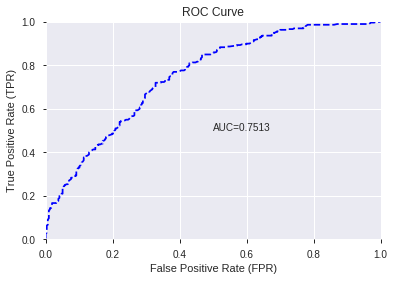

This function is available for GLM models only


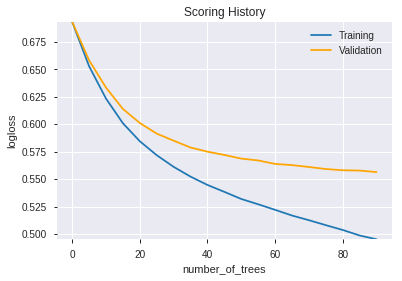

--2019-08-24 13:56:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.20.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.20.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.jav

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_135545_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_135545_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_b8e3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'DIV',
 'hour',
 'CDLCLOSINGMARUBOZU',
 'CCI_8',
 'STDDEV_30',
 'TRANGE',
 'STOCHRSI_fastk',
 'aroonup_8',
 'MINUS_DI_8',
 'WILLR_8',
 'AD',
 'BETA_20',
 'dayofyear',
 'PLUS_DM_8',
 'SAREXT',
 'Volume',
 'CDLHAMMER',
 'BETA_24',
 'HT_PHASOR_quadrature',
 'MFI_8',
 'ULTOSC',
 'ADOSC',
 'STOCH_slowd',
 'PLUS_DI_8',
 'aroondown_12',
 'CMO_8',
 'WILLR_12',
 'WILLR_14',
 'MFI_14',
 'WILLR_20',
 'SUB',
 'WILLR_24',
 'CDLSHORTLINE',
 'CDLGRAVESTONEDOJI',
 'CDLTAKURI',
 'CORREL_20',
 'CDLBELTHOLD',
 'RSI_8',
 'CDLENGULFING',
 'days_in_month',
 'HT_TRENDMODE',
 'CDLLONGLINE',
 'week',
 'CDLDRAGONFLYDOJI',
 'month',
 'weekofyear']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 939] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


80

['Volume',
 'BOP',
 'aroondown_8',
 'CCI_8',
 'CMO_8',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'aroondown_12',
 'CCI_12',
 'CMO_12',
 'MINUS_DI_12',
 'MINUS_DM_12',
 'MOM_12',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'MOM_14',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'CMO_20',
 'MOM_20',
 'ROC_20',
 'ROCP_20',
 'ROCR_20',
 'ROCR100_20',
 'RSI_20',
 'WILLR_20',
 'CCI_24',
 'CMO_24',
 'MOM_24',
 'ROC_24',
 'ROCP_24',
 'ROCR_24',
 'ROCR100_24',
 'RSI_24',
 'WILLR_24',
 'CCI_30',
 'CMO_30',
 'RSI_30',
 'WILLR_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDL3INSIDE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'CDLTAKURI',
 'LINEA

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_135722_model_5  0.760163  0.588997              0.319269  0.448094  0.200788
1  DeepLearning_grid_1_AutoML_20190824_135722_model_9  0.754269  0.596350              0.309837  0.448364  0.201030
2  DeepLearning_grid_1_AutoML_20190824_135722_model_6  0.753297  0.595231              0.315074  0.449168  0.201751
3  DeepLearning_grid_1_AutoML_20190824_135722_model_7  0.748002  0.632584              0.319805  0.455451  0.207436
4  DeepLearning_grid_1_AutoML_20190824_135722_model_8  0.745521  0.599994              0.335310  0.452347  0.204618
5               DeepLearning_1_AutoML_20190824_135722  0.737319  0.613979              0.334537  0.460628  0.212178
6  DeepLearning_grid_1_AutoML_20190824_135722_model_3  0.731441  0.678051              0.323764  0.462299  0.213720
7  DeepLearning_grid_1_AutoML_20190824_135722_model_4  0.721740  0.644300              0.363254  0.467741  0.218782
8  DeepLearning_grid_1_AutoML_20190824_135722_model_2  0.717103  0.663103              0.341025  0.470154  0.221045
9  DeepLearning_grid_1_AutoML_20190824_135722_model_1  0.668691  0.945839              0.395931  0.522085  0.272573

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.033600
1   CDLCLOSINGMARUBOZU             0.985701           0.985701    0.033120
2               TRANGE             0.676908           0.676908    0.022744
3                  DIV             0.675230           0.675230    0.022688
4                  SUB             0.628665           0.628665    0.021123
..                 ...                  ...                ...         ...
75          ROCR100_14             0.265912           0.265912    0.008935
76              RSI_12             0.264005           0.264005    0.008871
77              CMO_12             0.255584           0.255584    0.008588
78              CMO_14             0.252733           0.252733    0.008492
79              RSI_14             0.244973           0.244973    0.008231

[80 rows x 4 columns]

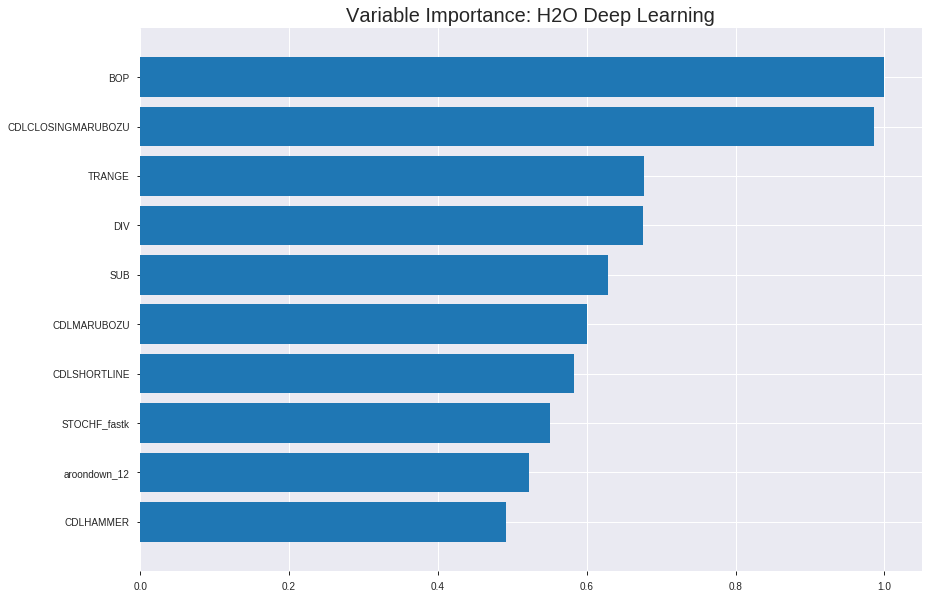

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_135722_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19637509334381956
RMSE: 0.44314229469079064
LogLoss: 0.5719085530563762
Mean Per-Class Error: 0.2943907891188464
AUC: 0.7831630191384302
pr_auc: 0.7559147182175342
Gini: 0.5663260382768605
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48265417070819183: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1061  1207  0.5322   (1207.0/2268.0)
1      227   1820  0.1109   (227.0/2047.0)
Total  1288  3027  0.3323   (1434.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.482654     0.717383  233
max f2                       0.311875     0.843348  304
max f0point5                 0.60904      0.700322  154
max accuracy                 0.571627     0.704287  176
max precision                0.988313     1         0
max recall                   0.0560302    1         384
max specificity              0.988313     1         0
max absolute_mcc             0.53934      0.411364  198
max min_per_class_accuracy   0.550935     0.698413  190
max mean_per_class_accuracy  0.53934      0.705609  198

Gains/Lift Table: Avg response rate: 47.44 %, avg score: 53.90 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.968455           2.01215    2.01215            0.954545         0.977601  0.954545                    0.977601            0.0205178       0.0205178                  101.215   101.215
    2        0.0201622                   0.952163           2.00992    2.01105            0.953488         0.961084  0.954023                    0.969438            0.0200293       0.0405471                  100.992   101.105
    3        0.0301275                   0.936068           1.9609     1.99446            0.930233         0.943862  0.946154                    0.960978            0.0195408       0.0600879                  96.0896   99.4457
    4        0.0400927                   0.920082           1.81383    1.94956            0.860465         0.928536  0.924855                    0.952914            0.0180752       0.0781632                  81.3829   94.9561
    5        0.0500579                   0.90399            1.86285    1.9323             0.883721         0.911948  0.916667                    0.944759            0.0185638       0.0967269                  86.2851   93.2299
    6        0.100116                    0.803012           1.80543    1.86887            0.856481         0.851186  0.886574                    0.897973            0.0903762       0.187103                   80.5431   86.8865
    7        0.150174                    0.743432           1.63953    1.79242            0.777778         0.771471  0.850309                    0.855805            0.0820713       0.269174                   63.9527   79.2419
    8        0.2                         0.694398           1.48048    1.7147             0.702326         0.717081  0.813441                    0.821245            0.0737665       0.342941                   48.0476   71.4704
    9        0.300116                    0.624318           1.44922    1.62614            0.6875           0.654038  0.771429                    0.765466            0.14509         0.488031                   44.9224   62.6143
    10       0.4                         0.580279           1.18848    1.51685            0.563805         0.600088  0.719583                    0.724169            0.11871         0.606742                   18.848    51.6854
    11       0.500116                    0.547197           1.05398    1.42419            0.5              0.563722  0.675626                    0.69205             0.10552         0.712262                   5.39814   42.4194
    12       0.6                         0.518539           0.968391   1.34831            0.459397         0.532621  0.639629                    0.665509            0.0967269       0.808989                   -3.16087  34.8315
    13       0.699884                    0.482291           0.777648   1.26687            0.36891          0.50258   0.600993                    0.642257            0.0776746       0.886663                   -22.2352  26.6872
    14       0.8                         0.401942           0.63922    1.18832            0.303241         0.448194  0.563731                    0.617971            0.0639961       0.95066                    -36.078   18.8324
    15       0.899884                    0.236879           0.39616    1.1004             0.187935         0.326808  0.522019                    0.585653            0.0395701       0.99023                    -60.384   10.0397
    16       1                           0.00356605         0.0975909  1                  0.0462963        0.119983  0.474392                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20008270986039076
RMSE: 0.44730605837657816
LogLoss: 0.583380982023422
Mean Per-Class Error: 0.29325329165482616
AUC: 0.7768752696999358
pr_auc: 0.7629714484202547
Gini: 0.5537505393998716
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5058495280513675: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      335  286  0.4605   (286.0/621.0)
1      90   522  0.1471   (90.0/612.0)
Total  425  808  0.3049   (376.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.50585      0.735211  224
max f2                       0.225871     0.84361   334
max f0point5                 0.598514     0.714286  153
max accuracy                 0.544517     0.706407  193
max precision                0.988498     1         0
max recall                   0.0759427    1         374
max specificity              0.988498     1         0
max absolute_mcc             0.537589     0.415168  198
max min_per_class_accuracy   0.55316      0.70098   187
max mean_per_class_accuracy  0.537589     0.706747  198

Gains/Lift Table: Avg response rate: 49.64 %, avg score: 53.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.95866            1.70475   1.70475            0.846154         0.971282  0.846154                    0.971282            0.0179739       0.0179739                  70.4751   70.4751
    2        0.0202758                   0.939397           1.84681   1.77294            0.916667         0.950842  0.88                        0.961471            0.0179739       0.0359477                  84.6814   77.2941
    3        0.0300081                   0.919132           1.67892   1.74245            0.833333         0.929609  0.864865                    0.951137            0.0163399       0.0522876                  67.8922   74.2448
    4        0.0405515                   0.903353           1.85973   1.77294            0.923077         0.90914   0.88                        0.940218            0.0196078       0.0718954                  85.9729   77.2941
    5        0.0502839                   0.879669           2.01471   1.81973            1                0.894123  0.903226                    0.931296            0.0196078       0.0915033                  101.471   81.9734
    6        0.100568                    0.770595           1.91722   1.86848            0.951613         0.824927  0.927419                    0.878111            0.0964052       0.187908                   91.722    86.8477
    7        0.150041                    0.718998           1.45323   1.73156            0.721311         0.74485   0.859459                    0.834171            0.0718954       0.259804                   45.323    73.1558
    8        0.200324                    0.677628           1.52728   1.68028            0.758065         0.69544   0.834008                    0.799348            0.0767974       0.336601                   52.7277   68.0281
    9        0.300081                    0.622953           1.47418   1.61176            0.731707         0.645747  0.8                         0.748286            0.147059        0.48366                    47.4175   61.1765
    10       0.399838                    0.584577           1.1302    1.49162            0.560976         0.602039  0.740365                    0.711798            0.112745        0.596405                   13.0201   49.1618
    11       0.500406                    0.551331           1.07234   1.40736            0.532258         0.567215  0.698541                    0.682741            0.107843        0.704248                   7.23435   40.7355
    12       0.600162                    0.520743           1.01554   1.34223            0.504065         0.535052  0.666216                    0.658193            0.101307        0.805556                   1.55428   34.223
    13       0.699919                    0.488027           0.720708  1.25365            0.357724         0.505873  0.622248                    0.636483            0.0718954       0.877451                   -27.9292  25.3647
    14       0.799676                    0.418651           0.507771  1.1606             0.252033         0.457918  0.576065                    0.614208            0.0506536       0.928105                   -49.2229  16.0601
    15       0.899432                    0.23754            0.491392  1.08638            0.243902         0.340758  0.539225                    0.583879            0.0490196       0.977124                   -50.8608  8.63788
    16       1                           0.00544898         0.227467  1                  0.112903         0.124901  0.49635                     0.537721          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 14:05:43  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 14:05:45  3 min  3.589 sec  1036 obs/sec      0.511703  1             2208       0.456535         0.602931            0.164111       0.745433        0.703406           1.82051          0.340209                         0.455065           0.601744              0.17162          0.762183          0.75665              1.85973            0.311436
    2019-08-24 14:06:03  3 min 21.456 sec  2013 obs/sec      8.53395   17            36824      0.450771         0.587778            0.185084       0.762573        0.733518           1.96424          0.338355                         0.450287           0.590895              0.188924         0.770201          0.75824              1.70475            0.308191
    2019-08-24 14:06:20  3 min 39.214 sec  2210 obs/sec      17.5949   35            75922      0.443142         0.571909            0.212434       0.783163        0.755915           2.01215          0.332329                         0.447306           0.583381              0.199627         0.776875          0.762971             1.70475            0.304947
    2019-08-24 14:06:38  3 min 56.954 sec  2322 obs/sec      27.1212   54            117028     0.441369         0.568398            0.218724       0.790483        0.76696            2.06005          0.310776                         0.448656           0.586977              0.194788         0.773499          0.758261             1.70475            0.304136
    2019-08-24 14:06:56  4 min 14.340 sec  2392 obs/sec      36.6306   73            158061     0.435747         0.553023            0.238499       0.790063        0.769038           2.06005          0.332561                         0.448271           0.587459              0.196171         0.767496          0.751814             1.70475            0.318735
    2019-08-24 14:07:13  4 min 31.459 sec  2445 obs/sec      46.1752   92            199246     0.429434         0.542614            0.260404       0.808506        0.784235           2.01215          0.306605                         0.448014           0.585025              0.197092         0.768295          0.749942             1.85973            0.302514
    2019-08-24 14:07:14  4 min 33.364 sec  2443 obs/sec      46.1752   92            199246     0.443142         0.571909            0.212434       0.783163        0.755915           2.01215          0.332329                         0.447306           0.583381              0.199627         0.776875          0.762971             1.70475            0.304947

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.03360000550186247
CDLCLOSINGMARUBOZU  0.9857005476951599     0.9857005476951599   0.03311954382574623
TRANGE              0.6769076585769653     0.6769076585769653   0.02274410105243888
DIV                 0.6752300262451172     0.6752300262451172   0.02268773259685868
SUB                 0.6286650896072388     0.6286650896072388   0.021123150469632087
---                 ---                    ---                  ---
ROCR100_14          0.26591169834136963    0.26591169834136963  0.008934634527279614
RSI_12              0.2640049457550049     0.2640049457550049   0.008870567629887067
CMO_12              0.2555839717388153     0.2555839717388153   0.008587622856612057
CMO_14              0.25273266434669495    0.25273266434669495  0.008491818912549312
RSI_14              0.24497294425964355    0.24497294425964355  0.008231092274931472


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6871961102106969)

('F1', 0.7323568575233023)

('auc', 0.7601629863301788)

('logloss', 0.5889971927979849)

('mean_per_class_error', 0.3078128286014721)

('rmse', 0.4480935940470994)

('mse', 0.20078786902604676)

deeplearning prediction progress: |███████████████████████████████████████| 100%


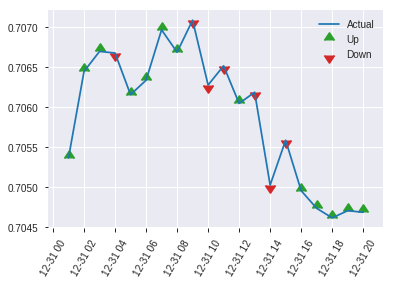


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20078786902604676
RMSE: 0.4480935940470994
LogLoss: 0.5889971927979849
Mean Per-Class Error: 0.3078128286014721
AUC: 0.7601629863301788
pr_auc: 0.7273200045921365
Gini: 0.5203259726603575
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4665526049510629: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      141  176  0.5552   (176.0/317.0)
1      25   275  0.0833   (25.0/300.0)
Total  166  451  0.3258   (201.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.466553     0.732357  269
max f2                       0.328854     0.849275  324
max f0point5                 0.540908     0.677083  194
max accuracy                 0.540908     0.687196  194
max precision                0.870243     0.921053  33
max recall                   0.0160506    1         397
max specificity              0.98965      0.996845  0
max absolute_mcc             0.490648     0.410451  249
max min_per_class_accuracy   0.541657     0.681388  193
max mean_per_class_accuracy  0.490648     0.692187  249

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 52.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.960608           1.46905   1.46905            0.714286         0.971497  0.714286                    0.971497            0.0166667       0.0166667                  46.9048   46.9048
    2        0.0210697                   0.948917           1.71389   1.58205            0.833333         0.955199  0.769231                    0.963975            0.0166667       0.0333333                  71.3889   58.2051
    3        0.0307942                   0.934344           2.05667   1.73193            1                0.944675  0.842105                    0.95788             0.02            0.0533333                  105.667   73.193
    4        0.0405186                   0.915454           2.05667   1.80987            1                0.924018  0.88                        0.949753            0.02            0.0733333                  105.667   80.9867
    5        0.0502431                   0.902691           2.05667   1.85763            1                0.910317  0.903226                    0.94212             0.02            0.0933333                  105.667   85.7634
    6        0.100486                    0.785878           1.79129   1.82446            0.870968         0.835686  0.887097                    0.888903            0.09            0.183333                   79.129    82.4462
    7        0.150729                    0.685517           1.45957   1.70283            0.709677         0.718663  0.827957                    0.832156            0.0733333       0.256667                   45.957    70.2832
    8        0.200972                    0.649374           1.59226   1.67519            0.774194         0.66578   0.814516                    0.790562            0.08            0.336667                   59.2258   67.5188
    9        0.299838                    0.599127           1.18005   1.51193            0.57377          0.624154  0.735135                    0.735692            0.116667        0.453333                   18.0055   51.1928
    10       0.400324                    0.571955           1.09468   1.40719            0.532258         0.585922  0.684211                    0.698098            0.11            0.563333                   9.46774   40.7193
    11       0.50081                     0.540606           1.29371   1.38442            0.629032         0.554421  0.673139                    0.66927             0.13            0.693333                   29.371    38.4423
    12       0.599676                    0.516793           0.97776   1.31738            0.47541          0.526809  0.640541                    0.645783            0.0966667       0.79                       -2.22404  31.7378
    13       0.700162                    0.483046           0.961989  1.26637            0.467742         0.501417  0.615741                    0.625064            0.0966667       0.886667                   -3.80108  26.6373
    14       0.799028                    0.412153           0.573169  1.1806             0.278689         0.452852  0.574037                    0.603756            0.0566667       0.943333                   -42.6831  18.0602
    15       0.899514                    0.212281           0.398065  1.09318            0.193548         0.327228  0.531532                    0.572864            0.04            0.983333                   -60.1935  9.31832
    16       1                           0.0138609          0.16586   1                  0.0806452        0.101122  0.486224                    0.525461          

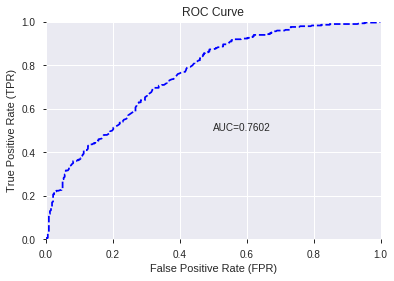

This function is available for GLM models only


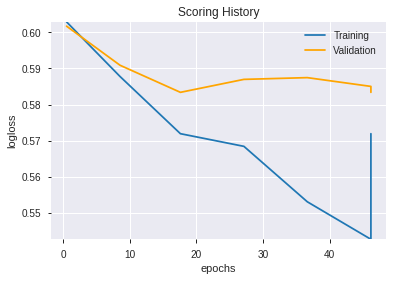

--2019-08-24 14:21:19--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_135722_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_135722_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_b8e3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'TRANGE',
 'DIV',
 'SUB',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'STOCHF_fastk',
 'aroondown_12',
 'CDLHAMMER',
 'STOCHRSI_fastk',
 'ULTOSC',
 'CCI_8',
 'CDLHANGINGMAN',
 'CDLLONGLINE',
 'Volume',
 'MINUS_DM_12',
 'WILLR_8',
 'aroondown_8',
 'WILLR_12',
 'CDLTAKURI',
 'CDLBELTHOLD',
 'MINUS_DI_12',
 'STOCHRSI_fastd',
 'CMO_30',
 'CCI_24',
 'STOCHF_fastd',
 'MINUS_DM_8',
 'CDLENGULFING',
 'MINUS_DI_8',
 'STOCH_slowk',
 'WILLR_20',
 'RSI_30',
 'LINEARREG_ANGLE_8',
 'ADOSC',
 'WILLR_14',
 'CCI_20',
 'WILLR_24',
 'RSI_24',
 'ROCP_8',
 'CDLDRAGONFLYDOJI',
 'MOM_24',
 'CCI_14',
 'CMO_24',
 'ROCR_8',
 'MOM_12',
 'ROCP_20',
 'ROCR_24',
 'ROCR100_24',
 'ROCP_24',
 'WILLR_30',
 'CCI_30',
 'MOM_8',
 'ROC_20',
 'ROCR100_20',
 'ROC_24',
 'ROCR100_8',
 'CCI_12',
 'ROC_8',
 'MOM_20',
 'LINEARREG_SLOPE_8',
 'ROCP_14',
 'ROCR_14',
 'CDL3INSIDE',
 'MOM_14',
 'ROCR_20',
 'CMO_8',
 'ROCR100_12',
 'RSI_20',
 'ROC_12',
 'ROC_14',
 'RSI_8',
 'ROCP_12',
 'ROCR_12',
 'CMO_20',
 'ROCR

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190824_142216_model_1  0.754695  0.589711              0.333822  0.44853  0.201179

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.727260           1.000000    0.121324
1                CCI_8             0.350117           0.481419    0.058408
2   CDLCLOSINGMARUBOZU             0.295368           0.406138    0.049274
3         STOCHF_fastk             0.295051           0.405703    0.049221
4              WILLR_8             0.245178           0.337126    0.040901
..                 ...                  ...                ...         ...
75              ROC_12             0.005063           0.006962    0.000845
76              RSI_12             0.005055           0.006951    0.000843
77              CMO_12             0.004956           0.006815    0.000827
78             ROCP_12             0.004674           0.006427    0.000780
79        CDLSHORTLINE             0.001868           0.002568    0.000312

[80 rows x 4 columns]

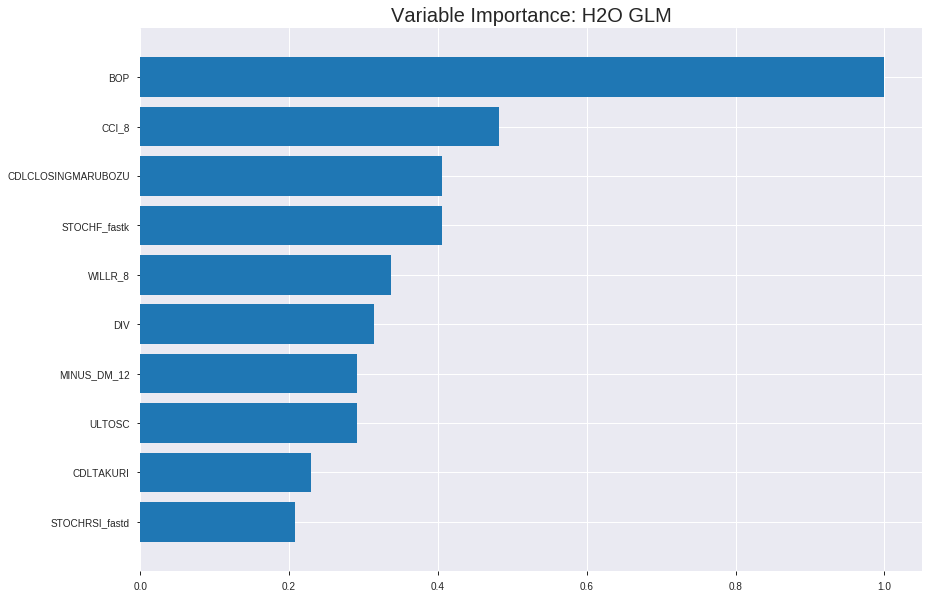

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_142216_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19397590632537853
RMSE: 0.4404269591264578
LogLoss: 0.569020798496325
Null degrees of freedom: 4314
Residual degrees of freedom: 4234
Null deviance: 5970.536326910041
Residual deviance: 4910.649491023285
AIC: 5072.649491023285
AUC: 0.7715956762121882
pr_auc: 0.7413587607529668
Gini: 0.5431913524243763
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3623308712281825: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1177  1091  0.481    (1091.0/2268.0)
1      307   1740  0.15     (307.0/2047.0)
Total  1484  2831  0.324    (1398.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.362331     0.713407  251
max f2                       0.164354     0.835411  342
max f0point5                 0.554747     0.689864  160
max accuracy                 0.517504     0.703592  177
max precision                0.956041     1         0
max recall                   0.0339634    1         393
max specificity              0.956041     1         0
max absolute_mcc             0.480922     0.407387  194
max min_per_class_accuracy   0.490407     0.701514  189
max mean_per_class_accuracy  0.480922     0.703961  194

Gains/Lift Table: Avg response rate: 47.44 %, avg score: 47.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.909019           2.06005   2.06005            0.977273         0.921842   0.977273                    0.921842            0.0210064       0.0210064                  106.005   106.005
    2        0.0201622                   0.894525           1.76481   1.91413            0.837209         0.90073    0.908046                    0.911407            0.0175867       0.0385931                  76.4806   91.4127
    3        0.0301275                   0.878721           1.81383   1.88095            0.860465         0.887188   0.892308                    0.903396            0.0180752       0.0566683                  81.3829   88.0951
    4        0.0400927                   0.866153           1.81383   1.86427            0.860465         0.872088   0.884393                    0.895615            0.0180752       0.0747435                  81.3829   86.4268
    5        0.0500579                   0.855258           1.9609    1.8835             0.930233         0.860467   0.893519                    0.888618            0.0195408       0.0942843                  96.0896   88.3504
    6        0.100116                    0.780952           1.78591   1.83471            0.847222         0.819804   0.87037                     0.854211            0.0893991       0.183683                   78.5913   83.4708
    7        0.150174                    0.725419           1.6688    1.77941            0.791667         0.752      0.844136                    0.820141            0.0835369       0.26722                    66.8804   77.9407
    8        0.2                         0.689037           1.40204   1.68539            0.665116         0.705598   0.799537                    0.791604            0.0698583       0.337079                   40.204    68.5393
    9        0.300116                    0.622072           1.36139   1.57731            0.645833         0.655596   0.748263                    0.746233            0.136297        0.473376                   36.1393   57.731
    10       0.4                         0.558446           1.29119   1.50586            0.612529         0.590407   0.714368                    0.707322            0.128969        0.602345                   29.1188   50.5862
    11       0.500116                    0.480808           1.11742   1.4281             0.530093         0.519452   0.677479                    0.669713            0.111871        0.714216                   11.7416   42.8101
    12       0.6                         0.404208           0.885247  1.33773            0.419954         0.443123   0.634608                    0.631992            0.0884221       0.802638                   -11.4753  33.773
    13       0.699884                    0.330161           0.753193  1.25431            0.357309         0.366119   0.595033                    0.594048            0.075232        0.87787                    -24.6807  25.4308
    14       0.8                         0.254209           0.609943  1.17367            0.289352         0.292061   0.556779                    0.556256            0.061065        0.938935                   -39.0057  17.3669
    15       0.899884                    0.150419           0.445069  1.0928             0.211137         0.207373   0.518414                    0.517531            0.0444553       0.98339                    -55.4931  9.27966
    16       1                           0.00450229         0.165904  1                  0.0787037        0.0866387  0.474392                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1902535158670444
RMSE: 0.4361806000581002
LogLoss: 0.5629209535513087
Null degrees of freedom: 1232
Residual degrees of freedom: 1152
Null deviance: 1711.616831684033
Residual deviance: 1388.1630714575272
AIC: 1550.1630714575272
AUC: 0.7851557155336638
pr_auc: 0.7717008765517159
Gini: 0.5703114310673276
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41550850619007135: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      389  232  0.3736   (232.0/621.0)
1      126  486  0.2059   (126.0/612.0)
Total  515  718  0.2903   (358.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.415509     0.730827  226
max f2                       0.239611     0.842227  316
max f0point5                 0.558988     0.736742  162
max accuracy                 0.547913     0.725872  168
max precision                0.957575     1         0
max recall                   0.0577461    1         386
max specificity              0.957575     1         0
max absolute_mcc             0.547913     0.455425  168
max min_per_class_accuracy   0.482009     0.71732   195
max mean_per_class_accuracy  0.54584      0.725372  169

Gains/Lift Table: Avg response rate: 49.64 %, avg score: 47.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.895297           1.70475   1.70475            0.846154         0.917469  0.846154                    0.917469            0.0179739       0.0179739                  70.4751   70.4751
    2        0.0202758                   0.885906           1.84681   1.77294            0.916667         0.890656  0.88                        0.904599            0.0179739       0.0359477                  84.6814   77.2941
    3        0.0300081                   0.868916           2.01471   1.85135            1                0.877469  0.918919                    0.8958              0.0196078       0.0555556                  101.471   85.1351
    4        0.0405515                   0.861444           1.70475   1.81324            0.846154         0.864322  0.9                         0.887616            0.0179739       0.0735294                  70.4751   81.3235
    5        0.0502839                   0.842271           2.01471   1.85223            1                0.853173  0.919355                    0.880949            0.0196078       0.0931373                  101.471   85.223
    6        0.100568                    0.762587           1.81973   1.83598            0.903226         0.80214   0.91129                     0.841545            0.0915033       0.184641                   81.9734   83.5982
    7        0.150041                    0.713123           1.45323   1.70978            0.721311         0.73868   0.848649                    0.807627            0.0718954       0.256536                   45.323    70.9777
    8        0.200324                    0.685479           1.59227   1.68028            0.790323         0.698852  0.834008                    0.780323            0.0800654       0.336601                   59.2268   68.0281
    9        0.300081                    0.623981           1.53969   1.63355            0.764228         0.654453  0.810811                    0.73848             0.153595        0.490196                   53.9694   63.3545
    10       0.399838                    0.563689           1.24486   1.53657            0.617886         0.594952  0.762677                    0.702671            0.124183        0.614379                   24.4859   53.6571
    11       0.500406                    0.478694           1.03985   1.43674            0.516129         0.524739  0.713128                    0.666911            0.104575        0.718954                   3.98482   43.6743
    12       0.600162                    0.401075           0.851746  1.33951            0.422764         0.439734  0.664865                    0.629151            0.0849673       0.803922                   -14.8254  33.9507
    13       0.699919                    0.326582           0.655189  1.24197            0.325203         0.360476  0.616454                    0.590858            0.0653595       0.869281                   -34.4811  24.1974
    14       0.799676                    0.256229           0.687948  1.17286            0.341463         0.291288  0.58215                     0.553488            0.0686275       0.937908                   -31.2052  17.2861
    15       0.899432                    0.153965           0.343974  1.08093            0.170732         0.215742  0.536519                    0.516028            0.0343137       0.972222                   -65.6026  8.09288
    16       1                           0.00951124         0.27621   1                  0.137097         0.089945  0.49635                     0.473178          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-24 14:22:17  0.000 sec   2            .2E2      81            1.3596803081258624  1.3655349701766697
     2019-08-24 14:22:17  0.027 sec   4            .12E2     81            1.3499675661519381  1.3559132780429906
     2019-08-24 14:22:17  0.054 sec   6            .76E1     81            1.3373457208985344  1.3430495872576096
     2019-08-24 14:22:17  0.084 sec   8            .47E1     81            1.321179238128631   1.3261512747315984
     2019-08-24 14:22:17  0.114 sec   10           .29E1     81            1.301193588774529   1.304814030522314
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-24 14:22:17  0.793 sec   40           .23E-2    81            1.1373415008035541  1.1258788240073783
     2019-08-24 14:22:18  0.817 sec   41           .14E-2    81            1.1367971548761693  1.1260580272426115
     2019-08-24 14:22:18  0.841 sec   42           .9E-3     81            1.1363542294769853  1.1263262094268236
     2019-08-24 14:22:18  0.865 sec   43           .56E-3    81            1.1359816900339084  1.1266391519021193
     2019-08-24 14:22:18  0.890 sec   44           .35E-3    81            1.1356722742371321  1.1269654519364938


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6790923824959482)

('F1', 0.7207446808510639)

('auc', 0.7546950578338592)

('logloss', 0.589710718006538)

('mean_per_class_error', 0.32007886435331234)

('rmse', 0.44852952485562764)

('mse', 0.20117873466721511)

glm prediction progress: |████████████████████████████████████████████████| 100%


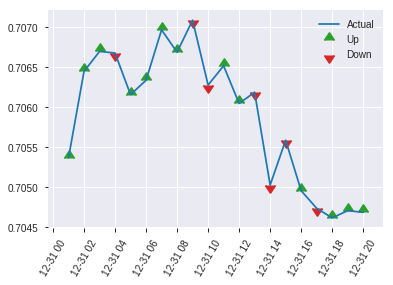


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20117873466721511
RMSE: 0.44852952485562764
LogLoss: 0.589710718006538
Null degrees of freedom: 616
Residual degrees of freedom: 536
Null deviance: 855.2213378304502
Residual deviance: 727.7030260200678
AIC: 889.7030260200678
AUC: 0.7546950578338592
pr_auc: 0.7359047035016907
Gini: 0.5093901156677183
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29962116368080877: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      136  181  0.571    (181.0/317.0)
1      29   271  0.0967   (29.0/300.0)
Total  165  452  0.3404   (210.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.299621     0.720745  284
max f2                       0.20834      0.841642  323
max f0point5                 0.629263     0.683263  108
max accuracy                 0.564424     0.679092  143
max precision                0.92361      1         0
max recall                   0.00329154   1         399
max specificity              0.92361      1         0
max absolute_mcc             0.299621     0.375303  284
max min_per_class_accuracy   0.466862     0.665615  194
max mean_per_class_accuracy  0.443067     0.679921  208

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 45.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.908904           1.76286   1.76286            0.857143         0.915541   0.857143                    0.915541            0.02            0.02                       76.2857    76.2857
    2        0.0210697                   0.893078           1.37111   1.58205            0.666667         0.89762    0.769231                    0.90727             0.0133333       0.0333333                  37.1111    58.2051
    3        0.0307942                   0.866118           2.05667   1.73193            1                0.883338   0.842105                    0.899712            0.02            0.0533333                  105.667    73.193
    4        0.0405186                   0.853968           2.05667   1.80987            1                0.857108   0.88                        0.889487            0.02            0.0733333                  105.667    80.9867
    5        0.0502431                   0.842619           2.05667   1.85763            1                0.848157   0.903226                    0.881488            0.02            0.0933333                  105.667    85.7634
    6        0.100486                    0.75198            1.85763   1.85763            0.903226         0.803304   0.903226                    0.842396            0.0933333       0.186667                   85.7634    85.7634
    7        0.150729                    0.696868           1.59226   1.76918            0.774194         0.722205   0.860215                    0.802332            0.08            0.266667                   59.2258    76.9176
    8        0.200972                    0.669409           1.45957   1.69177            0.709677         0.681936   0.822581                    0.772233            0.0733333       0.34                       45.957     69.1774
    9        0.299838                    0.603923           1.14634   1.51193            0.557377         0.635543   0.735135                    0.727163            0.113333        0.453333                   14.6339    51.1928
    10       0.400324                    0.534069           1.19419   1.43217            0.580645         0.567976   0.696356                    0.687205            0.12            0.573333                   19.4194    43.2173
    11       0.50081                     0.463032           0.995161  1.34449            0.483871         0.498946   0.653722                    0.649431            0.1             0.673333                   -0.483871  34.4488
    12       0.599676                    0.38813            1.04519   1.29514            0.508197         0.427234   0.62973                     0.612799            0.103333        0.776667                   4.51913    29.5144
    13       0.700162                    0.319003           0.862473  1.23305            0.419355         0.35168    0.599537                    0.575323            0.0866667       0.863333                   -13.7527   23.3048
    14       0.799028                    0.223247           0.842896  1.18477            0.409836         0.279508   0.576065                    0.538722            0.0833333       0.946667                   -15.7104   18.4773
    15       0.899514                    0.124094           0.298548  1.08577            0.145161         0.178428   0.527928                    0.498472            0.03            0.976667                   -70.1452   8.57718
    16       1                           0.00329154         0.232204  1                  0.112903         0.0733391  0.486224   

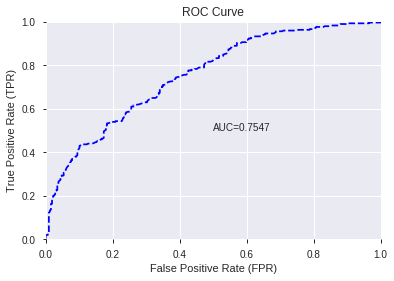

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


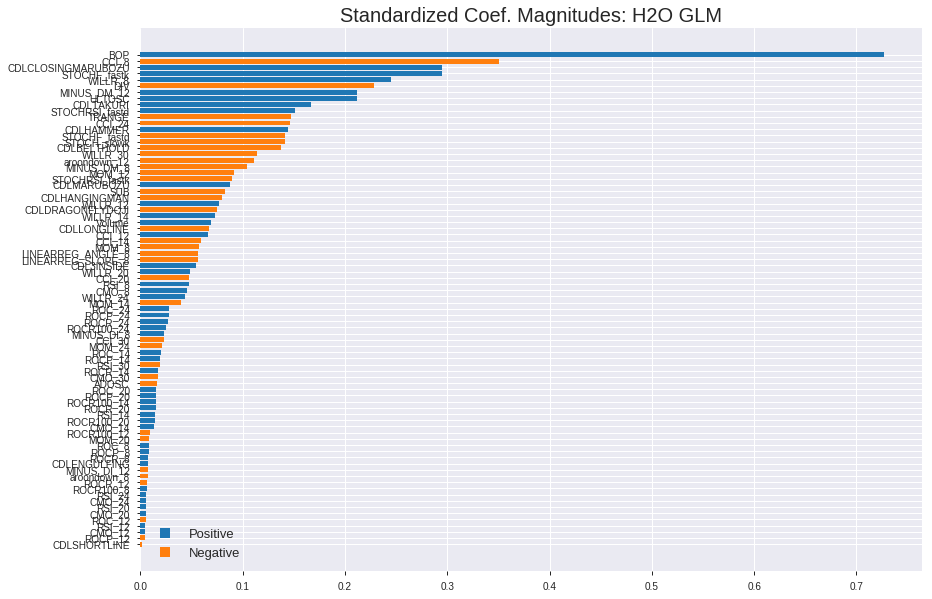

'log_likelihood'
--2019-08-24 14:22:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_142216_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_142216_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_b8e3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'CCI_8',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'WILLR_8',
 'DIV',
 'MINUS_DM_12',
 'ULTOSC',
 'CDLTAKURI',
 'STOCHRSI_fastd',
 'TRANGE',
 'CCI_24',
 'CDLHAMMER',
 'STOCHF_fastd',
 'STOCH_slowk',
 'CDLBELTHOLD',
 'WILLR_30',
 'aroondown_12',
 'MINUS_DM_8',
 'MOM_12',
 'STOCHRSI_fastk',
 'CDLMARUBOZU',
 'SUB',
 'CDLHANGINGMAN',
 'WILLR_12',
 'CDLDRAGONFLYDOJI',
 'WILLR_14',
 'Volume',
 'CDLLONGLINE',
 'CCI_12',
 'CCI_14',
 'MOM_8',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_8',
 'CDL3INSIDE',
 'WILLR_20',
 'CCI_20',
 'RSI_8',
 'CMO_8',
 'WILLR_24',
 'MOM_14',
 'ROC_24',
 'ROCP_24',
 'ROCR_24',
 'ROCR100_24',
 'MINUS_DI_8',
 'CCI_30',
 'MOM_24',
 'ROC_14',
 'ROCP_14',
 'RSI_30',
 'ROCR_14',
 'CMO_30',
 'ADOSC',
 'ROC_20',
 'ROCP_20',
 'ROCR100_14',
 'ROCR_20',
 'RSI_14',
 'ROCR100_20',
 'CMO_14',
 'ROCR100_12',
 'MOM_20',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'CDLENGULFING',
 'MINUS_DI_12',
 'aroondown_8',
 'ROCR_12',
 'ROCR100_8',
 'RSI_24',
 'CMO_24',
 'RSI_20',
 'CMO_20',
 'ROC_12'

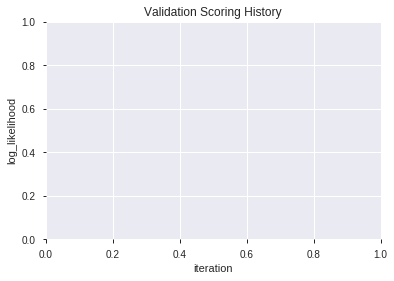

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_142324_model_6  0.752766  0.585699              0.334448  0.448863  0.201478
1               XGBoost_3_AutoML_20190824_142324  0.752087  0.585750              0.354653  0.448751  0.201377
2  XGBoost_grid_1_AutoML_20190824_142324_model_2  0.751730  0.584976              0.348970  0.448459  0.201116
3  XGBoost_grid_1_AutoML_20190824_142324_model_1  0.748559  0.589746              0.365694  0.450428  0.202886
4  XGBoost_grid_1_AutoML_20190824_142324_model_3  0.747108  0.589477              0.359564  0.450876  0.203289
5               XGBoost_2_AutoML_20190824_142324  0.746982  0.590534              0.346767  0.451890  0.204205
6  XGBoost_grid_1_AutoML_20190824_142324_model_4  0.745762  0.587988              0.354653  0.450733  0.203160
7  XGBoost_grid_1_AutoML_20190824_142324_model_7  0.740315  0.599410              0.344953  0.455203  0.207209
8               XGBoost_1_AutoML_20190824_142324  0.739685  0.602144              0.348554  0.456281  0.208192
9  XGBoost_grid_1_AutoML_20190824_142324_model_5  0.725568  0.624448              0.368165  0.464813  0.216051

variable  relative_importance  scaled_importance  percentage
0                  BOP          4728.921387           1.000000    0.272060
1                  DIV          1061.475220           0.224465    0.061068
2         STOCHF_fastk           838.257568           0.177262    0.048226
3   CDLCLOSINGMARUBOZU           690.391541           0.145993    0.039719
4                CCI_8           649.759033           0.137401    0.037381
..                 ...                  ...                ...         ...
64              RSI_14            18.329651           0.003876    0.001055
65        CDLENGULFING            15.692502           0.003318    0.000903
66               RSI_8            15.086609           0.003190    0.000868
67         CDLLONGLINE            14.486410           0.003063    0.000833
68             ROCR_24             4.990979           0.001055    0.000287

[69 rows x 4 columns]

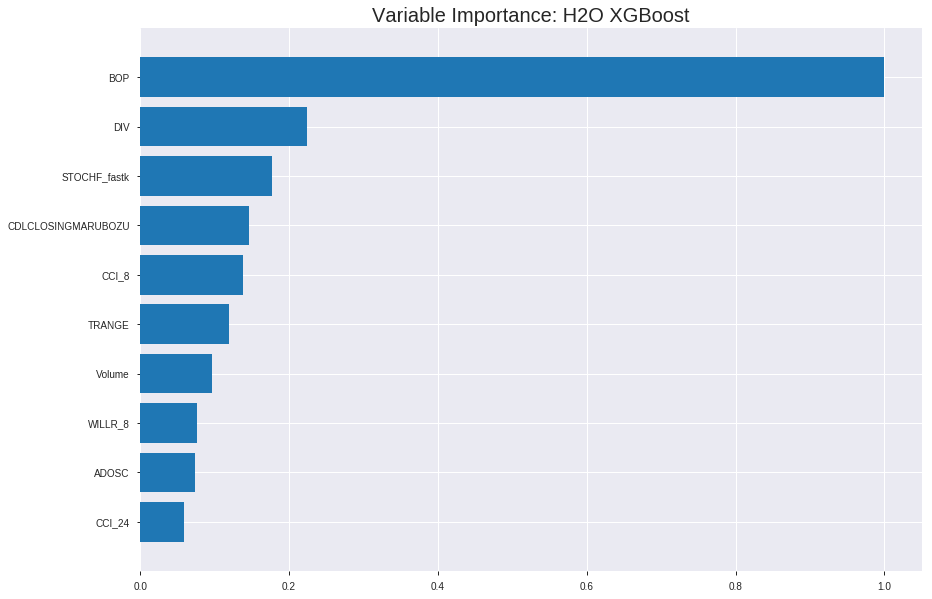

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_142324_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16024057287403148
RMSE: 0.4003006031397298
LogLoss: 0.4894910773815877
Mean Per-Class Error: 0.22561633620500254
AUC: 0.8623190559764408
pr_auc: 0.8573437382550935
Gini: 0.7246381119528815
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43584831224547493: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1489  779   0.3435   (779.0/2268.0)
1      275   1772  0.1343   (275.0/2047.0)
Total  1764  2551  0.2443   (1054.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.435848     0.77077   226
max f2                       0.252502     0.861238  310
max f0point5                 0.5992       0.778651  141
max accuracy                 0.501015     0.773812  193
max precision                0.959379     1         0
max recall                   0.126827     1         364
max specificity              0.959379     1         0
max absolute_mcc             0.498902     0.548056  194
max min_per_class_accuracy   0.506307     0.770723  190
max mean_per_class_accuracy  0.498902     0.774384  194

Gains/Lift Table: Avg response rate: 47.44 %, avg score: 47.54 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.920214           2.10796    2.10796            1                0.935098  1                           0.935098            0.0214949       0.0214949                  110.796   110.796
    2        0.0201622                   0.900837           2.10796    2.10796            1                0.911216  1                           0.923294            0.0210064       0.0425012                  110.796   110.796
    3        0.0301275                   0.880078           2.05894    2.09175            0.976744         0.889697  0.992308                    0.912181            0.0205178       0.0630191                  105.894   109.175
    4        0.0400927                   0.855932           2.10796    2.09578            1                0.870138  0.99422                     0.901731            0.0210064       0.0840254                  110.796   109.578
    5        0.0500579                   0.838121           2.10796    2.0982             1                0.847037  0.99537                     0.890843            0.0210064       0.105032                   110.796   109.82
    6        0.100116                    0.766562           2.06893    2.08357            0.981481         0.799687  0.988426                    0.845265            0.103566        0.208598                   106.893   108.357
    7        0.150174                    0.717246           1.95182    2.03965            0.925926         0.73941   0.967593                    0.80998             0.097704        0.306302                   95.1817   103.965
    8        0.2                         0.674381           1.72559    1.96141            0.818605         0.694465  0.930475                    0.781201            0.0859795       0.392281                   72.5588   96.1407
    9        0.300116                    0.612268           1.54682    1.8231             0.733796         0.641409  0.864865                    0.734568            0.154861        0.547142                   54.6815   82.3103
    10       0.4                         0.554484           1.25206    1.68051            0.593968         0.583046  0.797219                    0.696731            0.125061        0.672203                   25.2061   68.0508
    11       0.500116                    0.496406           1.16133    1.57658            0.550926         0.525326  0.747915                    0.662418            0.116268        0.788471                   16.1331   57.6576
    12       0.6                         0.428289           0.826556   1.45172            0.392111         0.462275  0.688683                    0.6291              0.0825598       0.871031                   -17.3444  45.1718
    13       0.699884                    0.351669           0.630922   1.33458            0.299304         0.38998   0.633113                    0.594974            0.0630191       0.93405                    -36.9078  33.4578
    14       0.8                         0.2465             0.439159   1.22252            0.208333         0.29639   0.579954                    0.557607            0.0439668       0.978017                   -56.0841  22.2521
    15       0.899884                    0.141875           0.205416   1.10963            0.0974478        0.191423  0.526397                    0.516962            0.0205178       0.998534                   -79.4584  10.9626
    16       1                           0.0349509          0.0146386  1                  0.00694444       0.102077  0.474392                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19161676567134042
RMSE: 0.4377405232227654
LogLoss: 0.5654713377742335
Mean Per-Class Error: 0.27247324050393107
AUC: 0.7835480407944175
pr_auc: 0.7666410766663436
Gini: 0.5670960815888351
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47442873815695447: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      419  202  0.3253   (202.0/621.0)
1      135  477  0.2206   (135.0/612.0)
Total  554  679  0.2733   (337.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.474429     0.738962  206
max f2                       0.183322     0.84537   342
max f0point5                 0.513786     0.725166  184
max accuracy                 0.505274     0.727494  190
max precision                0.952166     1         0
max recall                   0.0834159    1         388
max specificity              0.952166     1         0
max absolute_mcc             0.474429     0.45647   206
max min_per_class_accuracy   0.506487     0.724638  189
max mean_per_class_accuracy  0.505274     0.727527  190

Gains/Lift Table: Avg response rate: 49.64 %, avg score: 48.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.913575           1.70475   1.70475            0.846154         0.930288  0.846154                    0.930288            0.0179739       0.0179739                  70.4751   70.4751
    2        0.0202758                   0.88454            1.84681   1.77294            0.916667         0.901764  0.88                        0.916597            0.0179739       0.0359477                  84.6814   77.2941
    3        0.0300081                   0.85885            1.84681   1.7969             0.916667         0.878206  0.891892                    0.904146            0.0179739       0.0539216                  84.6814   79.69
    4        0.0405515                   0.846333           2.01471   1.85353            1                0.852353  0.92                        0.89068             0.0212418       0.0751634                  101.471   85.3529
    5        0.0502839                   0.833652           1.34314   1.75474            0.666667         0.839812  0.870968                    0.880834            0.0130719       0.0882353                  34.3137   75.4744
    6        0.100568                    0.756079           1.85223   1.80349            0.919355         0.790949  0.895161                    0.835892            0.0931373       0.181373                   85.223    80.3487
    7        0.150041                    0.708421           1.61837   1.74245            0.803279         0.732182  0.864865                    0.801696            0.0800654       0.261438                   61.837    74.2448
    8        0.200324                    0.669134           1.52728   1.68844            0.758065         0.68642   0.838057                    0.77276             0.0767974       0.338235                   52.7277   68.8438
    9        0.300081                    0.61338            1.3759    1.58454            0.682927         0.638571  0.786486                    0.728151            0.137255        0.47549                    37.5897   58.4539
    10       0.399838                    0.56165            1.294     1.51205            0.642276         0.588007  0.750507                    0.693186            0.129085        0.604575                   29.3998   51.2051
    11       0.500406                    0.506274           1.23482   1.45634            0.612903         0.532495  0.722853                    0.660892            0.124183        0.728758                   23.482    45.6335
    12       0.600162                    0.441114           0.737088  1.33678            0.365854         0.473054  0.663514                    0.62967             0.0735294       0.802288                   -26.2912  33.6785
    13       0.699919                    0.359073           0.737088  1.25131            0.365854         0.399276  0.621089                    0.596833            0.0735294       0.875817                   -26.2912  25.1312
    14       0.799676                    0.26605            0.60605   1.17082            0.300813         0.317021  0.581136                    0.561927            0.0604575       0.936275                   -39.395   17.0818
    15       0.899432                    0.158756           0.409493  1.08638            0.203252         0.215721  0.539225                    0.523529            0.0408497       0.977124                   -59.0507  8.63788
    16       1                           0.0394702          0.227467  1                  0.112903         0.110174  0.49635                     0.481959           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 14:23:47  14.825 sec  0                  0.5              0.693147            0.5             0                  1                0.525608                         0.5                0.693147              0.5               0                    1                  0.50365
    2019-08-24 14:23:47  14.929 sec  5                  0.475929         0.645803            0.79199         0.767495           2.10796          0.322132                         0.479506           0.65272               0.769968          0.751909             1.74608            0.312247
    2019-08-24 14:23:47  14.991 sec  10                 0.459383         0.613458            0.80396         0.786231           2.10796          0.297567                         0.465768           0.625686              0.778747          0.766695             1.85973            0.313869
    2019-08-24 14:23:47  15.063 sec  15                 0.447884         0.59037             0.809289        0.791463           2.10796          0.305678                         0.457313           0.608592              0.780441          0.767824             1.85973            0.303325
    2019-08-24 14:23:47  15.144 sec  20                 0.439335         0.572673            0.813894        0.798967           2.10796          0.2927                           0.450731           0.594978              0.783188          0.769014             1.85973            0.330089
    2019-08-24 14:23:48  15.220 sec  25                 0.432109         0.557486            0.820403        0.807348           2.10796          0.285052                         0.446545           0.585914              0.783903          0.769794             1.85973            0.321979
    2019-08-24 14:23:48  15.305 sec  30                 0.427324         0.546996            0.824067        0.813281           2.10796          0.282735                         0.444331           0.580891              0.78332           0.769365             1.85973            0.301703
    2019-08-24 14:23:48  15.380 sec  35                 0.423398         0.537994            0.826584        0.81567            2.10796          0.292236                         0.441994           0.575578              0.783836          0.770807             1.85973            0.27575
    2019-08-24 14:23:48  15.458 sec  40                 0.419421         0.529654            0.832692        0.824061           2.10796          0.278795                         0.440354           0.571886              0.785757          0.771425             1.85973            0.30738
    2019-08-24 14:23:48  15.643 sec  45                 0.416255         0.522405            0.836355        0.826875           2.10796          0.271842                         0.439814           0.570345              0.784835          0.769835             1.70475            0.305758
    2019-08-24 14:23:48  15.724 sec  50                 0.413798         0.516981            0.839653        0.831098           2.10796          0.269757                         0.439413           0.569201              0.784095          0.770933             1.70475            0.30738
    2019-08-24 14:23:48  15.812 sec  55                 0.411101         0.511465            0.844709        0.836242           2.10796          0.263268                         0.439008           0.568186              0.78389           0.769

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ----------------------
BOP                 4728.92138671875       1.0                    0.2720601800684595
DIV                 1061.4752197265625     0.22446455183368713    0.06106786639085899
STOCHF_fastk        838.257568359375       0.17726189543214538    0.04822590319054591
CDLCLOSINGMARUBOZU  690.3915405273438      0.1459934484143296     0.039719003864417866
CCI_8               649.759033203125       0.13740110694755542    0.03738136989775759
---                 ---                    ---                    ---
RSI_14              18.32965087890625      0.0038760743476060656  0.001054525484968443
CDLENGULFING        15.69250202178955      0.0033184104235401734  0.0009028073373693926
RSI_8               15.08660888671875      0.0031902854061160177  0.0008679496220577024
CDLLONGLINE         14.486410140991211     0.003063364551095419   0.0008334195113863554
ROCR_24             4.990979194641113      0.0010554159789288012  0.00028713666127449914


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6823338735818476)

('F1', 0.7154471544715447)

('auc', 0.7527655099894848)

('logloss', 0.5856992582481354)

('mean_per_class_error', 0.3183806519453207)

('rmse', 0.44886288728476575)

('mse', 0.2014778915816163)

xgboost prediction progress: |████████████████████████████████████████████| 100%


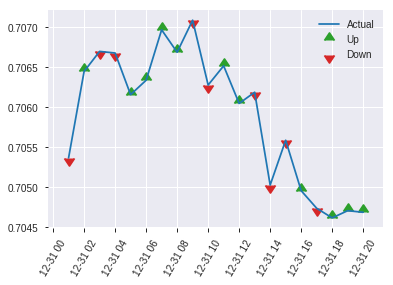


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2014778915816163
RMSE: 0.44886288728476575
LogLoss: 0.5856992582481354
Mean Per-Class Error: 0.3183806519453207
AUC: 0.7527655099894848
pr_auc: 0.7283155284413767
Gini: 0.5055310199789695
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34047073125839233: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      143  174  0.5489   (174.0/317.0)
1      36   264  0.12     (36.0/300.0)
Total  179  438  0.3404   (210.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.340471     0.715447  271
max f2                       0.171921     0.847262  342
max f0point5                 0.535728     0.677711  160
max accuracy                 0.513275     0.682334  172
max precision                0.945999     1         0
max recall                   0.0530011    1         397
max specificity              0.945999     1         0
max absolute_mcc             0.425939     0.368687  228
max min_per_class_accuracy   0.484315     0.68      192
max mean_per_class_accuracy  0.425939     0.681619  228

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 46.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.914787           1.76286   1.76286            0.857143         0.930527  0.857143                    0.930527            0.02            0.02                       76.2857   76.2857
    2        0.0210697                   0.892548           2.05667   1.89846            1                0.902073  0.923077                    0.917395            0.02            0.04                       105.667   89.8462
    3        0.0307942                   0.85825            2.05667   1.94842            1                0.882588  0.947368                    0.906403            0.02            0.06                       105.667   94.8421
    4        0.0405186                   0.837146           1.02833   1.7276             0.5              0.846023  0.84                        0.891912            0.01            0.07                       2.83333   72.76
    5        0.0502431                   0.813789           2.05667   1.79129            1                0.830582  0.870968                    0.880042            0.02            0.09                       105.667   79.129
    6        0.100486                    0.732113           1.6586    1.72495            0.806452         0.764549  0.83871                     0.822295            0.0833333       0.173333                   65.8602   72.4946
    7        0.150729                    0.674403           1.52591   1.6586             0.741935         0.695798  0.806452                    0.78013             0.0766667       0.25                       52.5914   65.8602
    8        0.200972                    0.636181           1.59226   1.64202            0.774194         0.656005  0.798387                    0.749098            0.08            0.33                       59.2258   64.2016
    9        0.299838                    0.589898           1.31492   1.53416            0.639344         0.611937  0.745946                    0.703872            0.13            0.46                       31.4918   53.4162
    10       0.400324                    0.539872           1.16102   1.4405             0.564516         0.563321  0.700405                    0.668592            0.116667        0.576667                   16.1022   44.0499
    11       0.50081                     0.480367           1.06151   1.36446            0.516129         0.508816  0.66343                     0.636534            0.106667        0.683333                   6.15054   36.4455
    12       0.599676                    0.412511           0.97776   1.3007             0.47541          0.449594  0.632432                    0.605714            0.0966667       0.78                       -2.22404  30.0703
    13       0.700162                    0.345606           0.895645  1.24257            0.435484         0.382052  0.604167                    0.573614            0.09            0.87                       -10.4355  24.2569
    14       0.799028                    0.246679           0.674317  1.17226            0.327869         0.301206  0.56998                     0.539909            0.0666667       0.936667                   -32.5683  17.2258
    15       0.899514                    0.140064           0.497581  1.09689            0.241935         0.191859  0.533333                    0.501027            0.05            0.986667                   -50.2419  9.68889
    16       1                           0.0454475          0.132688  1                  0.0645161        0.101566  0.486224                    0.460887            

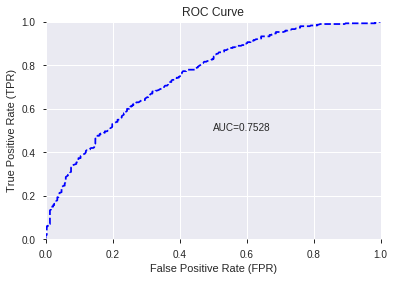

This function is available for GLM models only


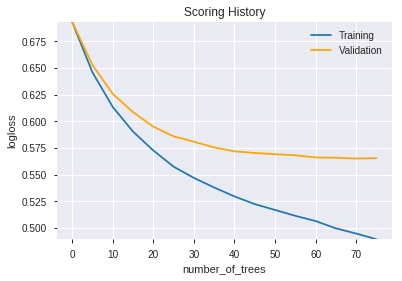

--2019-08-24 14:24:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.229.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.229.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_142324_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_142324_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_b8e3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'STOCHF_fastk',
 'CDLCLOSINGMARUBOZU',
 'CCI_8',
 'TRANGE',
 'Volume',
 'WILLR_8',
 'ADOSC',
 'CCI_24',
 'WILLR_12',
 'MINUS_DI_8',
 'STOCHRSI_fastk',
 'CCI_12',
 'CCI_14',
 'ULTOSC',
 'MOM_20',
 'LINEARREG_ANGLE_8',
 'SUB',
 'WILLR_20',
 'CCI_20',
 'MINUS_DM_8',
 'MINUS_DI_12',
 'WILLR_14',
 'CDLHAMMER',
 'STOCH_slowk',
 'WILLR_24',
 'STOCHRSI_fastd',
 'aroondown_12',
 'MINUS_DM_12',
 'MOM_12',
 'CCI_30',
 'MOM_14',
 'ROC_20',
 'CMO_30',
 'CMO_20',
 'MOM_24',
 'MOM_8',
 'ROC_24',
 'CMO_8',
 'WILLR_30',
 'CMO_24',
 'CMO_12',
 'LINEARREG_SLOPE_8',
 'CDLSHORTLINE',
 'ROC_12',
 'aroondown_8',
 'ROC_8',
 'CMO_14',
 'ROC_14',
 'CDLTAKURI',
 'CDLBELTHOLD',
 'RSI_30',
 'ROCP_20',
 'STOCHF_fastd',
 'CDLMARUBOZU',
 'ROCP_14',
 'CDLDRAGONFLYDOJI',
 'RSI_12',
 'RSI_24',
 'ROCP_12',
 'CDLHANGINGMAN',
 'ROCP_24',
 'ROCP_8',
 'RSI_14',
 'CDLENGULFING',
 'RSI_8',
 'CDLLONGLINE',
 'ROCR_24']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

52

['BBANDS_upperband_8_7_3',
 'BBANDS_upperband_14_2_5',
 'BOP',
 'aroondown_8',
 'aroonup_8',
 'CCI_8',
 'DX_8',
 'ROCR_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'MOM_12',
 'ROCR100_12',
 'WILLR_12',
 'AROONOSC_14',
 'MINUS_DM_14',
 'WILLR_14',
 'aroonup_20',
 'CCI_20',
 'MFI_20',
 'MINUS_DM_20',
 'PLUS_DM_20',
 'ROCR_20',
 'WILLR_20',
 'PLUS_DI_24',
 'ROCP_24',
 'ROCR100_24',
 'aroonup_30',
 'DX_30',
 'ROCR_30',
 'MACD_signal',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'ULTOSC',
 'AD',
 'NATR_14',
 'ATR_30',
 'TRANGE',
 'HT_DCPERIOD',
 'HT_PHASOR_quadrature',
 'CDLCLOSINGMARUBOZU',
 'BETA_8',
 'LINEARREG_SLOPE_8',
 'VAR_8',
 'BETA_12',
 'STDDEV_12',
 'VAR_12',
 'BETA_14',
 'VAR_14',
 'DIV']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_142903_model_8  0.745315  0.597083              0.341977  0.454113  0.206218
1  DeepLearning_grid_1_AutoML_20190824_142903_model_6  0.740258  0.601832              0.347571  0.455444  0.207429
2  DeepLearning_grid_1_AutoML_20190824_142903_model_9  0.738896  0.591406              0.353165  0.452012  0.204315
3               DeepLearning_1_AutoML_20190824_142903  0.738381  0.650791              0.350904  0.469149  0.220101
4  DeepLearning_grid_1_AutoML_20190824_142903_model_4  0.734259  0.601549              0.348791  0.455613  0.207583
5  DeepLearning_grid_1_AutoML_20190824_142903_model_5  0.724926  0.613269              0.371914  0.459817  0.211432
6  DeepLearning_grid_1_AutoML_20190824_142903_model_7  0.721388  0.635618              0.344685  0.466769  0.217873
7  DeepLearning_grid_1_AutoML_20190824_142903_model_3  0.711824  0.649500              0.339595  0.470175  0.221064
8  DeepLearning_grid_1_AutoML_20190824_142903_model_1  0.680268  0.908872              0.389175  0.521411  0.271870
9  DeepLearning_grid_1_AutoML_20190824_142903_model_2  0.675221  0.776715              0.370694  0.512465  0.262620

variable  relative_importance  scaled_importance  percentage
0                       BOP             1.000000           1.000000    0.045499
1        CDLCLOSINGMARUBOZU             0.995730           0.995730    0.045305
2                       DIV             0.662589           0.662589    0.030147
3                    TRANGE             0.660087           0.660087    0.030033
4                     CCI_8             0.463178           0.463178    0.021074
5                 aroonup_8             0.462372           0.462372    0.021037
6                    ULTOSC             0.451948           0.451948    0.020563
7               HT_DCPERIOD             0.446668           0.446668    0.020323
8                     DX_30             0.437151           0.437151    0.019890
9            STOCHRSI_fastk             0.436686           0.436686    0.019869
10                     DX_8             0.435590           0.435590    0.019819
11                       AD             0.435356           0.435356    0.019808
12                STDDEV_12             0.432687           0.432687    0.019687
13             STOCHF_fastk             0.430217           0.430217    0.019574
14                  BETA_12             0.420204           0.420204    0.019119
15              aroondown_8             0.415078           0.415078    0.018886
16                  BETA_14             0.407152           0.407152    0.018525
17              AROONOSC_14             0.400039           0.400039    0.018201
18  BBANDS_upperband_14_2_5             0.398905           0.398905    0.018150
19              STOCH_slowk             0.398884           0.398884    0.018149
20                   VAR_14             0.394249           0.394249    0.017938
21   BBANDS_upperband_8_7_3             0.393571           0.393571    0.017907
22                   BETA_8             0.393254           0.393254    0.017893
23     HT_PHASOR_quadrature             0.393119           0.393119    0.017886
24               ROCR100_24             0.392352           0.392352    0.017852
25                  ROCR_30             0.391888           0.391888    0.017830
26                   CCI_20             0.391272           0.391272    0.017802
27               aroonup_20             0.388025           0.388025    0.017655
28                 WILLR_20             0.387710           0.387710    0.017640
29              MACD_signal             0.384621           0.384621    0.017500
30               aroonup_30             0.380660           0.380660    0.017320
31                  WILLR_8             0.380643           0.380643    0.017319
32                 WILLR_14             0.380567           0.380567    0.017315
33               PLUS_DI_24             0.380151           0.380151    0.017296
34                   ATR_30             0.379875           0.379875    0.017284
35                    VAR_8             0.378340           0.378340    0.017214
36              MINUS_DM_14             0.377820           0.377820    0.017190
37                   CCI_12             0.377242           0.377242    0.017164
38                   VAR_12             0.375049           0.375049    0.017064
39                  NATR_14             0.373742           0.373742    0.017005
40              MINUS_DM_20             0.372706           0.372706    0.016958
41                  ROCR_20             0.371880           0.371880    0.016920
42                   MFI_20             0.349459           0.349459    0.015900
43             STOCHF_fastd             0.348504           0.348504    0.015857
44                   ROCR_8             0.342946           0.342946    0.015604
45                  ROCP_24             0.341477           0.341477    0.015537
46                 WILLR_12             0.340919           0.340919    0.015511
47        LINEARREG_SLOPE_8             0.338092           0.338092    0.015383
48               ROCR100_12             0.334538           0.334538    0.015221
49               PL

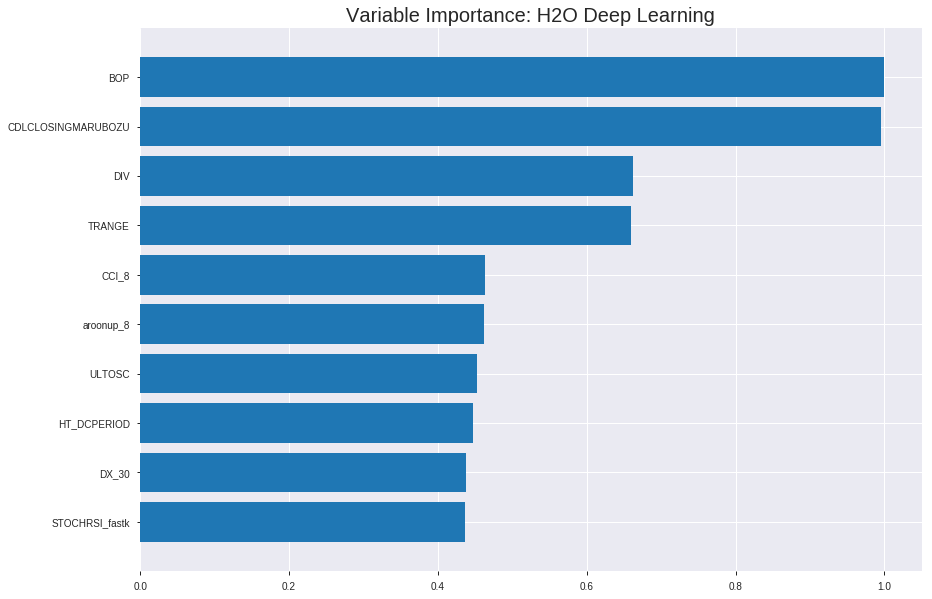

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_142903_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19546871058263282
RMSE: 0.44211843501785
LogLoss: 0.5714905778983426
Mean Per-Class Error: 0.3024198099511566
AUC: 0.7690030534640533
pr_auc: 0.731266664547667
Gini: 0.5380061069281066
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3939699082985806: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1167  1101  0.4854   (1101.0/2268.0)
1      294   1753  0.1436   (294.0/2047.0)
Total  1461  2854  0.3233   (1395.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.39397      0.715364  239
max f2                       0.101349     0.837196  357
max f0point5                 0.551359     0.681424  151
max accuracy                 0.513155     0.695713  174
max precision                0.90854      1         0
max recall                   0.0291939    1         393
max specificity              0.90854      1         0
max absolute_mcc             0.448842     0.400495  210
max min_per_class_accuracy   0.50754      0.691744  178
max mean_per_class_accuracy  0.448842     0.69758   210

Gains/Lift Table: Avg response rate: 47.44 %, avg score: 46.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.882567           1.86842   1.86842            0.886364         0.892821   0.886364                    0.892821            0.0190523       0.0190523                  86.8422   86.8422
    2        0.0201622                   0.870226           1.76481   1.81721            0.837209         0.876134   0.862069                    0.884574            0.0175867       0.036639                   76.4806   81.7209
    3        0.0301275                   0.860057           1.76481   1.79988            0.837209         0.865493   0.853846                    0.878262            0.0175867       0.0542257                  76.4806   79.9876
    4        0.0400927                   0.851427           1.9609    1.8399             0.930233         0.856494   0.872832                    0.872852            0.0195408       0.0737665                  96.0896   83.9898
    5        0.0500579                   0.836453           1.91187   1.85423            0.906977         0.843742   0.87963                     0.867057            0.0190523       0.0928188                  91.1873   85.4227
    6        0.100116                    0.716409           1.70784   1.78103            0.810185         0.762147   0.844907                    0.814602            0.085491        0.17831                    70.784    78.1033
    7        0.150174                    0.674746           1.56145   1.70784            0.740741         0.692918   0.810185                    0.774041            0.0781632       0.256473                   56.1454   70.784
    8        0.2                         0.644162           1.48048   1.6512             0.702326         0.659004   0.783314                    0.745382            0.0737665       0.330239                   48.0476   65.1197
    9        0.300116                    0.588386           1.43459   1.57894            0.680556         0.616165   0.749035                    0.702276            0.143625        0.473864                   43.4586   57.8937
    10       0.4                         0.543466           1.20315   1.4851             0.570766         0.564807   0.704519                    0.667949            0.120176        0.59404                    20.3153   48.51
    11       0.500116                    0.501569           1.10278   1.40856            0.523148         0.523152   0.668211                    0.638962            0.110405        0.704446                   10.2777   40.8565
    12       0.6                         0.437237           1.00752   1.3418             0.477958         0.47235    0.636539                    0.611226            0.100635        0.805081                   0.751822  34.1801
    13       0.699884                    0.358726           0.777648  1.26129            0.36891          0.399553   0.598344                    0.581017            0.0776746       0.882755                   -22.2352  26.1288
    14       0.8                         0.245124           0.629461  1.18222            0.298611         0.30686    0.560834                    0.546708            0.0630191       0.945774                   -37.0539  18.2218
    15       0.899884                    0.101727           0.401051  1.09551            0.190255         0.169746   0.519701                    0.504866            0.0400586       0.985833                   -59.8949  9.5511
    16       1                           0.00553653         0.141507  1                  0.0671296        0.0640717  0.474392                    0.4



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19726471503626145
RMSE: 0.44414492571261177
LogLoss: 0.5771842320727468
Mean Per-Class Error: 0.2910035995074358
AUC: 0.7779632787092293
pr_auc: 0.7607096437390031
Gini: 0.5559265574184586
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40168723911486415: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      343  278  0.4477   (278.0/621.0)
1      93   519  0.152    (93.0/612.0)
Total  436  797  0.3009   (371.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.401687     0.736693  236
max f2                       0.200507     0.845211  327
max f0point5                 0.527023     0.71281   156
max accuracy                 0.475307     0.70884   194
max precision                0.908923     1         0
max recall                   0.0492944    1         386
max specificity              0.908923     1         0
max absolute_mcc             0.423845     0.422318  223
max min_per_class_accuracy   0.482469     0.705314  188
max mean_per_class_accuracy  0.475307     0.708996  194

Gains/Lift Table: Avg response rate: 49.64 %, avg score: 44.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105434                   0.871448           1.85973   1.85973            0.923077         0.884447   0.923077                    0.884447            0.0196078       0.0196078                  85.9729    85.9729
    2        0.0202758                   0.859839           1.84681   1.85353            0.916667         0.866432   0.92                        0.8758              0.0179739       0.0375817                  84.6814    85.3529
    3        0.0300081                   0.842895           2.01471   1.9058             1                0.853448   0.945946                    0.868551            0.0196078       0.0571895                  101.471    90.5803
    4        0.0405515                   0.828488           1.85973   1.89382            0.923077         0.835632   0.94                        0.859992            0.0196078       0.0767974                  85.9729    89.3824
    5        0.0502839                   0.78992            1.67892   1.85223            0.833333         0.813775   0.919355                    0.851047            0.0163399       0.0931373                  67.8922    85.223
    6        0.100568                    0.686956           1.59227   1.72225            0.790323         0.719457   0.854839                    0.785252            0.0800654       0.173203                   59.2268    72.2249
    7        0.150041                    0.636596           1.6514    1.69889            0.819672         0.66151    0.843243                    0.744451            0.0816993       0.254902                   65.1398    69.8887
    8        0.200324                    0.605216           1.52728   1.65581            0.758065         0.620871   0.821862                    0.713431            0.0767974       0.331699                   52.7277    65.5811
    9        0.300081                    0.551335           1.4578    1.58998            0.723577         0.577762   0.789189                    0.66833             0.145425        0.477124                   45.7795    58.9984
    10       0.399838                    0.517801           1.17934   1.48753            0.585366         0.53372    0.738337                    0.634746            0.117647        0.594771                   17.934     48.7531
    11       0.500406                    0.481794           1.12109   1.41389            0.556452         0.50119    0.701783                    0.607905            0.112745        0.707516                   12.1086    41.3886
    12       0.600162                    0.426682           0.999163  1.34495            0.495935         0.456329   0.667568                    0.58271             0.0996732       0.80719                    -0.083692  34.4952
    13       0.699919                    0.363575           0.737088  1.25832            0.365854         0.396262   0.624565                    0.556137            0.0735294       0.880719                   -26.2912   25.8316
    14       0.799676                    0.277718           0.491392  1.16264            0.243902         0.322151   0.577079                    0.526948            0.0490196       0.929739                   -50.8608   16.2645
    15       0.899432                    0.125219           0.475012  1.08638            0.235772         0.209415   0.539225                    0.49173             0.0473856       0.977124                   -52.4988   8.63788
    16       1                           0.0119999          0.227467  1                  0.112903         0.0757359  0.49635    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 14:40:25  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 14:40:28  3 min 23.764 sec  607 obs/sec       0.308922  1             1333       0.455062         0.600926            0.169495       0.740644        0.691731           1.67679          0.34971                          0.44914            0.589205              0.19305          0.755764          0.732007             2.01471            0.327656
    2019-08-24 14:40:58  3 min 54.019 sec  1110 obs/sec      7.58864   25            32745      0.442118         0.571491            0.216069       0.769003        0.731267           1.86842          0.323291                         0.444145           0.577184              0.210899         0.777963          0.76071              1.85973            0.300892
    2019-08-24 14:41:28  4 min 24.301 sec  1266 obs/sec      16.6561   55            71871      0.440707         0.567686            0.221065       0.778055        0.743435           1.91633          0.319583                         0.445069           0.579104              0.207614         0.785364          0.768966             1.70475            0.306569
    2019-08-24 14:41:58  4 min 54.653 sec  1364 obs/sec      26.5678   88            114640     0.437704         0.559861            0.231646       0.788889        0.757709           2.01215          0.318656                         0.447199           0.583926              0.200009         0.776541          0.759823             1.70475            0.317113
    2019-08-24 14:42:30  5 min 26.011 sec  1427 obs/sec      37.1627   123           160357     0.427533         0.537539            0.266939       0.805578        0.775313           2.06005          0.302202                         0.448968           0.58858               0.193668         0.765336          0.756116             1.70475            0.334955
    2019-08-24 14:43:01  5 min 57.337 sec  1481 obs/sec      48.2825   160           208339     0.420655         0.520489            0.290336       0.822453        0.796794           2.01215          0.27416                          0.445413           0.58368               0.206388         0.771283          0.758068             2.01471            0.29927
    2019-08-24 14:43:04  6 min  0.315 sec  1480 obs/sec      48.2825   160           208339     0.442118         0.571491            0.216069       0.769003        0.731267           1.86842          0.323291                         0.444145           0.577184              0.210899         0.777963          0.76071              1.85973            0.300892

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.045498884396742094
CDLCLOSINGMARUBOZU  0.9957298040390015     0.9957298040390015   0.04530459524436119
DIV                 0.6625885367393494     0.6625885367393494   0.03014703923571016
TRANGE              0.6600868105888367     0.6600868105888367   0.030033213486795676
CCI_8               0.46317824721336365    0.46317824721336365  0.021074093525046463
---                 ---                    ---                  ---
LINEARREG_SLOPE_8   0.33809179067611694    0.33809179067611694  0.015382799299460171
ROCR100_12          0.3345384895801544     0.3345384895801544   0.015221128063668156
PLUS_DM_20          0.32909879088401794    0.32909879088401794  0.014973627841539534
MOM_12              0.3199431300163269     0.3199431300163269   0.014557055486144683
CMO_12              0.304330974817276      0.304330974817276    0.01384671984155907


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6758508914100486)

('F1', 0.7137150466045273)

('auc', 0.7453154574132491)

('logloss', 0.5970827108976241)

('mean_per_class_error', 0.326540483701367)

('rmse', 0.454112578494244)

('mse', 0.20621823394669092)

deeplearning prediction progress: |███████████████████████████████████████| 100%


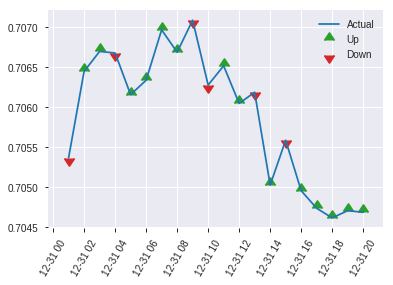


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20621823394669092
RMSE: 0.454112578494244
LogLoss: 0.5970827108976241
Mean Per-Class Error: 0.326540483701367
AUC: 0.7453154574132491
pr_auc: 0.7326245919102002
Gini: 0.49063091482649823
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3282799357114818: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      134  183  0.5773   (183.0/317.0)
1      32   268  0.1067   (32.0/300.0)
Total  166  451  0.3485   (215.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.32828      0.713715  273
max f2                       0.167508     0.845439  331
max f0point5                 0.502717     0.673077  143
max accuracy                 0.496578     0.675851  149
max precision                0.899835     1         0
max recall                   0.0179478    1         398
max specificity              0.899835     1         0
max absolute_mcc             0.362638     0.3631    253
max min_per_class_accuracy   0.464869     0.67      178
max mean_per_class_accuracy  0.495601     0.67346   150

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 42.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.869085           2.05667   2.05667            1                0.87763    1                           0.87763             0.0233333       0.0233333                  105.667    105.667
    2        0.0210697                   0.852717           2.05667   2.05667            1                0.857859   1                           0.868505            0.02            0.0433333                  105.667    105.667
    3        0.0307942                   0.843292           2.05667   2.05667            1                0.847502   1                           0.861872            0.02            0.0633333                  105.667    105.667
    4        0.0405186                   0.822457           1.71389   1.9744             0.833333         0.833079   0.96                        0.854962            0.0166667       0.08                       71.3889    97.44
    5        0.0502431                   0.791492           1.71389   1.92398            0.833333         0.816745   0.935484                    0.847565            0.0166667       0.0966667                  71.3889    92.3978
    6        0.100486                    0.64162            1.72495   1.82446            0.83871          0.694161   0.887097                    0.770863            0.0866667       0.183333                   72.4946    82.4462
    7        0.150729                    0.593887           1.19419   1.61437            0.580645         0.613904   0.784946                    0.718543            0.06            0.243333                   19.4194    61.4373
    8        0.200972                    0.56859            1.45957   1.57567            0.709677         0.580719   0.766129                    0.684087            0.0733333       0.316667                   45.957     57.5672
    9        0.299838                    0.526782           1.41607   1.52305            0.688525         0.547107   0.740541                    0.638921            0.14            0.456667                   41.6066    52.3045
    10       0.400324                    0.499299           1.16102   1.43217            0.564516         0.512268   0.696356                    0.607129            0.116667        0.573333                   16.1022    43.2173
    11       0.50081                     0.461271           0.995161  1.34449            0.483871         0.481355   0.653722                    0.581893            0.1             0.673333                   -0.483871  34.4488
    12       0.599676                    0.410894           0.910328  1.27291            0.442623         0.435903   0.618919                    0.557825            0.09            0.763333                   -8.96721   27.291
    13       0.700162                    0.350505           1.02833   1.23781            0.5              0.380568   0.601852                    0.532385            0.103333        0.866667                   2.83333    23.7809
    14       0.799028                    0.232343           0.708033  1.17226            0.344262         0.301411   0.56998                     0.503806            0.07            0.936667                   -29.1967   17.2258
    15       0.899514                    0.105154           0.431237  1.08948            0.209677         0.165049   0.52973                     0.465963            0.0433333       0.98                       -56.8763   8.94775
    16       1                           0.00952181         0.199032  1                  0.0967742        0.0660841  0.486224     

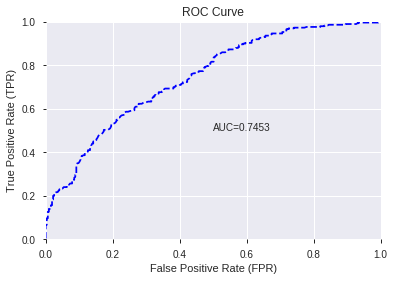

This function is available for GLM models only


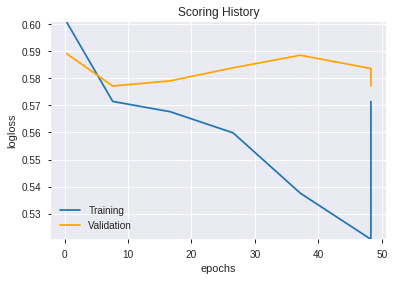

--2019-08-24 14:49:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.137.156
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.137.156|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_142903_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_142903_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_b8e3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'TRANGE',
 'CCI_8',
 'aroonup_8',
 'ULTOSC',
 'HT_DCPERIOD',
 'DX_30',
 'STOCHRSI_fastk',
 'DX_8',
 'AD',
 'STDDEV_12',
 'STOCHF_fastk',
 'BETA_12',
 'aroondown_8',
 'BETA_14',
 'AROONOSC_14',
 'BBANDS_upperband_14_2_5',
 'STOCH_slowk',
 'VAR_14',
 'BBANDS_upperband_8_7_3',
 'BETA_8',
 'HT_PHASOR_quadrature',
 'ROCR100_24',
 'ROCR_30',
 'CCI_20',
 'aroonup_20',
 'WILLR_20',
 'MACD_signal',
 'aroonup_30',
 'WILLR_8',
 'WILLR_14',
 'PLUS_DI_24',
 'ATR_30',
 'VAR_8',
 'MINUS_DM_14',
 'CCI_12',
 'VAR_12',
 'NATR_14',
 'MINUS_DM_20',
 'ROCR_20',
 'MFI_20',
 'STOCHF_fastd',
 'ROCR_8',
 'ROCP_24',
 'WILLR_12',
 'LINEARREG_SLOPE_8',
 'ROCR100_12',
 'PLUS_DM_20',
 'MOM_12',
 'CMO_12']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_145005_model_1  0.745473  0.607422               0.34031  0.456976  0.208827

variable  relative_importance  scaled_importance  percentage
0                       BOP             0.618674           1.000000    0.104350
1                     CCI_8             0.406777           0.657498    0.068610
2        CDLCLOSINGMARUBOZU             0.316244           0.511165    0.053340
3                    TRANGE             0.265233           0.428712    0.044736
4                    CCI_20             0.264530           0.427576    0.044617
5                   WILLR_8             0.261755           0.423090    0.044149
6                    ULTOSC             0.238502           0.385505    0.040227
7              STOCHF_fastk             0.235338           0.380391    0.039694
8               MACD_signal             0.196376           0.317414    0.033122
9                    CMO_12             0.193699           0.313087    0.032671
10                STDDEV_12             0.180646           0.291988    0.030469
11                      DIV             0.177970           0.287663    0.030018
12                  NATR_14             0.146328           0.236519    0.024681
13                   VAR_14             0.126767           0.204901    0.021381
14                  ROCR_20             0.125891           0.203484    0.021234
15                       AD             0.109867           0.177585    0.018531
16                    DX_30             0.101387           0.163878    0.017101
17                   MOM_12             0.098275           0.158847    0.016576
18                 WILLR_12             0.097943           0.158311    0.016520
19                  BETA_14             0.091261           0.147511    0.015393
20                aroonup_8             0.089558           0.144758    0.015105
21        LINEARREG_SLOPE_8             0.088815           0.143557    0.014980
22                   ATR_30             0.086037           0.139067    0.014512
23                  ROCR_30             0.085003           0.137396    0.014337
24                    VAR_8             0.081634           0.131950    0.013769
25                  BETA_12             0.078956           0.127622    0.013317
26   BBANDS_upperband_8_7_3             0.075020           0.121260    0.012653
27             STOCHF_fastd             0.073950           0.119529    0.012473
28              STOCH_slowk             0.071242           0.115153    0.012016
29              AROONOSC_14             0.070281           0.113600    0.011854
30                   MFI_20             0.067073           0.108414    0.011313
31                  ROCP_24             0.061834           0.099945    0.010429
32               ROCR100_24             0.060806           0.098285    0.010256
33                 WILLR_20             0.058637           0.094779    0.009890
34                   VAR_12             0.058426           0.094438    0.009855
35              MINUS_DM_20             0.058151           0.093992    0.009808
36                   ROCR_8             0.057913           0.093609    0.009768
37               PLUS_DM_20             0.056538           0.091386    0.009536
38                 WILLR_14             0.056278           0.090966    0.009492
39              MINUS_DM_14             0.051331           0.082970    0.008658
40                   CCI_12             0.050097           0.080975    0.008450
41               aroonup_20             0.044925           0.072616    0.007577
42              aroondown_8             0.039393           0.063674    0.006644
43               ROCR100_12             0.039145           0.063272    0.006602
44     HT_PHASOR_quadrature             0.034778           0.056213    0.005866
45                     DX_8             0.023245           0.037572    0.003921
46           STOCHRSI_fastk             0.019612           0.031700    0.003308
47               PLUS_DI_24             0.019487           0.031499    0.003287
48  BBANDS_upperband_14_2_5             0.007846           0.012682    0.001323
49              HT_

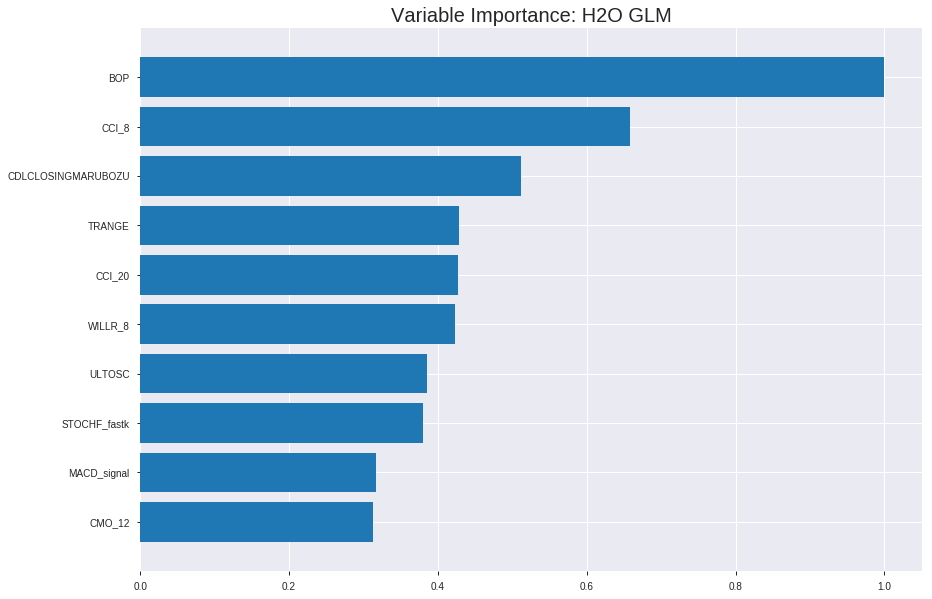

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_145005_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1953855604835197
RMSE: 0.44202438901436164
LogLoss: 0.5725641616224428
Null degrees of freedom: 4314
Residual degrees of freedom: 4262
Null deviance: 5970.536326910041
Residual deviance: 4941.228714801682
AIC: 5047.228714801682
AUC: 0.7682715661668601
pr_auc: 0.7317258980372648
Gini: 0.5365431323337202
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3852167792319442: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1234  1034  0.4559   (1034.0/2268.0)
1      319   1728  0.1558   (319.0/2047.0)
Total  1553  2762  0.3136   (1353.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.385217     0.718653  246
max f2                       0.163341     0.834791  342
max f0point5                 0.568898     0.685771  156
max accuracy                 0.453964     0.696871  215
max precision                0.943945     1         0
max recall                   0.0259605    1         395
max specificity              0.943945     1         0
max absolute_mcc             0.387385     0.404078  245
max min_per_class_accuracy   0.494067     0.693563  194
max mean_per_class_accuracy  0.439572     0.700036  222

Gains/Lift Table: Avg response rate: 47.44 %, avg score: 47.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.911856           1.91633   1.91633            0.909091         0.924599   0.909091                    0.924599            0.0195408       0.0195408                  91.633    91.633
    2        0.0201622                   0.895061           1.81383   1.86567            0.860465         0.903682   0.885057                    0.914261            0.0180752       0.037616                   81.3829   86.5668
    3        0.0301275                   0.87596            1.76481   1.83231            0.837209         0.884558   0.869231                    0.904436            0.0175867       0.0552027                  76.4806   83.2306
    4        0.0400927                   0.86517            1.86285   1.8399             0.883721         0.871171   0.872832                    0.896168            0.0185638       0.0737665                  86.2851   83.9898
    5        0.0500579                   0.841212           1.9609    1.86399            0.930233         0.853249   0.884259                    0.887624            0.0195408       0.0933073                  96.0896   86.3986
    6        0.100116                    0.7671             1.69808   1.78103            0.805556         0.799464   0.844907                    0.843544            0.0850024       0.17831                    69.8081   78.1033
    7        0.150174                    0.720369           1.62001   1.72736            0.768519         0.742926   0.819444                    0.810005            0.0810943       0.259404                   62.0009   72.7358
    8        0.2                         0.687055           1.50009   1.67074            0.711628         0.703074   0.792584                    0.783365            0.0747435       0.334148                   50.0085   67.0738
    9        0.300116                    0.619556           1.37603   1.57243            0.652778         0.653563   0.745946                    0.740064            0.137763        0.47191                    37.6031   57.2426
    10       0.4                         0.551182           1.24717   1.49121            0.591647         0.584817   0.707416                    0.701297            0.124573        0.596483                   24.7171   49.1207
    11       0.500116                    0.487538           1.08326   1.40954            0.513889         0.519717   0.668675                    0.664948            0.108451        0.704934                   8.32587   40.9541
    12       0.6                         0.414856           0.978173  1.33773            0.464037         0.449765   0.634608                    0.629125            0.097704        0.802638                   -2.1827   33.773
    13       0.699884                    0.342424           0.797211  1.26059            0.37819          0.378044   0.598013                    0.593292            0.0796287       0.882267                   -20.2789  26.059
    14       0.8                         0.256487           0.566027  1.17367            0.268519         0.300828   0.556779                    0.556692            0.0566683       0.938935                   -43.3973  17.3669
    15       0.899884                    0.144827           0.435287  1.09171            0.206497         0.204487   0.517899                    0.517598            0.0434783       0.982413                   -56.4713  9.17109
    16       1                           0.00623887         0.175664  1                  0.0833333        0.0860318  0.474392                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19311809622428405
RMSE: 0.4394520408694037
LogLoss: 0.5698245706061946
Null degrees of freedom: 1232
Residual degrees of freedom: 1180
Null deviance: 1711.616831684033
Residual deviance: 1405.187391114876
AIC: 1511.187391114876
AUC: 0.7822219064759559
pr_auc: 0.7670168006570067
Gini: 0.5644438129519118
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3522040490863958: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      336  285  0.4589   (285.0/621.0)
1      97   515  0.1585   (97.0/612.0)
Total  433  800  0.3098   (382.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.352204     0.729462  255
max f2                       0.0872968    0.843257  372
max f0point5                 0.540901     0.727201  162
max accuracy                 0.461831     0.721817  201
max precision                0.947473     1         0
max recall                   0.0515533    1         387
max specificity              0.947473     1         0
max absolute_mcc             0.461831     0.443586  201
max min_per_class_accuracy   0.45754      0.715686  203
max mean_per_class_accuracy  0.461831     0.72176   201

Gains/Lift Table: Avg response rate: 49.64 %, avg score: 45.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.897262           1.70475   1.70475            0.846154         0.91185    0.846154                    0.91185             0.0179739       0.0179739                  70.4751   70.4751
    2        0.0202758                   0.875073           2.01471   1.85353            1                0.886157   0.92                        0.899517            0.0196078       0.0375817                  101.471   85.3529
    3        0.0300081                   0.850569           1.67892   1.7969             0.833333         0.862658   0.891892                    0.887563            0.0163399       0.0539216                  67.8922   79.69
    4        0.0405515                   0.832051           2.01471   1.85353            1                0.841697   0.92                        0.875638            0.0212418       0.0751634                  101.471   85.3529
    5        0.0502839                   0.80542            1.67892   1.81973            0.833333         0.815323   0.903226                    0.863964            0.0163399       0.0915033                  67.8922   81.9734
    6        0.100568                    0.738146           1.68975   1.75474            0.83871          0.768734   0.870968                    0.816349            0.0849673       0.176471                   68.9753   75.4744
    7        0.150041                    0.699948           1.68443   1.73156            0.836066         0.718198   0.859459                    0.783986            0.0833333       0.259804                   68.4426   73.1558
    8        0.200324                    0.665862           1.52728   1.68028            0.758065         0.681633   0.834008                    0.758294            0.0767974       0.336601                   52.7277   68.0281
    9        0.300081                    0.594664           1.4578    1.60632            0.723577         0.630502   0.797297                    0.715811            0.145425        0.482026                   45.7795   60.632
    10       0.399838                    0.534082           1.27762   1.52431            0.634146         0.566062   0.756592                    0.67845             0.127451        0.609477                   27.7618   52.4311
    11       0.500406                    0.45637            1.0561    1.43021            0.524194         0.495241   0.709887                    0.64163             0.106209        0.715686                   5.60958   43.0213
    12       0.600162                    0.381154           0.818986  1.32862            0.406504         0.419624   0.659459                    0.604729            0.0816993       0.797386                   -18.1014  32.8617
    13       0.699919                    0.308171           0.786227  1.25131            0.390244         0.346442   0.621089                    0.567916            0.0784314       0.875817                   -21.3773  25.1312
    14       0.799676                    0.244367           0.524151  1.1606             0.260163         0.275708   0.576065                    0.531464            0.0522876       0.928105                   -47.5849  16.0601
    15       0.899432                    0.137207           0.425873  1.07911            0.211382         0.196806   0.535618                    0.494347            0.0424837       0.970588                   -57.4127  7.91121
    16       1                           0.00787159         0.292457  1                  0.145161         0.0798629  0.49635                     0.


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-24 14:50:05  0.000 sec   2            .2E2      50            1.3675442413153671  1.372812425523338
     2019-08-24 14:50:05  0.015 sec   4            .12E2     53            1.3597396117120875  1.3652460583569854
     2019-08-24 14:50:05  0.031 sec   6            .76E1     53            1.3491061797811423  1.354807498828635
     2019-08-24 14:50:05  0.048 sec   8            .47E1     53            1.335177884311381   1.3409307136262762
     2019-08-24 14:50:05  0.063 sec   10           .29E1     53            1.3176200069630022  1.3232118398959913
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-24 14:50:05  0.314 sec   39           .23E-2    53            1.1446074986151848  1.1397968368850862
     2019-08-24 14:50:05  0.323 sec   40           .14E-2    53            1.1442720472788246  1.1401425721457985
     2019-08-24 14:50:05  0.333 sec   41           .9E-3     53            1.1440313565611542  1.1405702674862943
     2019-08-24 14:50:05  0.343 sec   42           .56E-3    53            1.1438435910085092  1.1408926595338824
     2019-08-24 14:50:05  0.352 sec   43           .35E-3    53            1.1436784979324537  1.1411639756589267


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6742301458670988)

('F1', 0.7154255319148937)

('auc', 0.7454731861198738)

('logloss', 0.6074224702416887)

('mean_per_class_error', 0.32692429022082026)

('rmse', 0.45697569836657287)

('mse', 0.208826788897617)

glm prediction progress: |████████████████████████████████████████████████| 100%


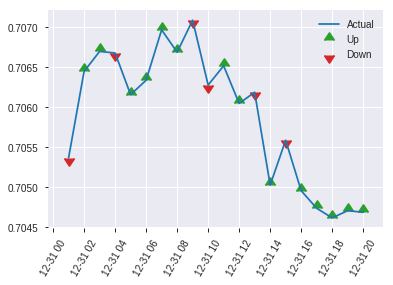


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.208826788897617
RMSE: 0.45697569836657287
LogLoss: 0.6074224702416887
Null degrees of freedom: 616
Residual degrees of freedom: 564
Null deviance: 855.2213378304502
Residual deviance: 749.5593282782437
AIC: 855.5593282782437
AUC: 0.7454731861198738
pr_auc: 0.7322873063615923
Gini: 0.4909463722397476
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25273883581910433: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      134  183  0.5773   (183.0/317.0)
1      31   269  0.1033   (31.0/300.0)
Total  165  452  0.3468   (214.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.252739     0.715426  291
max f2                       0.0679927    0.837079  372
max f0point5                 0.501312     0.671141  152
max accuracy                 0.447812     0.67423   181
max precision                0.916289     1         0
max recall                   0.00332723   1         399
max specificity              0.916289     1         0
max absolute_mcc             0.252739     0.36065   291
max min_per_class_accuracy   0.422228     0.67      197
max mean_per_class_accuracy  0.408245     0.673076  206

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 41.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.893094           2.05667   2.05667            1                0.902756   1                           0.902756            0.0233333       0.0233333                  105.667    105.667
    2        0.0210697                   0.861105           2.05667   2.05667            1                0.877753   1                           0.891216            0.02            0.0433333                  105.667    105.667
    3        0.0307942                   0.845082           1.71389   1.94842            0.833333         0.851995   0.947368                    0.87883             0.0166667       0.06                       71.3889    94.8421
    4        0.0405186                   0.813632           1.71389   1.89213            0.833333         0.834758   0.92                        0.868253            0.0166667       0.0766667                  71.3889    89.2133
    5        0.0502431                   0.80034            1.71389   1.85763            0.833333         0.807075   0.903226                    0.856412            0.0166667       0.0933333                  71.3889    85.7634
    6        0.100486                    0.695906           1.72495   1.79129            0.83871          0.739796   0.870968                    0.798104            0.0866667       0.18                       72.4946    79.129
    7        0.150729                    0.65521            1.52591   1.70283            0.741935         0.675553   0.827957                    0.757254            0.0766667       0.256667                   52.5914    70.2832
    8        0.200972                    0.609303           1.59226   1.67519            0.774194         0.630302   0.814516                    0.725516            0.08            0.336667                   59.2258    67.5188
    9        0.299838                    0.542119           1.24749   1.53416            0.606557         0.574069   0.745946                    0.675579            0.123333        0.46                       24.7486    53.4162
    10       0.400324                    0.47197            0.995161  1.39887            0.483871         0.509269   0.680162                    0.633833            0.1             0.56                       -0.483871  39.8866
    11       0.50081                     0.416313           1.12785   1.34449            0.548387         0.445409   0.653722                    0.596027            0.113333        0.673333                   12.7849    34.4488
    12       0.599676                    0.34899            0.944044  1.27847            0.459016         0.382672   0.621622                    0.560852            0.0933333       0.766667                   -5.59563   27.8468
    13       0.700162                    0.274682           0.961989  1.23305            0.467742         0.312271   0.599537                    0.525176            0.0966667       0.863333                   -3.80108   23.3048
    14       0.799028                    0.197429           0.775464  1.17643            0.377049         0.238269   0.572008                    0.489676            0.0766667       0.94                       -22.4536   17.643
    15       0.899514                    0.104336           0.33172   1.08207            0.16129          0.150315   0.526126                    0.451766            0.0333333       0.973333                   -66.828    8.20661
    16       1                           0.00326443         0.265376  1                  0.129032         0.0589509  0.486224    

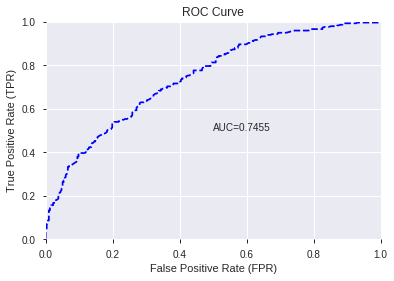

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


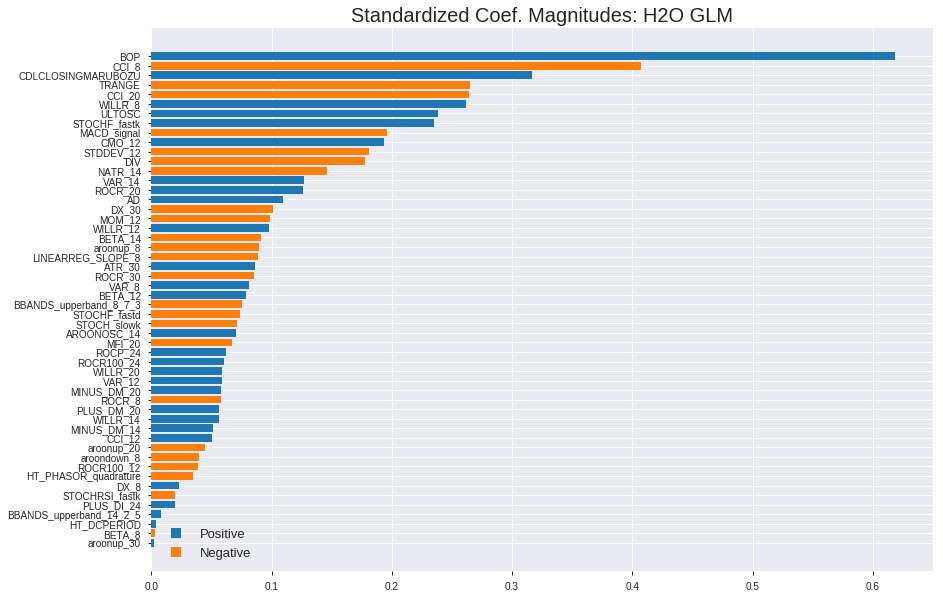

'log_likelihood'
--2019-08-24 14:50:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.252
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.252|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_145005_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_145005_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_b8e3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'CCI_8',
 'CDLCLOSINGMARUBOZU',
 'TRANGE',
 'CCI_20',
 'WILLR_8',
 'ULTOSC',
 'STOCHF_fastk',
 'MACD_signal',
 'CMO_12',
 'STDDEV_12',
 'DIV',
 'NATR_14',
 'VAR_14',
 'ROCR_20',
 'AD',
 'DX_30',
 'MOM_12',
 'WILLR_12',
 'BETA_14',
 'aroonup_8',
 'LINEARREG_SLOPE_8',
 'ATR_30',
 'ROCR_30',
 'VAR_8',
 'BETA_12',
 'BBANDS_upperband_8_7_3',
 'STOCHF_fastd',
 'STOCH_slowk',
 'AROONOSC_14',
 'MFI_20',
 'ROCP_24',
 'ROCR100_24',
 'WILLR_20',
 'VAR_12',
 'MINUS_DM_20',
 'ROCR_8',
 'PLUS_DM_20',
 'WILLR_14',
 'MINUS_DM_14',
 'CCI_12',
 'aroonup_20',
 'aroondown_8',
 'ROCR100_12',
 'HT_PHASOR_quadrature',
 'DX_8',
 'STOCHRSI_fastk',
 'PLUS_DI_24',
 'BBANDS_upperband_14_2_5',
 'HT_DCPERIOD',
 'BETA_8',
 'aroonup_30']

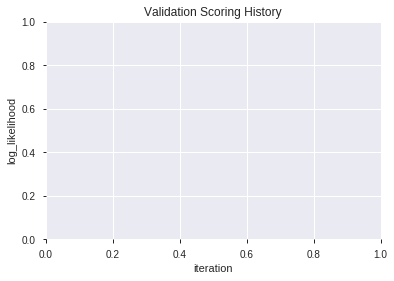

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190824_145112  0.743833  0.593116              0.324033  0.452543  0.204795
1  XGBoost_grid_1_AutoML_20190824_145112_model_4  0.741914  0.591578              0.344238  0.452318  0.204592
2  XGBoost_grid_1_AutoML_20190824_145112_model_2  0.739774  0.594508              0.348612  0.453375  0.205549
3  XGBoost_grid_1_AutoML_20190824_145112_model_3  0.739374  0.589889              0.339506  0.452176  0.204464
4  XGBoost_grid_1_AutoML_20190824_145112_model_6  0.738297  0.595901              0.365783  0.454122  0.206227
5               XGBoost_2_AutoML_20190824_145112  0.737161  0.598685              0.347303  0.455591  0.207563
6  XGBoost_grid_1_AutoML_20190824_145112_model_1  0.734054  0.596763              0.331115  0.454469  0.206542
7               XGBoost_1_AutoML_20190824_145112  0.733139  0.602564              0.358523  0.457323  0.209144
8  XGBoost_grid_1_AutoML_20190824_145112_model_7  0.729958  0.606678              0.367093  0.459485  0.211126
9  XGBoost_grid_1_AutoML_20190824_145112_model_5  0.725468  0.622684              0.349595  0.465084  0.216303

variable  relative_importance  scaled_importance  percentage
0                       BOP          5284.051758           1.000000    0.306507
1              STOCHF_fastk           964.957642           0.182617    0.055973
2                       DIV           932.415771           0.176458    0.054086
3        CDLCLOSINGMARUBOZU           757.787048           0.143410    0.043956
4                    TRANGE           698.282043           0.132149    0.040505
5            STOCHRSI_fastk           678.870850           0.128475    0.039379
6                     CCI_8           496.758850           0.094011    0.028815
7                   WILLR_8           496.088745           0.093884    0.028776
8                 aroonup_8           392.861206           0.074348    0.022788
9                  WILLR_12           339.941650           0.064334    0.019719
10                  BETA_12           305.841888           0.057880    0.017741
11                   ULTOSC           294.245178           0.055686    0.017068
12                   CCI_12           292.476044           0.055351    0.016965
13                   CCI_20           278.657501           0.052736    0.016164
14                STDDEV_12           266.775177           0.050487    0.015475
15                   BETA_8           222.623260           0.042131    0.012913
16                  BETA_14           217.654007           0.041191    0.012625
17                       AD           216.714951           0.041013    0.012571
18     HT_PHASOR_quadrature           209.642273           0.039675    0.012161
19                 WILLR_14           191.584503           0.036257    0.011113
20   BBANDS_upperband_8_7_3           190.756119           0.036100    0.011065
21              HT_DCPERIOD           185.818466           0.035166    0.010779
22        LINEARREG_SLOPE_8           180.363220           0.034134    0.010462
23                   ROCR_8           178.455399           0.033772    0.010351
24  BBANDS_upperband_14_2_5           171.946365           0.032541    0.009974
25                   MFI_20           170.849884           0.032333    0.009910
26                  NATR_14           166.861130           0.031578    0.009679
27                   ATR_30           166.593063           0.031528    0.009663
28                  ROCR_20           165.781784           0.031374    0.009616
29                   VAR_14           159.508423           0.030187    0.009252
30                  ROCR_30           149.354385           0.028265    0.008663
31              MACD_signal           142.103409           0.026893    0.008243
32                    VAR_8           142.015656           0.026876    0.008238
33              MINUS_DM_14           135.303177           0.025606    0.007848
34               PLUS_DI_24           133.583817           0.025281    0.007749
35               PLUS_DM_20           124.457130           0.023553    0.007219
36              MINUS_DM_20           106.875580           0.020226    0.006199
37              AROONOSC_14           105.799171           0.020022    0.006137
38                    DX_30           104.625977           0.019800    0.006069
39                     DX_8           100.643562           0.019047    0.005838
40                   MOM_12            91.667381           0.017348    0.005317
41                  ROCP_24            91.537376           0.017323    0.005310
42                   CMO_12            90.124710           0.017056    0.005228
43              STOCH_slowk            86.429031           0.016357    0.005013
44              aroondown_8            66.049431           0.012500    0.003831
45                   VAR_12            58.625183           0.011095    0.003401
46                 WILLR_20            52.028049           0.009846    0.003018
47               aroonup_30            44.737152           0.008466    0.002595
48               ROCR100_12            36.984634           0.006999    0.002145
49               ar

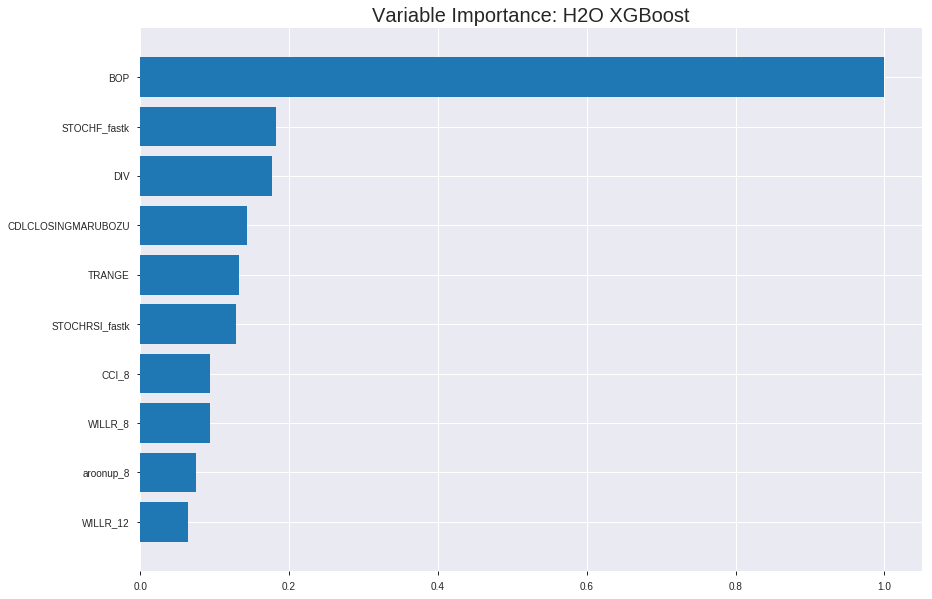

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190824_145112


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15563757527519004
RMSE: 0.39450928414321257
LogLoss: 0.47866592495954474
Mean Per-Class Error: 0.21815197790201868
AUC: 0.8737114967574177
pr_auc: 0.8681614557699778
Gini: 0.7474229935148353
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44630206293529934: 


0     1     Error    Rate
-----  ----  ----  -------  --------------
0      1553  715   0.3153   (715.0/2268.0)
1      273   1774  0.1334   (273.0/2047.0)
Total  1826  2489  0.229    (988.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.446302     0.782187  216
max f2                       0.216307     0.865467  322
max f0point5                 0.599256     0.792426  141
max accuracy                 0.501193     0.780997  190
max precision                0.954094     1         0
max recall                   0.137996     1         359
max specificity              0.954094     1         0
max absolute_mcc             0.493355     0.563099  194
max min_per_class_accuracy   0.510074     0.779678  185
max mean_per_class_accuracy  0.493355     0.781848  194

Gains/Lift Table: Avg response rate: 47.44 %, avg score: 47.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.921421           2.10796   2.10796            1                0.933026   1                           0.933026            0.0214949       0.0214949                  110.796   110.796
    2        0.0201622                   0.90317            2.10796   2.10796            1                0.912639   1                           0.922949            0.0210064       0.0425012                  110.796   110.796
    3        0.0301275                   0.872486           2.10796   2.10796            1                0.886525   1                           0.910901            0.0210064       0.0635076                  110.796   110.796
    4        0.0400927                   0.852249           2.10796   2.10796            1                0.861543   1                           0.898633            0.0210064       0.0845139                  110.796   110.796
    5        0.0500579                   0.830439           2.05894   2.0982             0.976744         0.842246   0.99537                     0.887408            0.0205178       0.105032                   105.894   109.82
    6        0.100116                    0.766174           2.06893   2.08357            0.981481         0.795912   0.988426                    0.84166             0.103566        0.208598                   106.893   108.357
    7        0.150174                    0.716481           1.98109   2.04941            0.939815         0.73923    0.972222                    0.807517            0.0991695       0.307767                   98.1095   104.941
    8        0.2                         0.678971           1.80402   1.98828            0.855814         0.69578    0.943221                    0.77968             0.0898876       0.397655                   80.4024   98.8276
    9        0.300116                    0.61774            1.58585   1.85403            0.752315         0.647307   0.879537                    0.735521            0.158769        0.556424                   58.5852   85.4031
    10       0.4                         0.560342           1.25206   1.70371            0.593968         0.589659   0.808227                    0.699098            0.125061        0.681485                   25.2061   70.3713
    11       0.500116                    0.499653           1.13693   1.59025            0.539352         0.5298     0.754402                    0.665207            0.113825        0.79531                    13.6934   59.0252
    12       0.6                         0.427177           0.870574  1.47044            0.412993         0.464364   0.697567                    0.631772            0.0869565       0.882267                   -12.9426  47.0445
    13       0.699884                    0.343859           0.606467  1.34714            0.287703         0.387171   0.639073                    0.596864            0.0605765       0.942843                   -39.3533  34.7142
    14       0.8                         0.236722           0.395243  1.22802            0.1875           0.292074   0.582561                    0.558721            0.0395701       0.982413                   -60.4757  22.8017
    15       0.899884                    0.132803           0.176071  1.11125            0.0835267        0.181427   0.52717                     0.516842            0.0175867       1                          -82.3929  11.1254
    16       1                           0.0353946          0         1                  0                0.0926003  0.474392                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19095732027837023
RMSE: 0.43698663626977224
LogLoss: 0.5650214633836004
Mean Per-Class Error: 0.27433219664677466
AUC: 0.7862410933240714
pr_auc: 0.767028465427465
Gini: 0.5724821866481429
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44180089235305786: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      398  223  0.3591   (223.0/621.0)
1      126  486  0.2059   (126.0/612.0)
Total  524  709  0.283    (349.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.441801     0.735806  221
max f2                       0.219864     0.842227  326
max f0point5                 0.531878     0.730357  173
max accuracy                 0.516915     0.725872  182
max precision                0.95269      1         0
max recall                   0.0763633    1         387
max specificity              0.95269      1         0
max absolute_mcc             0.516915     0.452117  182
max min_per_class_accuracy   0.496631     0.718196  192
max mean_per_class_accuracy  0.516915     0.725668  182

Gains/Lift Table: Avg response rate: 49.64 %, avg score: 47.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.922211           1.3948    1.3948             0.692308         0.933881   0.692308                    0.933881            0.0147059       0.0147059                  39.4796   39.4796
    2        0.0202758                   0.882422           2.01471   1.69235            1                0.905817   0.84                        0.92041             0.0196078       0.0343137                  101.471   69.2353
    3        0.0300081                   0.861259           2.01471   1.7969             1                0.870994   0.891892                    0.904383            0.0196078       0.0539216                  101.471   79.69
    4        0.0405515                   0.841088           1.85973   1.81324            0.923077         0.853777   0.9                         0.891226            0.0196078       0.0735294                  85.9729   81.3235
    5        0.0502839                   0.827629           1.67892   1.78724            0.833333         0.834137   0.887097                    0.880176            0.0163399       0.0898693                  67.8922   78.7239
    6        0.100568                    0.740311           1.78724   1.78724            0.887097         0.777478   0.887097                    0.828827            0.0898693       0.179739                   78.7239   78.7239
    7        0.150041                    0.692363           1.71745   1.76423            0.852459         0.713941   0.875676                    0.790946            0.0849673       0.264706                   71.7454   76.4229
    8        0.200324                    0.66294            1.52728   1.70475            0.758065         0.677112   0.846154                    0.762372            0.0767974       0.341503                   52.7277   70.4751
    9        0.300081                    0.610925           1.42504   1.61176            0.707317         0.636223   0.8                         0.720436            0.142157        0.48366                    42.5036   61.1765
    10       0.399838                    0.553148           1.26124   1.52431            0.626016         0.582611   0.756592                    0.68605             0.125817        0.609477                   26.1239   52.4311
    11       0.500406                    0.493675           1.10484   1.44001            0.548387         0.526114   0.714749                    0.653907            0.111111        0.720588                   10.4839   44.0009
    12       0.600162                    0.416607           0.868125  1.34495            0.430894         0.458034   0.667568                    0.62135             0.0866013       0.80719                    -13.1875  34.4952
    13       0.699919                    0.346944           0.60605   1.23964            0.300813         0.378359   0.615295                    0.586717            0.0604575       0.867647                   -39.395   23.9639
    14       0.799676                    0.252799           0.737088  1.17695            0.365854         0.303976   0.584178                    0.551446            0.0735294       0.941176                   -26.2912  17.6948
    15       0.899432                    0.141942           0.343974  1.08456            0.170732         0.194561   0.538323                    0.511864            0.0343137       0.97549                    -65.6026  8.45621
    16       1                           0.0374702          0.243714  1                  0.120968         0.0990239  0.49635                     0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 14:51:18  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.525608                         0.5                0.693147              0.5               0                    1                  0.50365
    2019-08-24 14:51:18  0.090 sec   5                  0.476656         0.647244            0.805336        0.783623           2.10796          0.284125                         0.481135           0.655893              0.770875          0.753733             1.85973            0.304136
    2019-08-24 14:51:18  0.150 sec   10                 0.459511         0.613844            0.808422        0.78941            2.10796          0.282039                         0.467066           0.628257              0.771985          0.753512             1.70475            0.30738
    2019-08-24 14:51:18  0.216 sec   15                 0.447651         0.590184            0.810886        0.792791           2.10796          0.273233                         0.457706           0.609488              0.777651          0.758863             1.70475            0.341444
    2019-08-24 14:51:18  0.285 sec   20                 0.43895          0.572394            0.817891        0.80042            2.10796          0.26628                          0.451915           0.597432              0.778759          0.761215             1.54977            0.278994
    2019-08-24 14:51:19  0.361 sec   25                 0.431609         0.55705             0.823611        0.809386           2.10796          0.264658                         0.44817            0.589398              0.778916          0.760912             1.3948             0.296837
    2019-08-24 14:51:19  0.437 sec   30                 0.425961         0.544852            0.829012        0.816363           2.10796          0.273233                         0.445289           0.583055              0.77956           0.760785             1.3948             0.294404
    2019-08-24 14:51:19  0.522 sec   35                 0.421705         0.535485            0.832926        0.820718           2.10796          0.266744                         0.443491           0.578977              0.779634          0.760874             1.3948             0.294404
    2019-08-24 14:51:19  0.600 sec   40                 0.418036         0.527269            0.837553        0.826063           2.10796          0.262341                         0.441695           0.575012              0.781162          0.760941             1.54977            0.291971
    2019-08-24 14:51:19  0.678 sec   45                 0.414618         0.51976             0.842049        0.831493           2.10796          0.252839                         0.440867           0.5731                0.781671          0.760596             1.54977            0.304136
    2019-08-24 14:51:19  0.755 sec   50                 0.411052         0.512073            0.847046        0.834959           2.10796          0.248667                         0.439715           0.570532              0.783149          0.765234             1.54977            0.295215
    2019-08-24 14:51:19  0.849 sec   55                 0.408064         0.505783            0.851608        0.841765           2.10796          0.244496                         0.438709           0.568639              0.785281          0.7

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ---------------------
BOP                 5284.0517578125        1.0                    0.3065065947721845
STOCHF_fastk        964.9576416015625      0.18261699276031262    0.05597331259850009
DIV                 932.415771484375       0.17645848568871284    0.05408568956710363
CDLCLOSINGMARUBOZU  757.7870483398438      0.14341022440203227    0.04395617953698175
TRANGE              698.2820434570312      0.13214897874999376    0.04050453347928236
---                 ---                    ---                    ---
aroonup_30          44.737152099609375     0.008466448503927927   0.0025950223007530047
ROCR100_12          36.98463439941406      0.006999294498721      0.0021453299226106576
aroonup_20          36.959747314453125     0.0069945846498963475  0.0021438863228855215
ROCR100_24          34.99806213378906      0.006623338252136579   0.0020300968536867353
STOCHF_fastd        29.53535270690918      0.005589527518015129   0.001713227045932237


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6888168557536467)

('F1', 0.7168758716875873)

('auc', 0.7438328075709779)

('logloss', 0.593116093702663)

('mean_per_class_error', 0.31061514195583606)

('rmse', 0.45254316896442454)

('mse', 0.2047953197763637)

xgboost prediction progress: |████████████████████████████████████████████| 100%


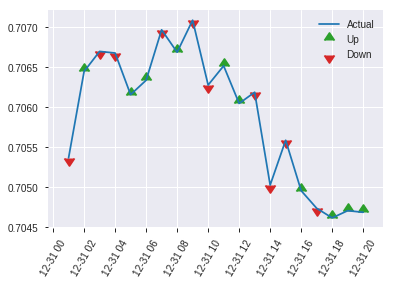


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2047953197763637
RMSE: 0.45254316896442454
LogLoss: 0.593116093702663
Mean Per-Class Error: 0.31061514195583606
AUC: 0.7438328075709779
pr_auc: 0.7071073150456954
Gini: 0.48766561514195583
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35500356554985046: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      157  160  0.5047   (160.0/317.0)
1      43   257  0.1433   (43.0/300.0)
Total  200  417  0.329    (203.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.355004     0.716876  265
max f2                       0.151115     0.849598  347
max f0point5                 0.465529     0.677481  202
max accuracy                 0.465529     0.688817  202
max precision                0.930003     1         0
max recall                   0.0426867    1         399
max specificity              0.930003     1         0
max absolute_mcc             0.408286     0.384523  240
max min_per_class_accuracy   0.473011     0.671924  196
max mean_per_class_accuracy  0.465529     0.689385  202

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 45.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.918161           1.76286   1.76286            0.857143         0.926953   0.857143                    0.926953            0.02            0.02                       76.2857   76.2857
    2        0.0210697                   0.904345           2.05667   1.89846            1                0.912083   0.923077                    0.92009             0.02            0.04                       105.667   89.8462
    3        0.0307942                   0.884934           1.71389   1.84018            0.833333         0.895208   0.894737                    0.912233            0.0166667       0.0566667                  71.3889   84.0175
    4        0.0405186                   0.857177           2.05667   1.89213            1                0.869099   0.92                        0.901881            0.02            0.0766667                  105.667   89.2133
    5        0.0502431                   0.814917           1.71389   1.85763            0.833333         0.829472   0.903226                    0.887866            0.0166667       0.0933333                  71.3889   85.7634
    6        0.100486                    0.712337           1.52591   1.69177            0.741935         0.758022   0.822581                    0.822944            0.0766667       0.17                       52.5914   69.1774
    7        0.150729                    0.67437            1.39323   1.59226            0.677419         0.691904   0.774194                    0.779264            0.07            0.24                       39.3226   59.2258
    8        0.200972                    0.639679           1.19419   1.49274            0.580645         0.656644   0.725806                    0.748609            0.06            0.3                        19.4194   49.2742
    9        0.299838                    0.580683           1.44978   1.47858            0.704918         0.606108   0.718919                    0.701622            0.143333        0.443333                   44.9781   47.8577
    10       0.400324                    0.527979           1.29371   1.43217            0.629032         0.558647   0.696356                    0.665734            0.13            0.573333                   29.371    43.2173
    11       0.50081                     0.47179            1.09468   1.36446            0.532258         0.499019   0.66343                     0.632283            0.11            0.683333                   9.46774   36.4455
    12       0.599676                    0.414888           0.97776   1.3007             0.47541          0.442581   0.632432                    0.601008            0.0966667       0.78                       -2.22404  30.0703
    13       0.700162                    0.335368           0.829301  1.23305            0.403226         0.377668   0.599537                    0.568954            0.0833333       0.863333                   -17.0699  23.3048
    14       0.799028                    0.218941           0.775464  1.17643            0.377049         0.282458   0.572008                    0.533506            0.0766667       0.94                       -22.4536  17.643
    15       0.899514                    0.13439            0.464409  1.09689            0.225806         0.172711   0.533333                    0.493201            0.0466667       0.986667                   -53.5591  9.68889
    16       1                           0.0426867          0.132688  1                  0.0645161        0.0908629  0.486224                    

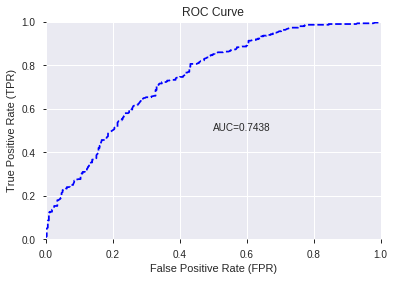

This function is available for GLM models only


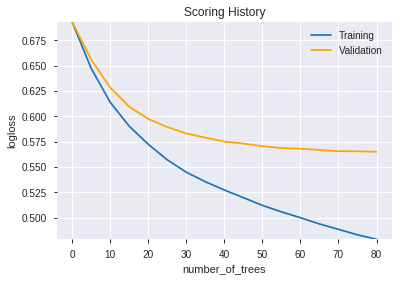

--2019-08-24 14:51:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.111.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.111.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190824_145112',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190824_145112',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_b8e3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_b8e3',
   'ty

['BOP',
 'STOCHF_fastk',
 'DIV',
 'CDLCLOSINGMARUBOZU',
 'TRANGE',
 'STOCHRSI_fastk',
 'CCI_8',
 'WILLR_8',
 'aroonup_8',
 'WILLR_12',
 'BETA_12',
 'ULTOSC',
 'CCI_12',
 'CCI_20',
 'STDDEV_12',
 'BETA_8',
 'BETA_14',
 'AD',
 'HT_PHASOR_quadrature',
 'WILLR_14',
 'BBANDS_upperband_8_7_3',
 'HT_DCPERIOD',
 'LINEARREG_SLOPE_8',
 'ROCR_8',
 'BBANDS_upperband_14_2_5',
 'MFI_20',
 'NATR_14',
 'ATR_30',
 'ROCR_20',
 'VAR_14',
 'ROCR_30',
 'MACD_signal',
 'VAR_8',
 'MINUS_DM_14',
 'PLUS_DI_24',
 'PLUS_DM_20',
 'MINUS_DM_20',
 'AROONOSC_14',
 'DX_30',
 'DX_8',
 'MOM_12',
 'ROCP_24',
 'CMO_12',
 'STOCH_slowk',
 'aroondown_8',
 'VAR_12',
 'WILLR_20',
 'aroonup_30',
 'ROCR100_12',
 'aroonup_20',
 'ROCR100_24',
 'STOCHF_fastd']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.687
GLM             0.684
XGBoost         0.695
dtype: float64

DeepLearning    GLM  XGBoost
All          0.677  0.682    0.684
DLF          0.687  0.684    0.695
Fwe          0.687  0.679    0.682
RFE          0.676  0.674    0.689
XGBF         0.687  0.684    0.695





F1


DeepLearning    0.732
GLM             0.721
XGBoost         0.726
dtype: float64

DeepLearning    GLM  XGBoost
All          0.724  0.715    0.714
DLF          0.721  0.721    0.726
Fwe          0.732  0.721    0.715
RFE          0.714  0.715    0.717
XGBF         0.722  0.721    0.726





auc


DeepLearning    0.760
GLM             0.755
XGBoost         0.753
dtype: float64

DeepLearning    GLM  XGBoost
All          0.738  0.745    0.743
DLF          0.755  0.752    0.751
Fwe          0.760  0.755    0.753
RFE          0.745  0.745    0.744
XGBF         0.754  0.752    0.751





logloss


DeepLearning    0.615
GLM             0.630
XGBoost         0.593
dtype: float64

DeepLearning    GLM  XGBoost
All          0.615  0.630    0.593
DLF          0.602  0.614    0.589
Fwe          0.589  0.590    0.586
RFE          0.597  0.607    0.593
XGBF         0.598  0.614    0.589





mean_per_class_error


DeepLearning    0.327
GLM             0.327
XGBoost         0.318
dtype: float64

DeepLearning    GLM  XGBoost
All          0.319  0.317    0.315
DLF          0.310  0.315    0.304
Fwe          0.308  0.320    0.318
RFE          0.327  0.327    0.311
XGBF         0.311  0.315    0.304





rmse


DeepLearning    0.460
GLM             0.468
XGBoost         0.453
dtype: float64

DeepLearning    GLM  XGBoost
All          0.460  0.468    0.453
DLF          0.453  0.459    0.451
Fwe          0.448  0.449    0.449
RFE          0.454  0.457    0.453
XGBF         0.451  0.459    0.451





mse


DeepLearning    0.211
GLM             0.219
XGBoost         0.206
dtype: float64

DeepLearning    GLM  XGBoost
All          0.211  0.219    0.206
DLF          0.205  0.211    0.203
Fwe          0.201  0.201    0.201
RFE          0.206  0.209    0.205
XGBF         0.204  0.211    0.203

{'F1':       DeepLearning    GLM  XGBoost
 All          0.724    NaN      NaN
 DLF          0.721    NaN      NaN
 DLF            NaN  0.721      NaN
 DLF            NaN    NaN    0.726
 All            NaN  0.715      NaN
 All            NaN    NaN    0.714
 XGBF         0.722    NaN      NaN
 XGBF           NaN  0.721      NaN
 XGBF           NaN    NaN    0.726
 Fwe          0.732    NaN      NaN
 Fwe            NaN  0.721      NaN
 Fwe            NaN    NaN    0.715
 RFE          0.714    NaN      NaN
 RFE            NaN  0.715      NaN
 RFE            NaN    NaN    0.717,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.677    NaN      NaN
 DLF          0.687    NaN      NaN
 DLF            NaN  0.684      NaN
 DLF            NaN    NaN    0.695
 All            NaN  0.682      NaN
 All            NaN    NaN    0.684
 XGBF         0.687    NaN      NaN
 XGBF           NaN  0.684      NaN
 XGBF           NaN    NaN    0.695
 Fwe          0.687    NaN      NaN
 Fwe     